In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.tsatools import detrend
import pmdarima as pm

In [2]:
pwd

'E:\\AI_Program\\Course10_project\\notebooks'

In [3]:
cd ..

E:\AI_Program\Course10_project


In [4]:
dataset = pd.read_csv('./data/output_csv/cleaned_dataset.csv')

### Manual needed function

In [5]:
def EDA_FS_01(dataset):
    display(dataset.head(5))
    display(dataset.info())
    display(dataset.describe())
    display(dataset.isnull().sum())
    print('#####################################################')
    

In [6]:
def ss_decomposition(dataset, model=['additive','multiplicative'], freq=12):
    from statsmodels.tsa.seasonal import seasonal_decompose
    # decomposition
    decomposition = seasonal_decompose(x=dataset, model=model, period=freq)
    estimated_trend, estimated_seasonal, estimated_residual = decomposition.trend, decomposition.seasonal, decomposition.resid

    # plotting
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)
    
    axes[0].plot(dataset, label='Original')
    axes[0].legend(loc='upper left')
    axes[0].title.set_text('Orginal Series')

    axes[1].plot(estimated_trend, label='Trend')
    axes[1].legend(loc='upper left')
    axes[1].title.set_text('Trend of Series')

    axes[2].plot(estimated_seasonal, label='Seasonality')
    axes[2].legend(loc='upper left')
    axes[2].title.set_text('Seasonality of Series')

    axes[3].plot(estimated_residual, label='Residuals')
    axes[3].legend(loc='upper left')
    axes[3].title.set_text('Residuals of Series')

In [7]:
# define Dickey-Fuller Test (DFT) function
# Null is that unit root is present, rejection means likely stationary
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

In [8]:
# define helper plot function for visualization title=title,lags=lags
def plots(data, lags=None):
    layout = (2, 2)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (1, 0))
    pacf = plt.subplot2grid(layout, (1, 1))
    
    raw.plot(data)
    sm.tsa.graphics.plot_acf(data, lags=lags, ax=acf, zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()
    plt.tight_layout()
    plt.show()

In [9]:
def cross_validate(series,horizon,start,step_size,order = (1,0,0),seasonal_order = (0,0,0,0),trend=None):
    '''
    Function to determine in and out of sample testing of arima model    
    
    arguments
    ---------
    series (seris): time series input
    horizon (int): how far in advance forecast is needed
    start (int): starting location in series
    step_size (int): how often to recalculate forecast
    order (tuple): (p,d,q) order of the model
    seasonal_order (tuple): (P,D,Q,s) seasonal order of model
    
    Returns
    -------
    DataFrame: gives fcst and actuals with date of prediction
    '''
    fcst = []
    actual = []
    date = []
    for i in range(start,len(series)-horizon,step_size):
        model = sm.tsa.statespace.SARIMAX(series[:i+1], #only using data through to and including start 
                                order=order, 
                                seasonal_order=seasonal_order, 
                                trend=trend).fit()
        fcst.append(model.forecast(steps = horizon)[-1]) #forecasting horizon steps into the future
        actual.append(series[i+horizon]) # comparing that to actual value at that point
        date.append(series.index[i+horizon]) # saving date of that value
    return pd.DataFrame({'fcst':fcst,'actual':actual},index=date)

In [10]:
#Defining an error metric to see out of sample accuracy
def mape(df_cv):
    return abs(df_cv.actual - df_cv.fcst).sum() / abs(df_cv.actual).sum()

In [11]:
def grid_search_ARIMA(series,horizon,start,step_size,orders = [(1,0,0)],seasonal_orders = [(0,0,0,0)],trends=[None]):
    best_mape = np.inf
    best_order = None
    best_seasonal_order = None
    best_trend = None
    for order_ in orders:
        for seasonal_order_ in seasonal_orders:
            for trend_ in trends:
                
                cv = cross_validate(series,
                                    horizon,
                                    start,
                                    step_size,
                                    order = order_,
                                    seasonal_order = seasonal_order_,
                                    trend=trend_)
                if mape(cv)<best_mape:
                    best_mape = mape(cv)
                    best_order = order_
                    best_seasonal_order = seasonal_order_
                    best_trend = trend_
    return (best_order,best_seasonal_order, best_trend, best_mape)

### preprocessing

In [12]:
EDA_FS_01(dataset)

datetime  temp  humidity     precip  precipcover    snow  snowdepth  \
0  2010-01-01  2.35   96.1875  14.975125     34.37375  1.1250     6.5250   
1  2010-01-02 -3.00   80.4750   0.822250     34.37250  1.0625     7.9125   
2  2010-01-03 -5.80   70.0375   0.000000      0.00000  0.2500     8.3500   
3  2010-01-04 -6.80   83.8125   0.000000      0.00000  0.0000     8.3375   
4  2010-01-05 -5.95   88.6250   0.000000      0.00000  0.0500     8.3375   

   windgust  windspeed   winddir  ...  solarradiation  solarenergy  uvindex  \
0   39.2125    18.2125  265.3875  ...         33.1625       2.8375    1.250   
1   49.4000    22.3500  253.0000  ...         42.4375       3.6625    2.000   
2   24.0000    11.2625  201.6250  ...         80.0750       6.9125    3.875   
3   18.6250     9.7125  205.9875  ...         71.1750       6.1375    3.875   
4   18.8000     9.9000   48.0125  ...         76.8000       6.5375    3.875   

   moonphase  icon  day_len(permin)  NO2_emit  SF6_emit  CO2_emit  CH4_emit  
0       0.52   651          510.375    323.72     7.068    392.39  1902.150  
1       0.56   651          511.375    323.54     7.048    391.83  1905.965  
2       0.59   651          512.375    323.51     7.136    391.84  1909.780  
3       0.63  1242          513.500    323.66     7.062    393.04  1913.595  
4       0.66  1242          515.125    323.80     7.076    394.30  1917.410  

[5 rows x 23 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4383 entries, 0 to 4382
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   datetime          4383 non-null   object 
 1   temp              4383 non-null   float64
 2   humidity          4383 non-null   float64
 3   precip            4383 non-null   float64
 4   precipcover       4383 non-null   float64
 5   snow              4383 non-null   float64
 6   snowdepth         4383 non-null   float64
 7   windgust          4383 non-null   float64
 8   windspeed         4383 non-null   float64
 9   winddir           4383 non-null   float64
 10  sealevelpressure  4383 non-null   float64
 11  cloudcover        4383 non-null   float64
 12  visibility        4383 non-null   float64
 13  solarradiation    4383 non-null   float64
 14  solarenergy       4383 non-null   float64
 15  uvindex           4383 non-null   float64
 16  moonphase         4383 non-null   float64


None

temp     humidity       precip  precipcover         snow  \
count  4383.000000  4383.000000  4383.000000  4383.000000  4383.000000   
mean      9.802013    78.887557     3.379034    19.232113     0.176492   
std       7.419265    11.324840     6.713784    24.967189     0.862478   
min     -12.912500    34.050000     0.000000     0.000000     0.000000   
25%       3.856250    71.287500     0.000000     0.000000     0.000000   
50%       9.887500    80.675000     0.228375     7.291250     0.000000   
75%      15.693750    87.806250     3.827000    29.687500     0.012500   
max      27.325000    98.687500    71.126125   100.000000    15.650000   

         snowdepth     windgust    windspeed      winddir  sealevelpressure  \
count  4383.000000  4383.000000  4383.000000  4383.000000       4383.000000   
mean      4.612854    31.699492    14.160555   197.360595       1017.662349   
std       5.093801    13.883074     5.644711    73.853024          8.027472   
min       0.000000     5.487780     4.250000     6.387500        981.862500   
25%       0.012500    20.956250     9.875000   149.787500       1013.056250   
50%       3.225000    29.200000    12.962500   219.975000       1017.525000   
75%       7.925000    39.720563    17.162500   246.856250       1022.456250   
max      37.412500   106.600000    46.625000   347.962500       1045.275000   

       ...  solarradiation  solarenergy      uvindex    moonphase  \
count  ...     4383.000000  4383.000000  4383.000000  4383.000000   
mean   ...      159.819795    13.796994     5.570927     0.483737   
std    ...       89.269134     7.712966     2.362913     0.288588   
min    ...       14.287500     1.150000     0.625000     0.000000   
25%    ...       80.081250     6.925000     3.750000     0.250000   
50%    ...      148.375000    12.825000     5.750000     0.500000   
75%    ...      229.131250    19.756250     7.750000     0.750000   
max    ...      373.675000    32.300000    10.000000     0.980000   

              icon  day_len(permin)     NO2_emit     SF6_emit     CO2_emit  \
count  4383.000000      4383.000000  4383.000000  4383.000000  4383.000000   
mean   1630.966233       734.545431   329.107254     8.980865   404.076990   
std     771.583660       155.207756     3.452749     1.143501    10.517545   
min      68.000000       505.375000   322.530000     7.021000   377.200000   
25%    1242.000000       584.937500   326.170000     7.985000   396.990000   
50%    1242.000000       736.000000   329.020000     8.962000   403.840000   
75%    2369.000000       884.562500   331.885000     9.967000   412.900000   
max    2369.000000       959.375000   335.870000    11.108000   427.810000   

          CH4_emit  
count  4383.000000  
mean   1933.416521  
std      38.329622  
min    1851.610000  
25%    1902.193683  
50%    1930.430000  
75%    1960.655000  
max    2143.270000  

[8 rows x 22 columns]

datetime            0
temp                0
humidity            0
precip              0
precipcover         0
snow                0
snowdepth           0
windgust            0
windspeed           0
winddir             0
sealevelpressure    0
cloudcover          0
visibility          0
solarradiation      0
solarenergy         0
uvindex             0
moonphase           0
icon                0
day_len(permin)     0
NO2_emit            0
SF6_emit            0
CO2_emit            0
CH4_emit            0
dtype: int64

#####################################################


In [13]:
dataset['datetime'] = pd.to_datetime(dataset['datetime'])
dataset.set_index('datetime',inplace=True)

In [14]:
dataset.head()

temp  humidity     precip  precipcover    snow  snowdepth  \
datetime                                                                
2010-01-01  2.35   96.1875  14.975125     34.37375  1.1250     6.5250   
2010-01-02 -3.00   80.4750   0.822250     34.37250  1.0625     7.9125   
2010-01-03 -5.80   70.0375   0.000000      0.00000  0.2500     8.3500   
2010-01-04 -6.80   83.8125   0.000000      0.00000  0.0000     8.3375   
2010-01-05 -5.95   88.6250   0.000000      0.00000  0.0500     8.3375   

            windgust  windspeed   winddir  sealevelpressure  ...  \
datetime                                                     ...   
2010-01-01   39.2125    18.2125  265.3875          994.5750  ...   
2010-01-02   49.4000    22.3500  253.0000         1017.0000  ...   
2010-01-03   24.0000    11.2625  201.6250         1023.4000  ...   
2010-01-04   18.6250     9.7125  205.9875         1017.1375  ...   
2010-01-05   18.8000     9.9000   48.0125         1008.2250  ...   

            solarradiation  solarenergy  uvindex  moonphase  icon  \
datetime                                                            
2010-01-01         33.1625       2.8375    1.250       0.52   651   
2010-01-02         42.4375       3.6625    2.000       0.56   651   
2010-01-03         80.0750       6.9125    3.875       0.59   651   
2010-01-04         71.1750       6.1375    3.875       0.63  1242   
2010-01-05         76.8000       6.5375    3.875       0.66  1242   

            day_len(permin)  NO2_emit  SF6_emit  CO2_emit  CH4_emit  
datetime                                                             
2010-01-01          510.375    323.72     7.068    392.39  1902.150  
2010-01-02          511.375    323.54     7.048    391.83  1905.965  
2010-01-03          512.375    323.51     7.136    391.84  1909.780  
2010-01-04          513.500    323.66     7.062    393.04  1913.595  
2010-01-05          515.125    323.80     7.076    394.30  1917.410  

[5 rows x 22 columns]

### TimeSeries Modeling

In this project I focus on Temperature feature and 4 emit gases and modeling timeseries of them

In [15]:
TimeSeries_df = dataset[['temp','NO2_emit','SF6_emit','CO2_emit','CH4_emit']].copy()

#### Temperature Feature

Text(0, 0.5, 'Temperature')

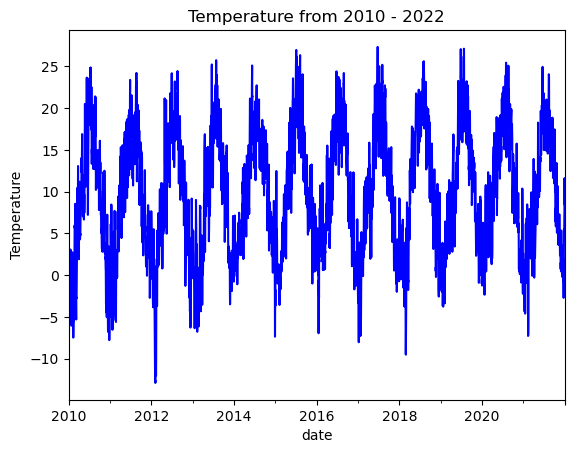

In [16]:
TimeSeries_df['temp'].plot(color='b')
plt.title('Temperature from 2010 - 2022')
plt.xlabel('date')
plt.ylabel('Temperature')

Text(0, 0.5, 'CO2_emit')

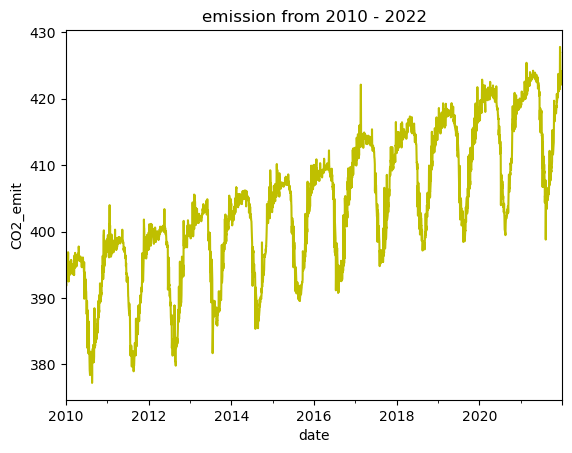

In [17]:
TimeSeries_df['CO2_emit'].plot(color='y')
plt.title('emission from 2010 - 2022')
plt.xlabel('date')
plt.ylabel('CO2_emit')

Text(0, 0.5, 'NO2_emit')

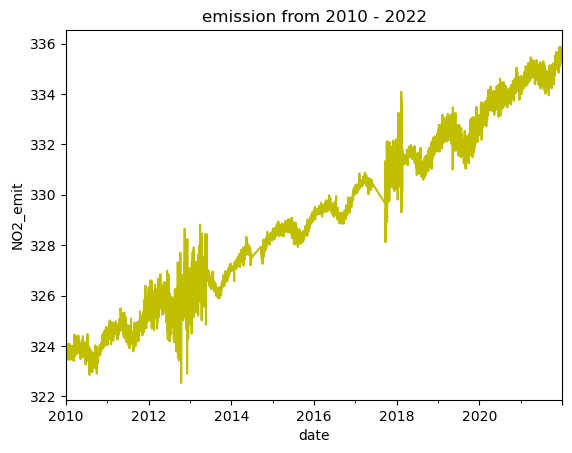

In [18]:
TimeSeries_df['NO2_emit'].plot(color='y')
plt.title('emission from 2010 - 2022')
plt.xlabel('date')
plt.ylabel('NO2_emit')

Text(0, 0.5, 'SF6_emit')

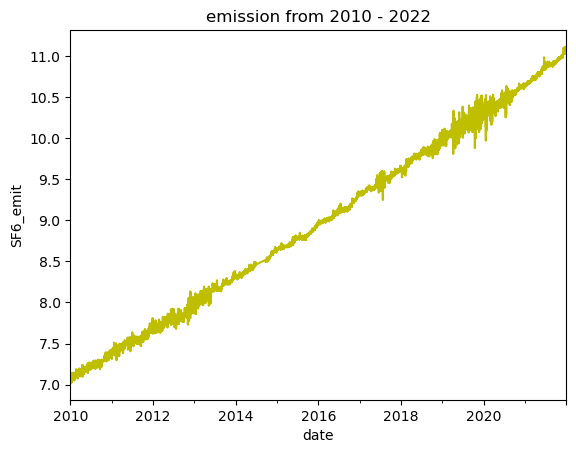

In [19]:
TimeSeries_df['SF6_emit'].plot(color='y')
plt.title('emission from 2010 - 2022')
plt.xlabel('date')
plt.ylabel('SF6_emit')

Text(0, 0.5, 'CH4_emit')

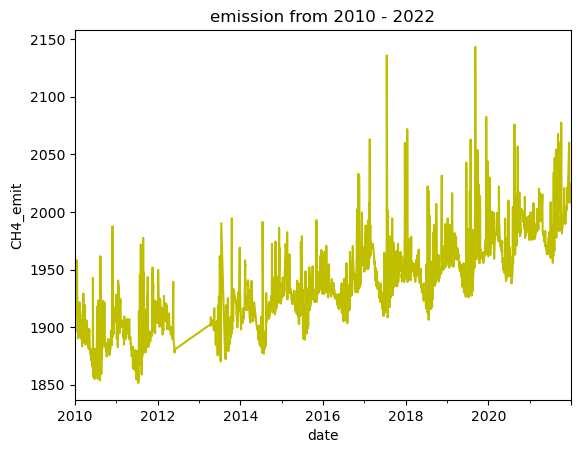

In [20]:
TimeSeries_df['CH4_emit'].plot(color='y')
plt.title('emission from 2010 - 2022')
plt.xlabel('date')
plt.ylabel('CH4_emit')

In [21]:
TimeSeries_df['month'] = TimeSeries_df.index.month

In [22]:
monthly_presentation = TimeSeries_df[['month', 'temp']].copy(deep=True)
monthly_presentation['year'] = monthly_presentation.index.year
monthly_presentation = monthly_presentation.pivot_table(index='month',  columns='year', values='temp')
monthly_presentation.head(2)

year       2010      2011      2012     2013      2014      2015      2016  \
month                                                                        
1     -2.267339  0.317742  1.274194  0.14879  2.498387  1.790323  2.549597   
2      0.238393  1.552679 -4.278879 -2.03125  3.851786 -0.673661  4.183621   

year       2017      2018      2019      2020      2021  
month                                                    
1     -3.045565  4.481048  0.064113  2.201210  0.611694  
2      3.575000 -1.475446  3.104018  6.026724  3.563393

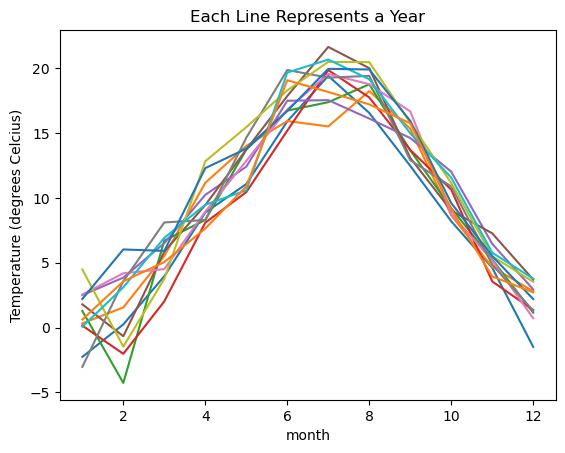

In [23]:
monthly_presentation.plot()
plt.ylabel('Temperature (degrees Celcius)')
plt.title("Each Line Represents a Year")
plt.legend().remove()
plt.show()

based on above graph,
- the temperature value for each day is near of same value of previous year,
- and for more investigation and find better naive base line I will check the one day before to one week before and find the mse for all difference separately and take the minimum of them as base line prediction

In [24]:
TimeSeries_df['temp,-d'] = TimeSeries_df['temp'].diff(1)
TimeSeries_df['temp,-2d'] = TimeSeries_df['temp'].diff(2)
TimeSeries_df['temp,-3d'] = TimeSeries_df['temp'].diff(3)
TimeSeries_df['temp,-4d'] = TimeSeries_df['temp'].diff(4)
TimeSeries_df['temp,-5d'] = TimeSeries_df['temp'].diff(5)
TimeSeries_df['temp,-6d'] = TimeSeries_df['temp'].diff(6)
TimeSeries_df['temp,-w'] = TimeSeries_df['temp'].diff(7)
TimeSeries_df['temp,-y'] = TimeSeries_df['temp'].diff(365)

In [25]:
Timeseries_temp = TimeSeries_df[['temp','temp,-d','temp,-2d','temp,-3d','temp,-4d','temp,-5d',
                                 'temp,-6d','temp,-w','temp,-y']].copy()
Timeseries_temp_name = ['temp','temp,-d','temp,-2d','temp,-3d','temp,-4d','temp,-5d','temp,-6d',
                        'temp,-w','temp,-y']

In [26]:
Timeseries_temp.dropna(inplace=True)

##### find baseline

In [27]:
for i in range(1,len(Timeseries_temp_name)):
    print('The MSE for {0} is equal to: {1}'.format(Timeseries_temp_name[i],
                                                    (Timeseries_temp[Timeseries_temp_name[i]] ** 2).mean()))

The MSE for temp,-d is equal to: 4.521141698295167
The MSE for temp,-2d is equal to: 10.059566326530604
The MSE for temp,-3d is equal to: 13.970928828086093
The MSE for temp,-4d is equal to: 16.50537188122199
The MSE for temp,-5d is equal to: 18.098895128173204
The MSE for temp,-6d is equal to: 19.399638151754637
The MSE for temp,-w is equal to: 20.555683447921908
The MSE for temp,-y is equal to: 24.630170210614743


In [28]:
# 1 year difference has the biggest MSE and in other hand with keep it I lost near one year sample, so I just put it out
Timeseries_temp = TimeSeries_df[['temp','temp,-d','temp,-2d','temp,-3d','temp,-4d','temp,-5d',
                                 'temp,-6d','temp,-w']].copy()
Timeseries_temp_name = ['temp','temp,-d','temp,-2d','temp,-3d','temp,-4d','temp,-5d','temp,-6d',
                        'temp,-w']

In [29]:
Timeseries_temp.dropna(inplace=True)

In [30]:
for i in range(1,len(Timeseries_temp_name)):
    print('The MSE for {0} is equal to: {1}'.format(Timeseries_temp_name[i],
                                                    (Timeseries_temp[Timeseries_temp_name[i]] ** 2).mean()))

The MSE for temp,-d is equal to: 4.525107832495421
The MSE for temp,-2d is equal to: 10.132771223720285
The MSE for temp,-3d is equal to: 14.101316984689195
The MSE for temp,-4d is equal to: 16.695976169732628
The MSE for temp,-5d is equal to: 18.414819148480348
The MSE for temp,-6d is equal to: 19.869782228347816
The MSE for temp,-w is equal to: 21.154210966064934


The minimum MSE is for different with previous day so I take it as baseline, for daily prediction

After This step I follow two different modeling approach,
- Use SARIMA: Not support daily prediction because usage of high memory for 365day cycling
- Use RNN and LSTM: Use for daily and weekly prediction

For daily perdict I want to use RNN and LSTM and I need to know the best possible related day to day I want to predict, So I use the PACF graph to find it out as the first guest

C:\Users\Mehrad Tavanamehr\.conda\envs\c10_final_project\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


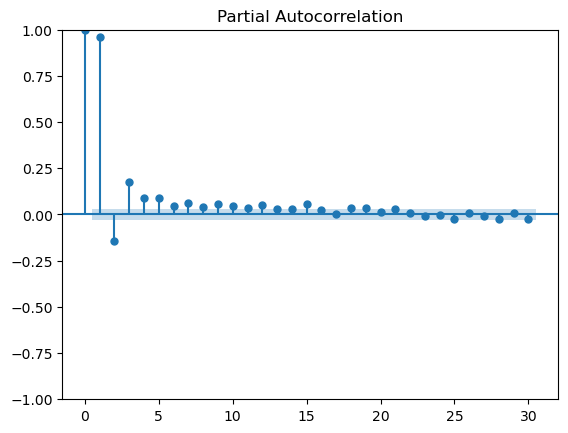

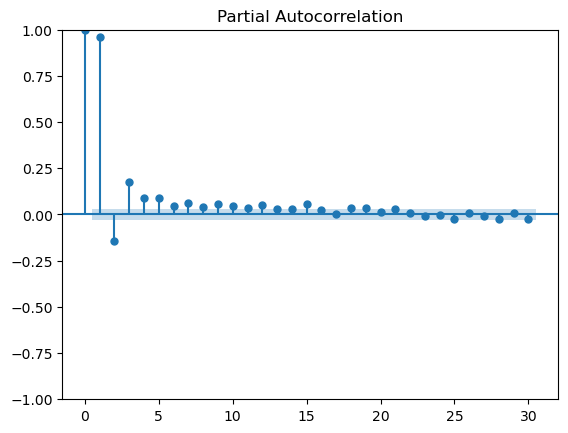

In [31]:
plot_pacf(Timeseries_temp['temp'], lags=30)

In [32]:
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """ 
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

In [33]:
# MSE of test part
def test_MSE(X_test, y_test, model):
    y_predict = model.predict(X_test)
    y_predict = y_predict.reshape(len(y_test),)
    MSE = ((y_predict - y_test) ** 2).mean()
    return 'MSE value {0}'.format(MSE)

In [34]:
# preparation data for feed RNN
def get_keras_format_series(df, train_size_presentage, target_feature, time_steps):
    # make size of train and test
    length_df = df.shape[0]
    features = df.shape[1]
    train_size = int(length_df * train_size_presentage)
    test_size = length_df - train_size
    
    
    # Normalize X_train and X_test
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(df[:train_size + time_steps - 1])
    Input_data = scaler.transform(df)
    
    # create X_train, X_test, y_train ,and y_test
    X_train = np.zeros((train_size, time_steps, features))
    y_train = np.zeros((train_size, 1))
    X_test = np.zeros((test_size, time_steps, features))
    y_test = np.zeros((test_size, 1))
    
    for t in range(train_size):
        X_train[t, :, :] = Input_data[t:t+time_steps]
        y_train[t] = (df[target_feature][t+time_steps])
    
    for i in range(test_size-time_steps):
        t = i + train_size
        X_test[i, :, :] = Input_data[t:t+time_steps]
        y_test[i] = (df[target_feature][t+time_steps])
    
    return X_train, X_test, y_train, y_test, scaler

In [35]:
def predict_and_plot(X_init, y, model, title):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series,
    and plots these predictions against the ground truth for those steps 
    
    arguments
    ---------
    X_init (array): initial sequence, must match model's input shape
    y (array): true sequence values to predict, follow X_init
    model (keras.models.Sequential): trained neural network
    title (string): plot title   
    """
    
    y_preds = predict(test_X_init, n_steps=len(y), model=model) # predict through length of y
    # Below ranges are to set x-axes
    start_range = range(1, test_X_init.shape[0]+1) #starting at one through to length of test_X_init to plot X_init
    predict_range = range(test_X_init.shape[0], test_hours)  #predict range is going to be from end of X_init to length of test_hours
    
    #using our ranges we plot X_init
    plt.plot(start_range, test_X_init)
    #and test and actual preds
    plt.plot(predict_range, test_y, color='orange')
    plt.plot(predict_range, y_preds, color='teal', linestyle='--')
    
    plt.title(title)
    plt.legend(['Initial Series','Target Series','Predictions'])

In [36]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, SimpleRNN, LSTM
from tensorflow.keras.activations import relu, elu, selu
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, MeanSquaredLogarithmicError
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError, LogCoshError
import tensorflow as tf
tf.keras.backend.set_floatx('float64')
import math
from IPython.display import clear_output

In [37]:
from livelossplot import PlotLossesKeras

In [38]:
class TrainingPlot(tf.keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and metrics
        self.losses = []
        self.val_losses = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        """
        Calculates and plots Precision, Recall, F1 score
        """
        # Extract from the log
        loss = logs.get('loss')
        val_loss = logs.get('val_loss')
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(loss)
        self.val_losses.append(val_loss)
        
        # Plots every 25th epoch
        if epoch > 0 and epoch%10==0:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure(figsize=(10,3))
            plt.title("Loss over epoch")
            plt.plot(N, self.losses, 'm')
            plt.plot(N, self.val_losses, 'r--')
            
            plt.show()

In [39]:
def call_back(file_path, freq, int_value, patience, batch_size=[32, 64], mode=['auto','min','max'], 
              monitor=['val_loss','loss']):
    import tensorflow as tf
    check_point = tf.keras.callbacks.ModelCheckpoint(filepath=file_path, monitor=monitor, verbose=0,
                                                     save_best_only=True, mode=mode, save_freq = batch_size*freq,
                                                    initial_value_threshold = int_value)
    live_plot = TrainingPlot()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=1)
    return [check_point, live_plot, early_stopping]
    

##### Data is ready to feed the RNN
Here I will use two different RNN structures,
- Simple RNN
- LSTM

In [40]:
def compile_fit(model, X_train, y_train, epochs, batch_size, loss, optimizer, metrics, call_back, val_split, verbose=0):
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=val_split,
                        callbacks=call_back)
    return history

In [41]:
def load_model(filepath):
    from tensorflow.keras.models import load_model
    return load_model(filepath)

In [42]:
def check_output(model, history, X_test, y_test, model_name):
    # output of MSE value
    print(test_MSE(X_test,y_test,model))
    
    # check the history graph of loss and val_loss
    plot_loss_curves(history)
    plt.show()
    
    # make predict graph to see the model in action
    y_preds = model.predict(X_test)
    plt.plot(y_test, color='orange')
    plt.plot(y_preds, color='teal', linestyle='--')

    plt.title('model {0}'.format(model_name))
    plt.show()
    
    print(model.summary())

#### Initial default
- Model of MISO and use difference between 1day to 7days as input
- take the 15 as time-step to feed network

In [59]:
X_train, X_test, y_train, y_test, scaler = get_keras_format_series(df=Timeseries_temp, train_size_presentage = 0.75,
                                                                   target_feature='temp', time_steps=15)
print('Training input shape: {}'.format(X_train.shape))
print('Training output shape: {}'.format(y_train.shape))
print('Test input shape: {}'.format(X_test.shape))
print('Test output shape: {}'.format(y_test.shape))

Training input shape: (3282, 15, 8)
Training output shape: (3282, 1)
Test input shape: (1094, 15, 8)
Test output shape: (1094, 1)


In [61]:
Timeseries_temp

temp  temp,-d  temp,-2d  temp,-3d  temp,-4d  temp,-5d  \
datetime                                                               
2010-01-08  -2.8875   0.5875    1.2000    3.0625    3.9125    2.9125   
2010-01-09  -4.3250  -1.4375   -0.8500   -0.2375    1.6250    2.4750   
2010-01-10  -4.6625  -0.3375   -1.7750   -1.1875   -0.5750    1.2875   
2010-01-11  -4.3250   0.3375    0.0000   -1.4375   -0.8500   -0.2375   
2010-01-12  -3.3750   0.9500    1.2875    0.9500   -0.4875    0.1000   
...             ...      ...       ...       ...       ...       ...   
2021-12-27   5.3750   0.2250   -0.0625    0.1125    5.6875    8.1000   
2021-12-28   6.9125   1.5375    1.7625    1.4750    1.6500    7.2250   
2021-12-29   7.5750   0.6625    2.2000    2.4250    2.1375    2.3125   
2021-12-30  11.6125   4.0375    4.7000    6.2375    6.4625    6.1750   
2021-12-31   8.5000  -3.1125    0.9250    1.5875    3.1250    3.3500   

            temp,-6d  temp,-w  
datetime                       
2010-01-08    0.1125  -5.2375  
2010-01-09    1.4750  -1.3250  
2010-01-10    2.1375   1.1375  
2010-01-11    1.6250   2.4750  
2010-01-12    0.7125   2.5750  
...              ...      ...  
2021-12-27    7.3625   5.6500  
2021-12-28    9.6375   8.9000  
2021-12-29    7.8875  10.3000  
2021-12-30    6.3500  11.9250  
2021-12-31    3.0625   3.2375  

[4376 rows x 8 columns]

In [40]:
def def_model(X_train, cell_units, time_steps, features):
    '''
    X_train (array): input sequence samples for training 
    cell_units (int): number of hidden units for RNN cells  
    '''
    model = Sequential()
    model.add(SimpleRNN(cell_units, input_shape=(time_steps,features)))
    model.add(Dense(1))
    
    return model

C:\Users\Mehrad Tavanamehr\AppData\Local\Temp\ipykernel_15316\3357694502.py:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


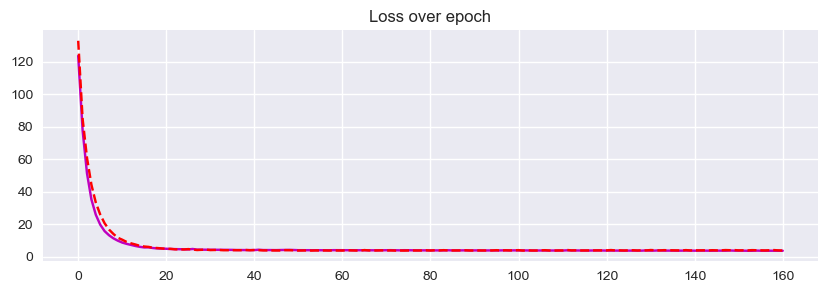

Epoch 00164: early stopping


In [45]:
call_back = call_back('./checkpoint/simplernn_01', 5, 4, 10, 64, 'min', 'loss')

model_simple_RNN = def_model(X_train, 32, 15, 8)

history_simple_RNN = compile_fit(model_simple_RNN, X_train, y_train, 200, 64, 'mean_squared_error', Adam(), [RootMeanSquaredError()],
                     call_back, 0.1)

MSE value 95.67084727353169


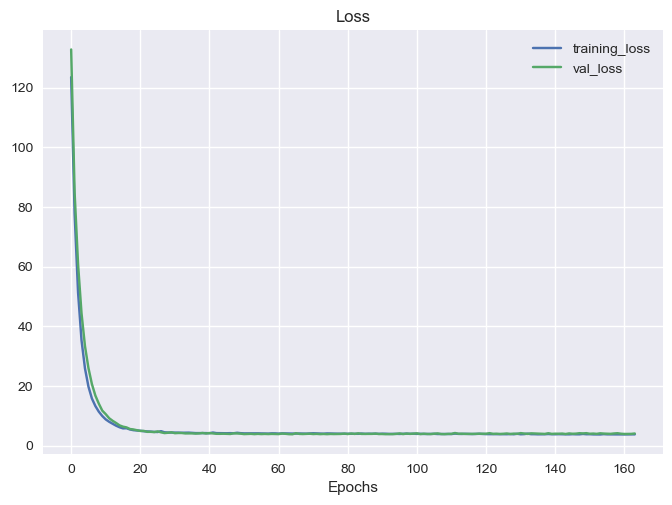

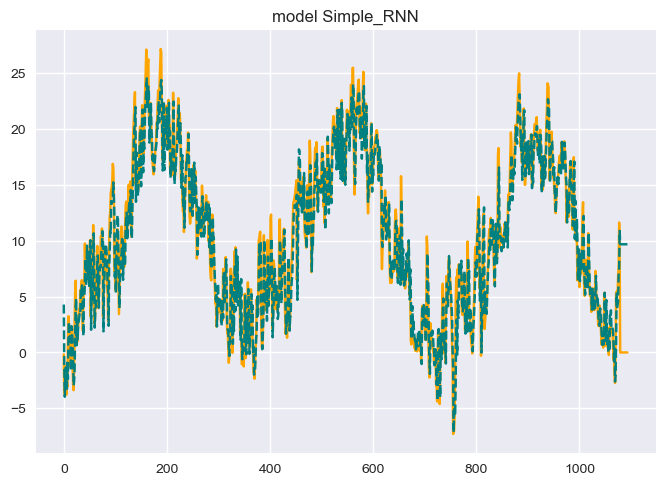

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 32)                1312      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,345
Trainable params: 1,345
Non-trainable params: 0
_________________________________________________________________
None


In [46]:
check_output(model_simple_RNN, history_simple_RNN, X_test,y_test, 'Simple_RNN')

In [47]:
# I need to run it after each time usage
def call_back(file_path, freq, int_value, patience, batch_size=[32, 64], mode=['auto','min','max'], 
              monitor=['val_loss','loss']):
    import tensorflow as tf
    check_point = tf.keras.callbacks.ModelCheckpoint(filepath=file_path, monitor=monitor, verbose=0,
                                                     save_best_only=False, mode=mode, save_freq = batch_size*freq,
                                                    initial_value_threshold = int_value)
    live_plot = TrainingPlot()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=1)
    return [check_point, live_plot, early_stopping]
    

In [48]:
def def_model(X_train, cell_units, time_steps, features):
    '''
    X_train (array): input sequence samples for training 
    cell_units (int): number of hidden units for RNN cells  
    '''
    model = Sequential()
    model.add(LSTM(cell_units, input_shape=(time_steps,features)))
    model.add(Dense(1))
    
    return model

C:\Users\Mehrad Tavanamehr\AppData\Local\Temp\ipykernel_15316\3357694502.py:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


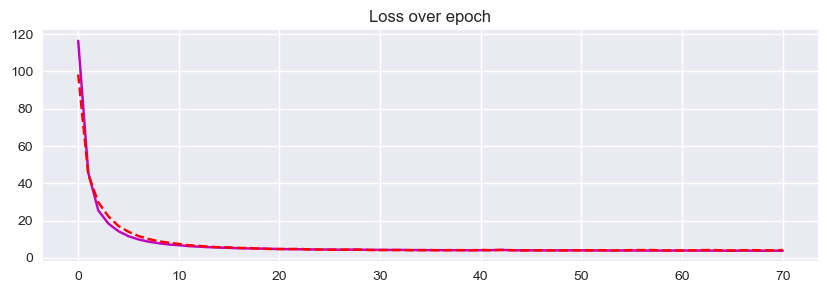

Epoch 00071: early stopping


In [49]:
call_back = call_back('./checkpoint/check3', 5, 10, 10, 64, 'min', 'val_loss')

model_Simple_LSTM = def_model(X_train, 32, 15, 8)

history_Simple_LSTM = compile_fit(model_Simple_LSTM, X_train, y_train, 200, 64, 'mean_squared_error', Adam(), [RootMeanSquaredError()],
                     call_back, 0.1)

MSE value 97.06030013417444


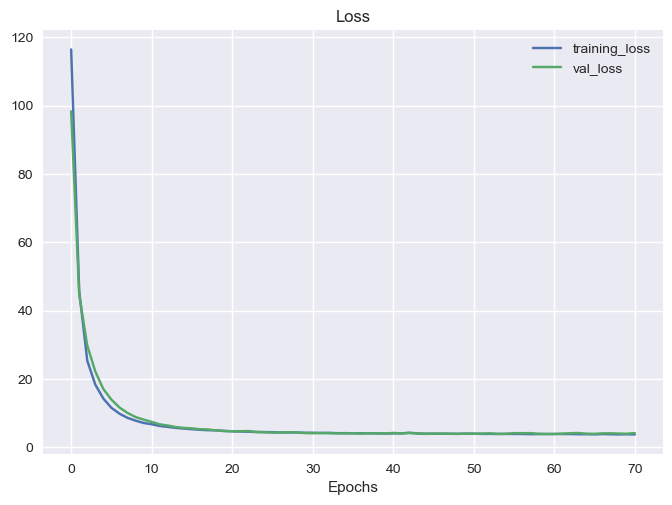

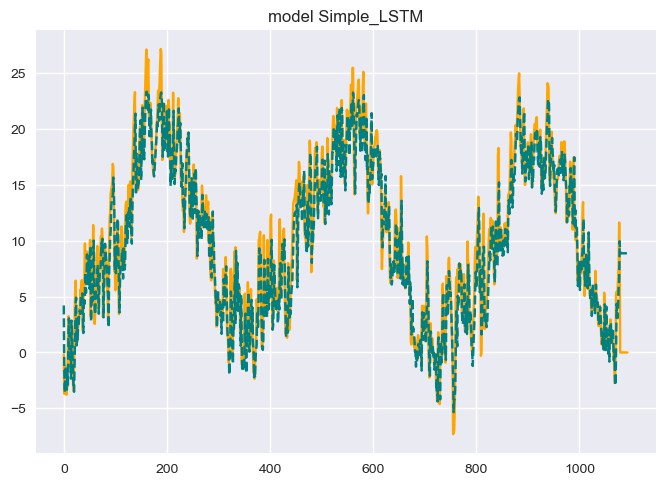

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                5248      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
_________________________________________________________________
None


In [50]:
check_output(model_Simple_LSTM, history_Simple_LSTM, X_test,y_test, 'Simple_LSTM')

Based on above learning Simple RNN and LSTM:
- LSTM learn faster with little MSE value
- Simple RNN is better in edges and needs less parameters to learn

I will continue with Simple RNN and make more complicated models to catch better output

In [51]:
# I need to run it after each time usage
def call_back(file_path, freq, int_value, patience, batch_size=[32, 64], mode=['auto','min','max'], 
              monitor=['val_loss','loss']):
    import tensorflow as tf
    check_point = tf.keras.callbacks.ModelCheckpoint(filepath=file_path, monitor=monitor, verbose=0,
                                                     save_best_only=False, mode=mode, save_freq = batch_size*freq,
                                                    initial_value_threshold = int_value)
    live_plot = TrainingPlot()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=1)
    return [check_point, live_plot, early_stopping]
    

In [52]:
def def_model(X_train, cell_units, time_steps, features):
    '''
    X_train (array): input sequence samples for training 
    cell_units (int): number of hidden units for RNN cells  
    '''
    model = Sequential()
    model.add(SimpleRNN(cell_units, input_shape=(time_steps,features)))
    model.add(Dense(8, activation=relu)) # add dense value same as features and add activation to make it non-linear
    model.add(Dense(1)) # Should not use relu because affect and destroy minus output values
    
    return model

C:\Users\Mehrad Tavanamehr\AppData\Local\Temp\ipykernel_15316\3357694502.py:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


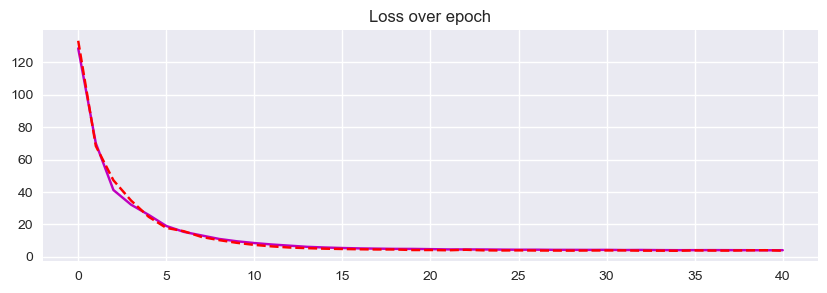

Epoch 00045: early stopping


In [53]:
call_back = call_back('./checkpoint/check_RNN_01', 5, 10, 10, 64, 'min', 'val_loss')

model_RNN_01 = def_model(X_train, 32, 15, 8)

history_RNN_01 = compile_fit(model_RNN_01, X_train, y_train, 200, 64, 'mean_squared_error', Adam(), [RootMeanSquaredError()],
                     call_back, 0.1)

MSE value 99.72937674300522


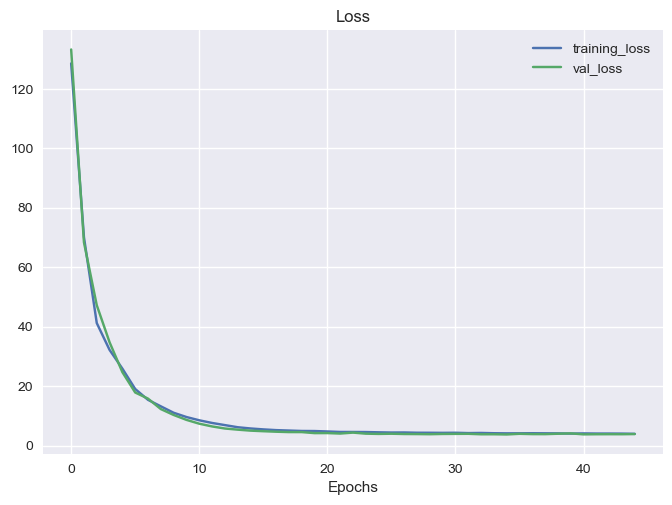

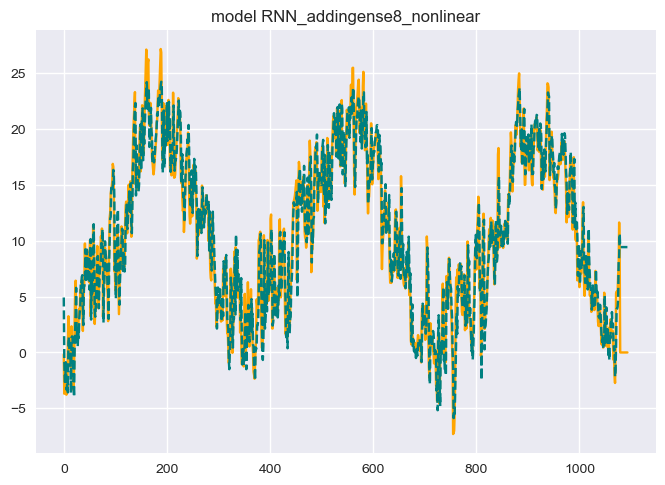

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 32)                1312      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 1,585
Trainable params: 1,585
Non-trainable params: 0
_________________________________________________________________
None


In [54]:
check_output(model_RNN_01, history_RNN_01, X_test, y_test, 'RNN_addingense8_nonlinear')

maybe changing optimizer with same architecture work better, so I load the last learned parameter values and continue learning

In [55]:
RNN01_load = load_model('./checkpoint/check_RNN_01')

C:\Users\Mehrad Tavanamehr\AppData\Local\Temp\ipykernel_15316\3357694502.py:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


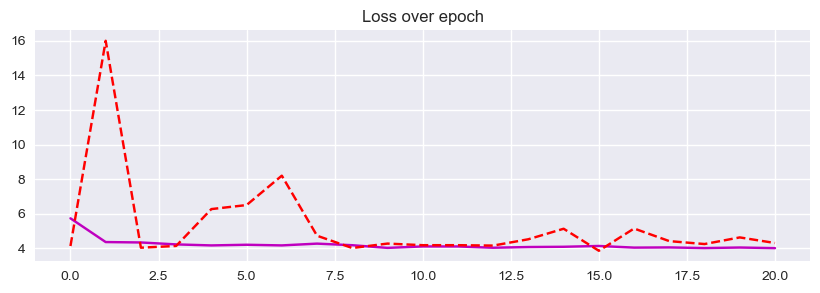

INFO:tensorflow:Assets written to: ./checkpoint\check_RNN_01\assets
Epoch 00026: early stopping


In [56]:
history_RNN_01 = compile_fit(model_RNN_01, X_train, y_train, 200, 64, 'mean_squared_error', SGD(learning_rate=0.001), 
                             [RootMeanSquaredError()], call_back, 0.1)

MSE value 99.89269259483265


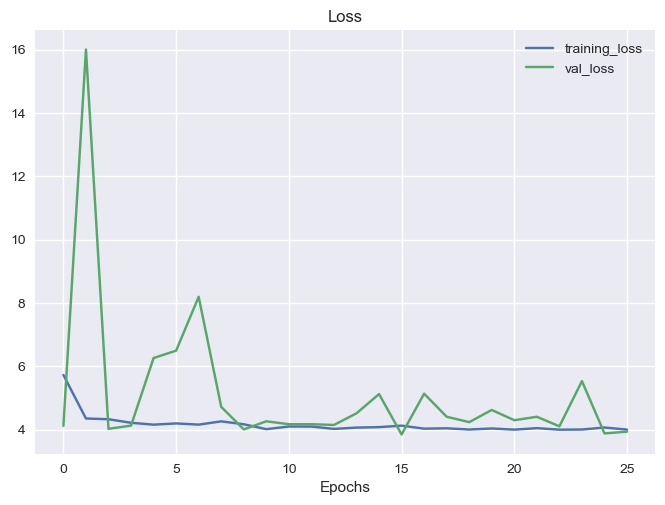

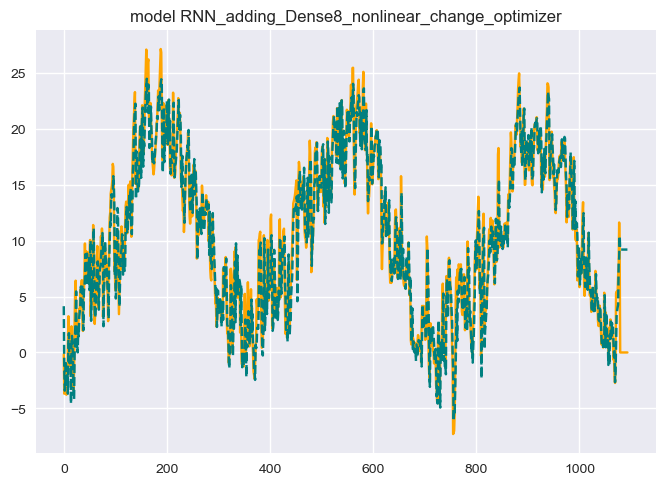

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 32)                1312      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 1,585
Trainable params: 1,585
Non-trainable params: 0
_________________________________________________________________
None


In [57]:
check_output(model_RNN_01, history_RNN_01, X_test, y_test, 'RNN_adding_Dense8_nonlinear_change_optimizer')

#### Conclusion

The best value of MSE is still high but the model is good about edges and sudden change, for more investigation I want to change the time_step from 15 to 30 to see the affection



In [58]:
X_train, X_test, y_train, y_test, scaler = get_keras_format_series(df=Timeseries_temp, train_size_presentage = 0.75,
                                                                   target_feature='temp', time_steps=30)
print('Training input shape: {}'.format(X_train.shape))
print('Training output shape: {}'.format(y_train.shape))
print('Test input shape: {}'.format(X_test.shape))
print('Test output shape: {}'.format(y_test.shape))

Training input shape: (3282, 30, 8)
Training output shape: (3282, 1)
Test input shape: (1094, 30, 8)
Test output shape: (1094, 1)


In [59]:
# I need to run it after each time usage
def call_back(file_path, freq, int_value, patience, batch_size=[32, 64], mode=['auto','min','max'], 
              monitor=['val_loss','loss']):
    import tensorflow as tf
    check_point = tf.keras.callbacks.ModelCheckpoint(filepath=file_path, monitor=monitor, verbose=0,
                                                     save_best_only=False, mode=mode, save_freq = batch_size*freq,
                                                    initial_value_threshold = int_value)
    live_plot = TrainingPlot()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=1)
    return [check_point, live_plot, early_stopping]
    

C:\Users\Mehrad Tavanamehr\AppData\Local\Temp\ipykernel_15316\3357694502.py:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


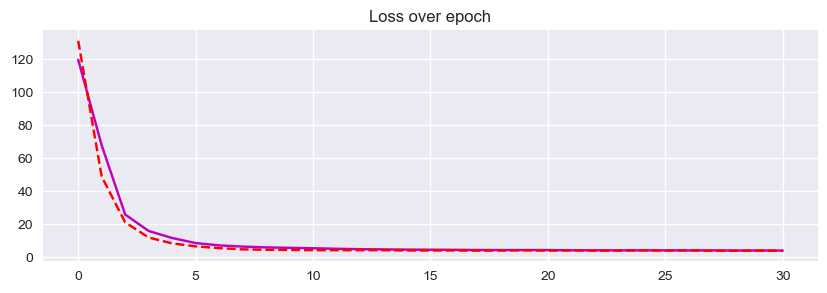

INFO:tensorflow:Assets written to: ./checkpoint\check_RNN_02\assets
Epoch 00038: early stopping


In [60]:
# the best model from previous experience
call_back = call_back(file_path= './checkpoint/check_RNN_02', freq= 5, int_value= 10, patience= 10, batch_size= 64,
                      mode= 'min', monitor= 'val_loss')

model_RNN_02 = def_model(X_train, cell_units= 32, time_steps= 30, features= 8)

history_RNN_02 = compile_fit(model_RNN_02, X_train, y_train, 200, 64, 'mean_squared_error', Adam(), [RootMeanSquaredError()],
                             call_back, 0.1)

MSE value 92.45800455408637


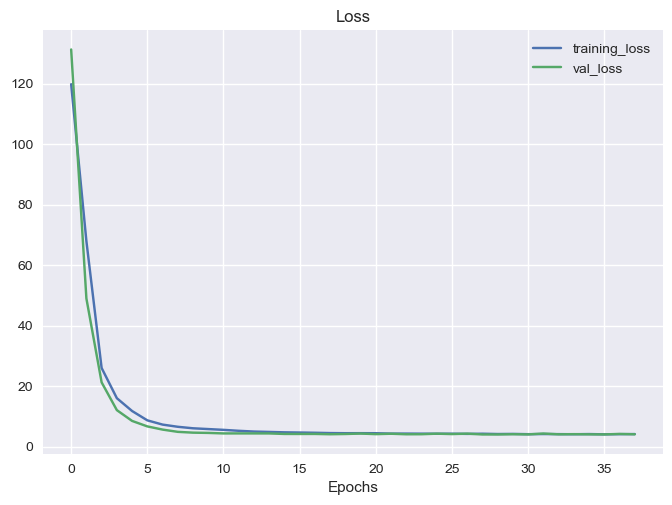

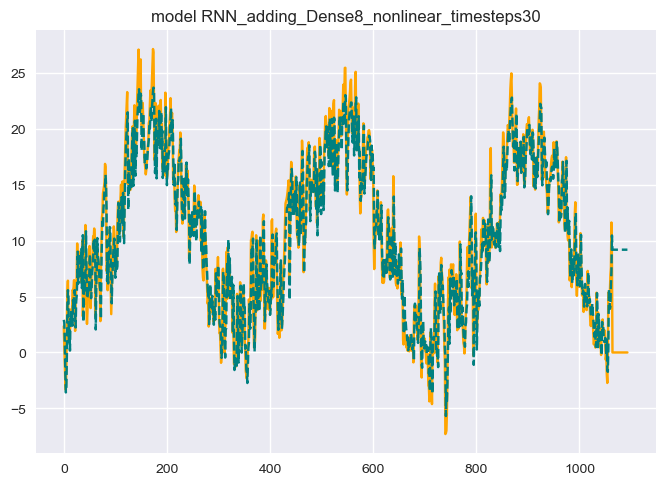

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 32)                1312      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 1,585
Trainable params: 1,585
Non-trainable params: 0
_________________________________________________________________
None


In [61]:
check_output(model_RNN_02, history_RNN_02, X_test, y_test, 'RNN_adding_Dense8_nonlinear_timesteps30')

give more chance to learn

In [62]:
# I need to run it after each time usage
def call_back(file_path, freq, int_value, patience, batch_size=[32, 64], mode=['auto','min','max'], 
              monitor=['val_loss','loss']):
    import tensorflow as tf
    check_point = tf.keras.callbacks.ModelCheckpoint(filepath=file_path, monitor=monitor, verbose=0,
                                                     save_best_only=False, mode=mode, save_freq = batch_size*freq,
                                                    initial_value_threshold = int_value)
    live_plot = TrainingPlot()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=1)
    return [check_point, live_plot, early_stopping]
    

C:\Users\Mehrad Tavanamehr\AppData\Local\Temp\ipykernel_15316\3357694502.py:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


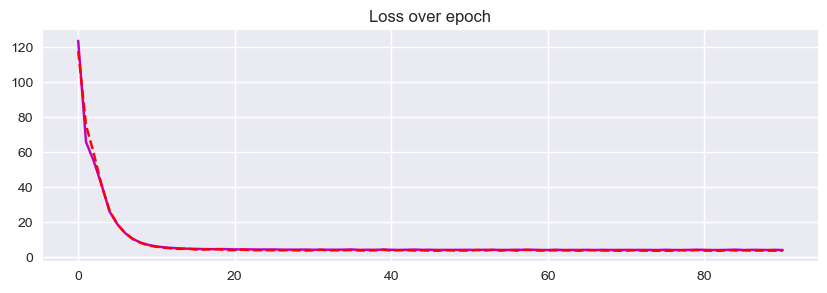

Epoch 00095: early stopping


In [63]:
# the best model from previous experience
call_back = call_back(file_path= './checkpoint/check_RNN_03', freq= 5, int_value= 10, patience= 20, batch_size= 64,
                      mode= 'min', monitor= 'val_loss')

model_RNN_03 = def_model(X_train, cell_units= 64, time_steps= 30, features= 8)

history_RNN_03 = compile_fit(model_RNN_03, X_train, y_train, 200, 64, 'mean_squared_error', Adam(), [RootMeanSquaredError()],
                             call_back, 0.1)

MSE value 91.58425181293106


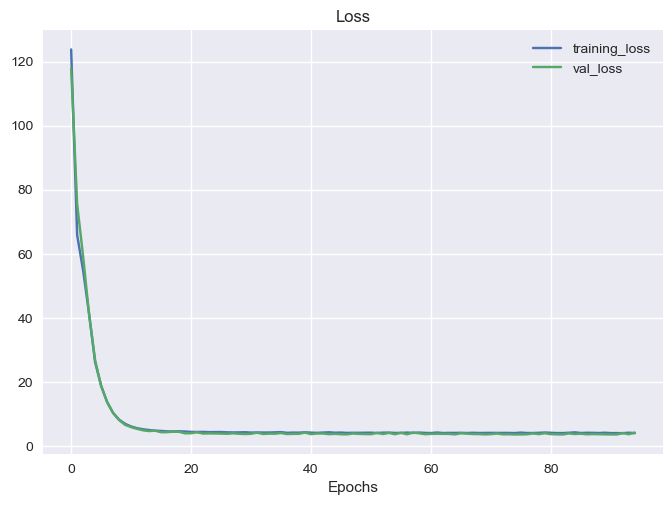

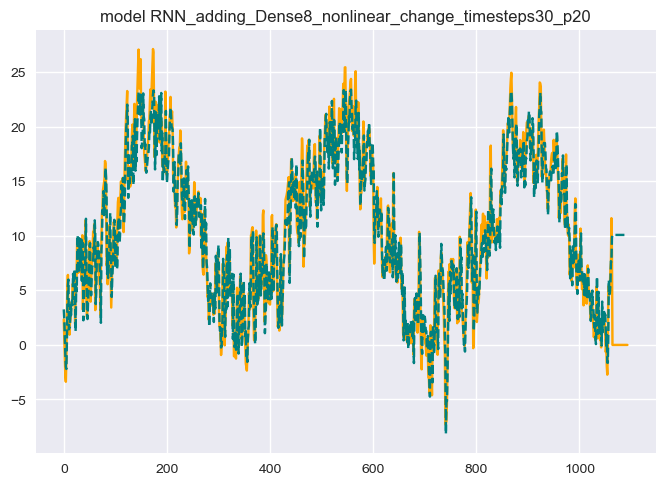

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 64)                4672      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 5,201
Trainable params: 5,201
Non-trainable params: 0
_________________________________________________________________
None


In [64]:
check_output(model_RNN_03, history_RNN_03, X_test, y_test, 'RNN_adding_Dense8_nonlinear_change_timesteps30_p20')

In [69]:
# I need to run it after each time usage
def call_back(file_path, freq, int_value, patience, batch_size=[32, 64], mode=['auto','min','max'], 
              monitor=['val_loss','loss']):
    import tensorflow as tf
    check_point = tf.keras.callbacks.ModelCheckpoint(filepath=file_path, monitor=monitor, verbose=0,
                                                     save_best_only=False, mode=mode, save_freq = batch_size*freq,
                                                    initial_value_threshold = int_value)
    live_plot = TrainingPlot()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=1)
    return [check_point, live_plot, early_stopping]

In [70]:
def def_model(X_train, cell_units, time_steps, features):
    '''
    X_train (array): input sequence samples for training 
    cell_units (int): number of hidden units for RNN cells  
    '''
    model = Sequential()
    model.add(LSTM(cell_units, input_shape=(time_steps,features)))
    model.add(Dense(8, activation=relu))
    model.add(Dense(1))
    
    return model

C:\Users\Mehrad Tavanamehr\AppData\Local\Temp\ipykernel_15316\3357694502.py:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


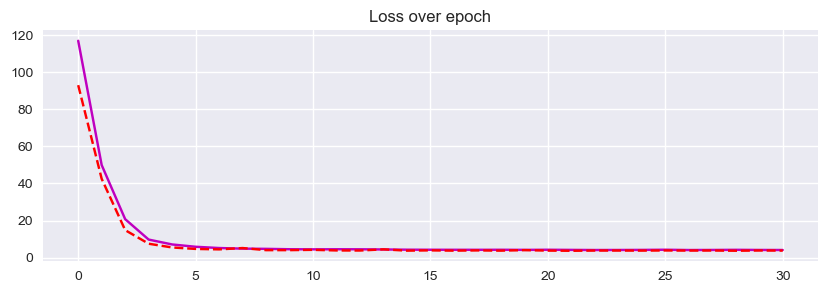

Epoch 00032: early stopping


In [71]:
# the best model from previous experience
call_back = call_back(file_path= './checkpoint/check_LSTM_nonlinear', freq= 5, int_value= 10, patience= 10, batch_size= 64,
                      mode= 'min', monitor= 'val_loss')3


model_LSTM_nonlinear = def_model(X_train, cell_units= 64, time_steps= 30, features= 8)

history_LSTM_nonlinear = compile_fit(model_LSTM_nonlinear, X_train, y_train, 200, 64, 'mean_squared_error', Adam(learning_rate=0.001),
                              [RootMeanSquaredError()], call_back, 0.1)

MSE value 98.18047576057126


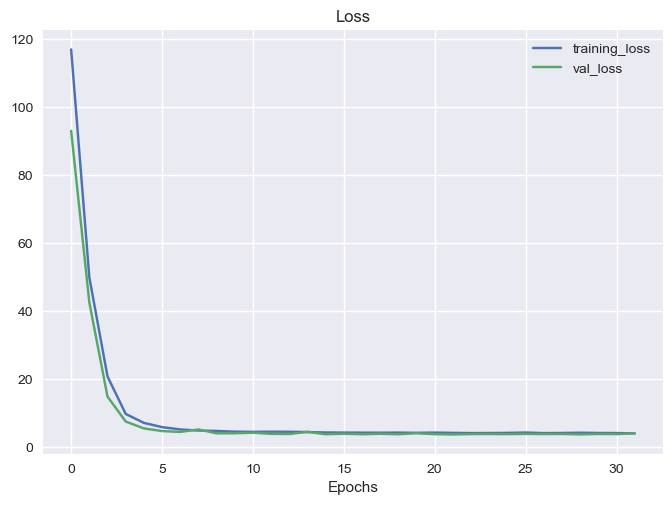

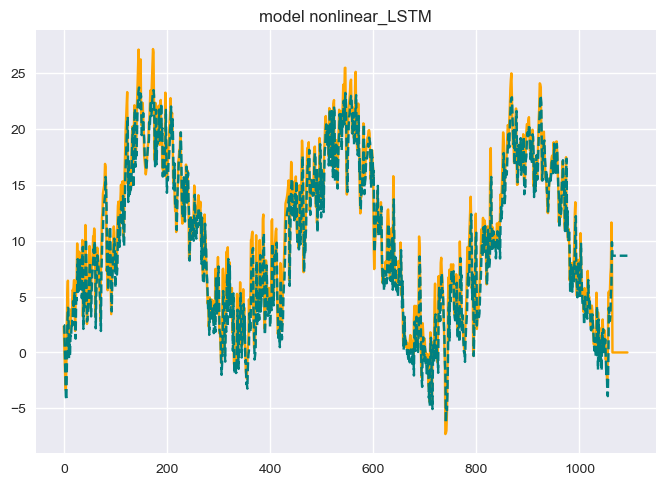

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                18688     
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 19,217
Trainable params: 19,217
Non-trainable params: 0
_________________________________________________________________
None


In [72]:
check_output(model_LSTM_nonlinear, history_LSTM_nonlinear, X_test,y_test, 'nonlinear_LSTM')

#### Conclusion
It does not improve so I keep the timesteps in 15. Till now, I worked on an idea of using daily difference of temperature between 1 day to 7 days can improve the model. for more investigation on this idea, I need to learn model for
- just temperature
- shift temperature data for 1 to 7 days

## shift data

In [98]:
ShiftSeries_df = pd.DataFrame()
ShiftSeries_df['temp'] = Timeseries_temp['temp'].copy()
ShiftSeries_df['temp,-d'] = ShiftSeries_df['temp'].shift(1)
ShiftSeries_df['temp,-2d'] = ShiftSeries_df['temp'].shift(2)
ShiftSeries_df['temp,-3d'] = ShiftSeries_df['temp'].shift(3)
ShiftSeries_df['temp,-4d'] = ShiftSeries_df['temp'].shift(4)
ShiftSeries_df['temp,-5d'] = ShiftSeries_df['temp'].shift(5)
ShiftSeries_df['temp,-6d'] = ShiftSeries_df['temp'].shift(6)
ShiftSeries_df['temp,-w'] = ShiftSeries_df['temp'].shift(7)

In [99]:
ShiftSeries_df.dropna(inplace=True)

In [100]:
ShiftSeries_df

temp  temp,-d  temp,-2d  temp,-3d  temp,-4d  temp,-5d  \
datetime                                                               
2010-01-15  -0.1375   0.2875   -2.0500   -3.3750   -4.3250   -4.6625   
2010-01-16  -1.6250  -0.1375    0.2875   -2.0500   -3.3750   -4.3250   
2010-01-17   3.0625  -1.6250   -0.1375    0.2875   -2.0500   -3.3750   
2010-01-18   1.8125   3.0625   -1.6250   -0.1375    0.2875   -2.0500   
2010-01-19  -0.9500   1.8125    3.0625   -1.6250   -0.1375    0.2875   
...             ...      ...       ...       ...       ...       ...   
2021-12-27   5.3750   5.1500    5.4375    5.2625   -0.3125   -2.7250   
2021-12-28   6.9125   5.3750    5.1500    5.4375    5.2625   -0.3125   
2021-12-29   7.5750   6.9125    5.3750    5.1500    5.4375    5.2625   
2021-12-30  11.6125   7.5750    6.9125    5.3750    5.1500    5.4375   
2021-12-31   8.5000  11.6125    7.5750    6.9125    5.3750    5.1500   

            temp,-6d  temp,-w  
datetime                       
2010-01-15   -4.3250  -2.8875  
2010-01-16   -4.6625  -4.3250  
2010-01-17   -4.3250  -4.6625  
2010-01-18   -3.3750  -4.3250  
2010-01-19   -2.0500  -3.3750  
...              ...      ...  
2021-12-27   -1.9875  -0.2750  
2021-12-28   -2.7250  -1.9875  
2021-12-29   -0.3125  -2.7250  
2021-12-30    5.2625  -0.3125  
2021-12-31    5.4375   5.2625  

[4369 rows x 8 columns]

In [101]:
X_train, X_test, y_train, y_test, scaler = get_keras_format_series(df=ShiftSeries_df, train_size_presentage = 0.75,
                                                                   target_feature='temp', time_steps=15)
print('Training input shape: {}'.format(X_train.shape))
print('Training output shape: {}'.format(y_train.shape))
print('Test input shape: {}'.format(X_test.shape))
print('Test output shape: {}'.format(y_test.shape))

Training input shape: (3276, 15, 8)
Training output shape: (3276, 1)
Test input shape: (1093, 15, 8)
Test output shape: (1093, 1)


In [105]:
# I need to run it after each time usage
def call_back(file_path, freq, int_value, patience, batch_size=[32, 64], mode=['auto','min','max'], 
              monitor=['val_loss','loss']):
    import tensorflow as tf
    check_point = tf.keras.callbacks.ModelCheckpoint(filepath=file_path, monitor=monitor, verbose=0,
                                                     save_best_only=False, mode=mode, save_freq = batch_size*freq,
                                                    initial_value_threshold = int_value)
    live_plot = TrainingPlot()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=1)
    return [check_point, live_plot, early_stopping]
    

In [106]:
def def_model(X_train, cell_units, time_steps, features):
    '''
    X_train (array): input sequence samples for training 
    cell_units (int): number of hidden units for RNN cells  
    '''
    model = Sequential()
    model.add(SimpleRNN(cell_units, input_shape=(time_steps,features)))
    model.add(Dense(8, activation=relu)) # add dense value same as features and add activation to make in non-linear
    model.add(Dense(1)) # Should not use relu because affect and destroy minus output values
    
    return model

C:\Users\Mehrad Tavanamehr\AppData\Local\Temp\ipykernel_15316\3357694502.py:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


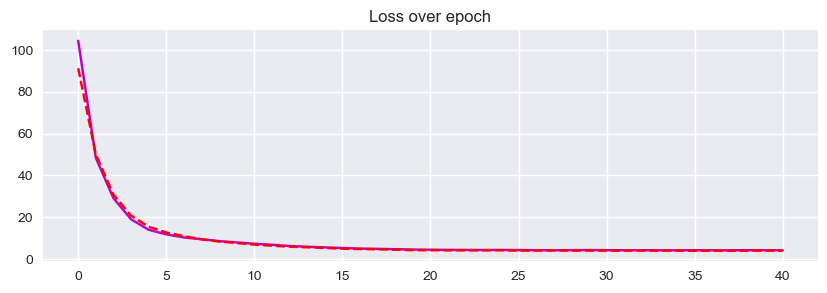

Epoch 00046: early stopping


In [107]:
# the best model from previous experience
call_back = call_back(file_path= './checkpoint/check_shift_RNN_01', freq= 5, int_value= 10, patience= 10, batch_size= 64,
                      mode= 'min', monitor= 'val_loss')

model_shift_RNN_01 = def_model(X_train, cell_units= 64, time_steps= 15, features= 8)

history_shift_RNN_01 = compile_fit(model_shift_RNN_01, X_train, y_train, 200, batch_size= 64, loss='mean_squared_error',
                                   optimizer= Adam(), metrics= [RootMeanSquaredError()], call_back= call_back, val_split= 0.1)

MSE value 93.93783681340197


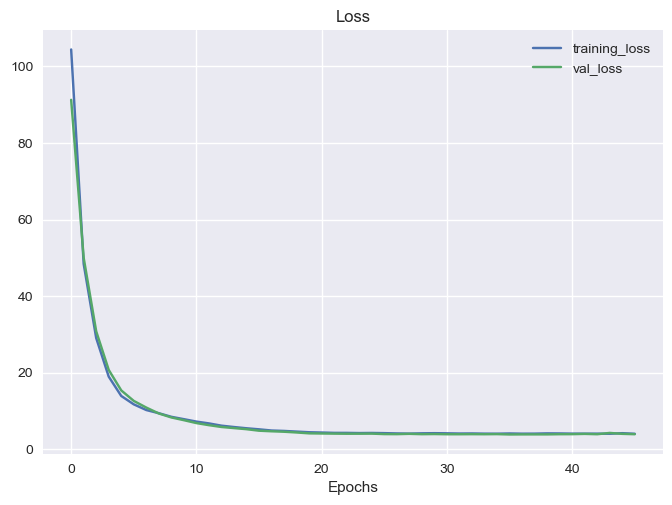

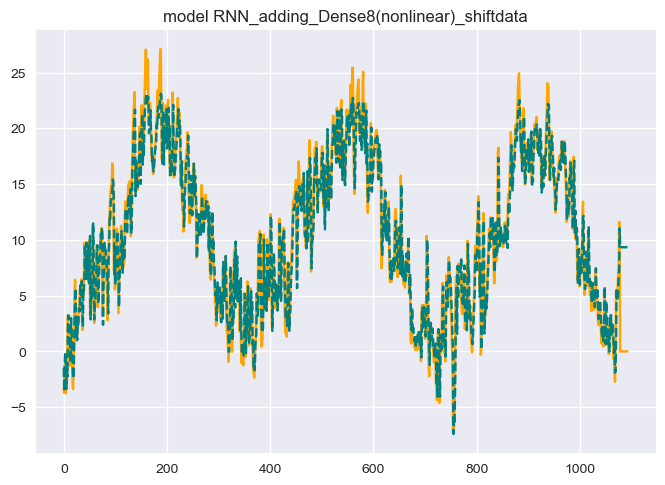

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_7 (SimpleRNN)     (None, 64)                4672      
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 9         
Total params: 5,201
Trainable params: 5,201
Non-trainable params: 0
_________________________________________________________________
None


In [108]:
check_output(model_shift_RNN_01, history_shift_RNN_01, X_test, y_test, 'RNN_adding_Dense8(nonlinear)_shiftdata')

In [109]:
# I need to run it after each time usage
def call_back(file_path, freq, int_value, patience, batch_size=[32, 64], mode=['auto','min','max'], 
              monitor=['val_loss','loss']):
    import tensorflow as tf
    check_point = tf.keras.callbacks.ModelCheckpoint(filepath=file_path, monitor=monitor, verbose=0,
                                                     save_best_only=False, mode=mode, save_freq = batch_size*freq,
                                                    initial_value_threshold = int_value)
    live_plot = TrainingPlot()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=1)
    return [check_point, live_plot, early_stopping]
    

In [110]:
def def_model(X_train, cell_units, time_steps, features):
    '''
    X_train (array): input sequence samples for training 
    cell_units (int): number of hidden units for RNN cells  
    '''
    model = Sequential()
    model.add(LSTM(cell_units, input_shape=(time_steps,features)))
    model.add(Dense(8, activation=relu)) # add dense value same as features and add activation to make in non-linear
    model.add(Dense(1)) # Should not use relu because affect and destroy minus output values
    
    return model

C:\Users\Mehrad Tavanamehr\AppData\Local\Temp\ipykernel_15316\3357694502.py:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


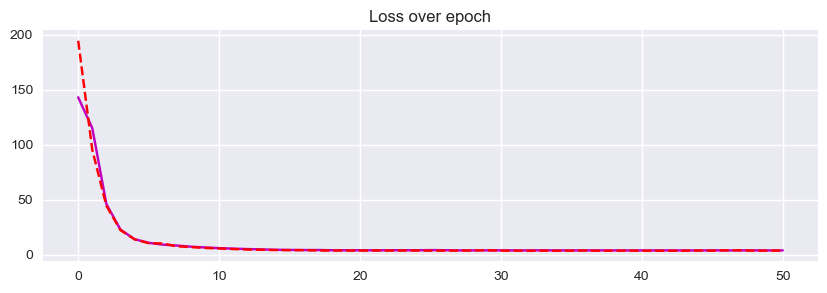

Epoch 00051: early stopping


In [111]:
# the best model from previous experience
call_back = call_back(file_path= './checkpoint/check_shift_LSTM_01', freq= 5, int_value= 10, patience= 10, batch_size= 64,
                      mode= 'min', monitor= 'val_loss')

model_shift_LSTM_01 = def_model(X_train, cell_units= 64, time_steps= 15, features= 8)

history_shift_LSTM_01 = compile_fit(model_shift_LSTM_01, X_train, y_train, 200, batch_size= 64, loss='mean_squared_error',
                                   optimizer= Adam(), metrics= [RootMeanSquaredError()], call_back= call_back, val_split= 0.1)

MSE value 98.87170355827908


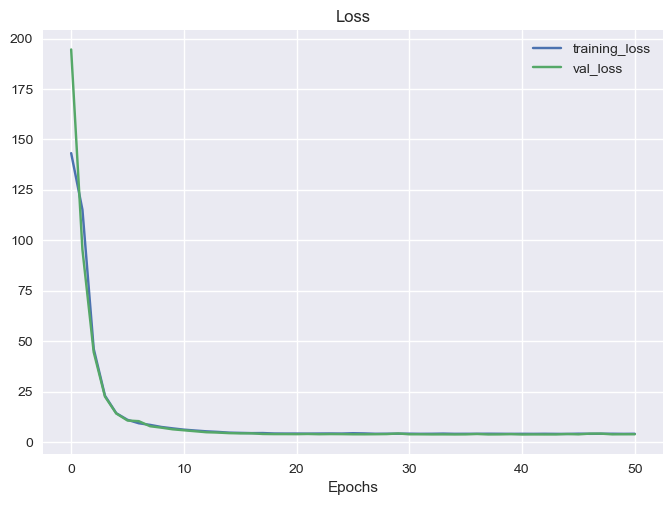

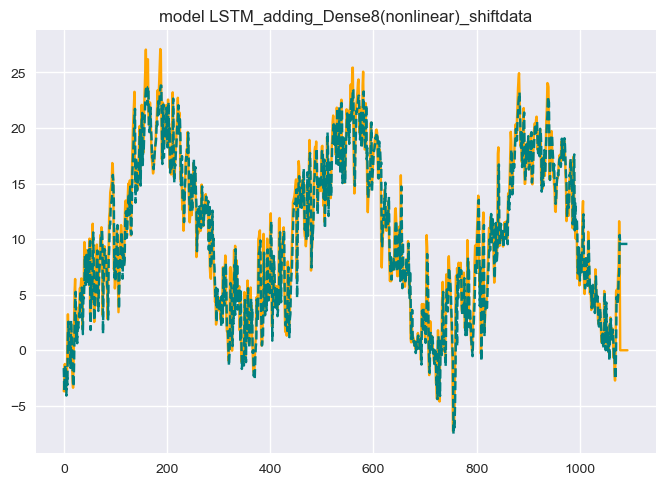

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 64)                18688     
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 9         
Total params: 19,217
Trainable params: 19,217
Non-trainable params: 0
_________________________________________________________________
None


In [112]:
check_output(model_shift_LSTM_01, history_shift_LSTM_01, X_test, y_test, 'LSTM_adding_Dense8(nonlinear)_shiftdata')

Change timesteps to 30days

In [113]:
X_train, X_test, y_train, y_test, scaler = get_keras_format_series(df=ShiftSeries_df, train_size_presentage = 0.75,
                                                                   target_feature='temp', time_steps=30)
print('Training input shape: {}'.format(X_train.shape))
print('Training output shape: {}'.format(y_train.shape))
print('Test input shape: {}'.format(X_test.shape))
print('Test output shape: {}'.format(y_test.shape))

Training input shape: (3276, 30, 8)
Training output shape: (3276, 1)
Test input shape: (1093, 30, 8)
Test output shape: (1093, 1)


In [118]:
# I need to run it after each time usage
def call_back(file_path, freq, int_value, patience, batch_size=[32, 64], mode=['auto','min','max'], 
              monitor=['val_loss','loss']):
    import tensorflow as tf
    check_point = tf.keras.callbacks.ModelCheckpoint(filepath=file_path, monitor=monitor, verbose=0,
                                                     save_best_only=False, mode=mode, save_freq = batch_size*freq,
                                                    initial_value_threshold = int_value)
    live_plot = TrainingPlot()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=1)
    return [check_point, live_plot, early_stopping]
    

In [119]:
def def_model(X_train, cell_units, time_steps, features):
    '''
    X_train (array): input sequence samples for training 
    cell_units (int): number of hidden units for RNN cells  
    '''
    model = Sequential()
    model.add(SimpleRNN(cell_units, input_shape=(time_steps,features)))
    model.add(Dense(8, activation=relu)) # add dense value same as features and add activation to make in non-linear
    model.add(Dense(1)) # Should not use relu because affect and destroy minus output values
    
    return model

C:\Users\Mehrad Tavanamehr\AppData\Local\Temp\ipykernel_15316\3357694502.py:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


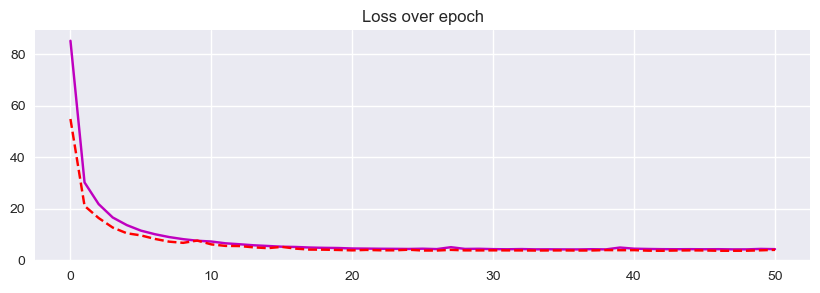

INFO:tensorflow:Assets written to: ./checkpoint\check_shift_SimpleRNN_02\assets
Epoch 00058: early stopping


In [120]:
# the best model from previous experience
call_back = call_back(file_path= './checkpoint/check_shift_SimpleRNN_02', freq= 5, int_value= 10, patience= 10, batch_size= 64,
                      mode= 'min', monitor= 'val_loss')

model_shift_SimpleRNN_02 = def_model(X_train, cell_units= 64, time_steps= 30, features= 8)

history_shift_SimpleRNN_02 = compile_fit(model_shift_SimpleRNN_02, X_train, y_train, 200, batch_size= 64, loss='mean_squared_error',
                                   optimizer= Adam(), metrics= [RootMeanSquaredError()], call_back= call_back, val_split= 0.1)

MSE value 91.67592645360786


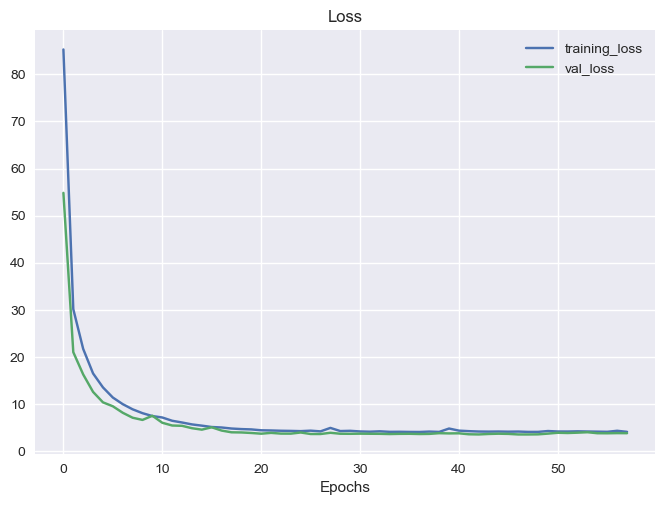

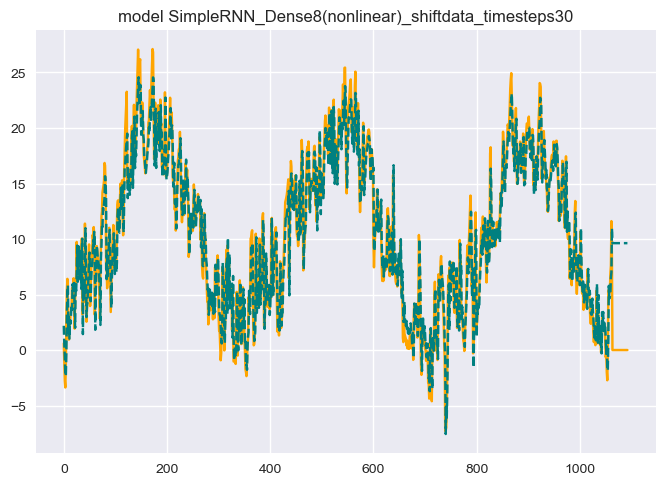

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_8 (SimpleRNN)     (None, 64)                4672      
_________________________________________________________________
dense_28 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 9         
Total params: 5,201
Trainable params: 5,201
Non-trainable params: 0
_________________________________________________________________
None


In [121]:
check_output(model_shift_SimpleRNN_02, history_shift_SimpleRNN_02, X_test, y_test, 'SimpleRNN_Dense8(nonlinear)_shiftdata_timesteps30')

In [114]:
# I need to run it after each time usage
def call_back(file_path, freq, int_value, patience, batch_size=[32, 64], mode=['auto','min','max'], 
              monitor=['val_loss','loss']):
    import tensorflow as tf
    check_point = tf.keras.callbacks.ModelCheckpoint(filepath=file_path, monitor=monitor, verbose=0,
                                                     save_best_only=False, mode=mode, save_freq = batch_size*freq,
                                                    initial_value_threshold = int_value)
    live_plot = TrainingPlot()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=1)
    return [check_point, live_plot, early_stopping]
    

In [115]:
def def_model(X_train, cell_units, time_steps, features):
    '''
    X_train (array): input sequence samples for training 
    cell_units (int): number of hidden units for RNN cells  
    '''
    model = Sequential()
    model.add(LSTM(cell_units, input_shape=(time_steps,features)))
    model.add(Dense(8, activation=relu)) # add dense value same as features and add activation to make in non-linear
    model.add(Dense(1)) # Should not use relu because affect and destroy minus output values
    
    return model

C:\Users\Mehrad Tavanamehr\AppData\Local\Temp\ipykernel_15316\3357694502.py:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


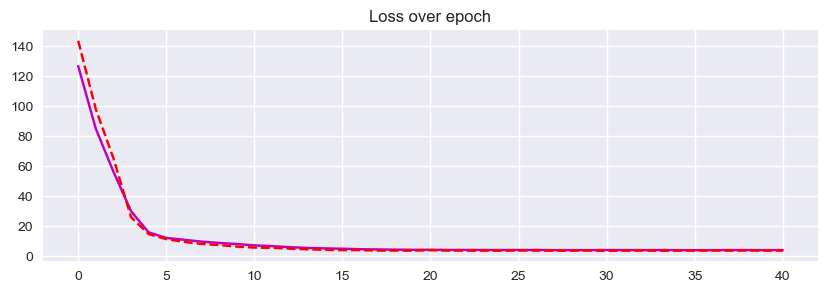

Epoch 00041: early stopping


In [116]:
# the best model from previous experience
call_back = call_back(file_path= './checkpoint/check_shift_LSTM_02', freq= 5, int_value= 10, patience= 10, batch_size= 64,
                      mode= 'min', monitor= 'val_loss')

model_shift_LSTM_02 = def_model(X_train, cell_units= 64, time_steps= 30, features= 8)

history_shift_LSTM_02 = compile_fit(model_shift_LSTM_02, X_train, y_train, 200, batch_size= 64, loss='mean_squared_error',
                                   optimizer= Adam(), metrics= [RootMeanSquaredError()], call_back= call_back, val_split= 0.1)

MSE value 96.33711520292178


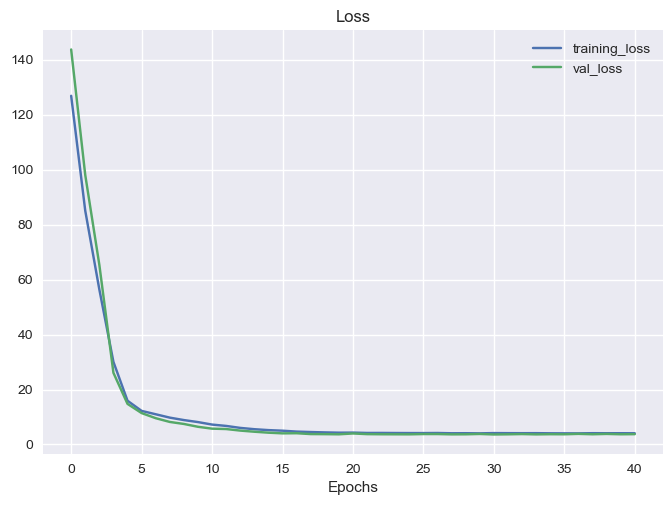

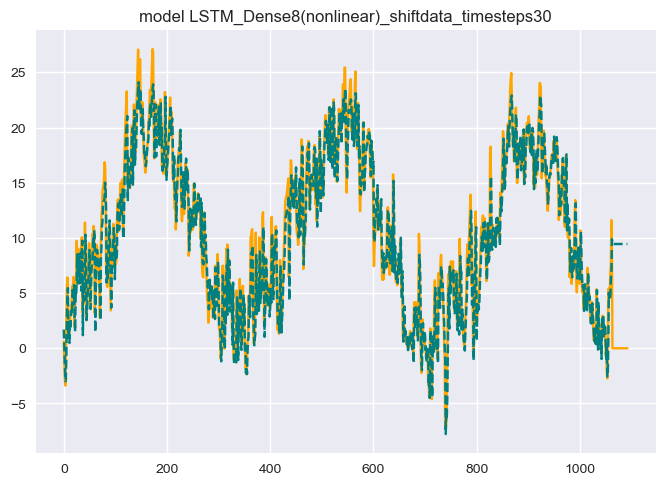

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 64)                18688     
_________________________________________________________________
dense_26 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 9         
Total params: 19,217
Trainable params: 19,217
Non-trainable params: 0
_________________________________________________________________
None


In [117]:
check_output(model_shift_LSTM_02, history_shift_LSTM_02, X_test, y_test, 'LSTM_Dense8(nonlinear)_shiftdata_timesteps30')

## Go with just real Temperature feature

In [27]:
Temperature_df = pd.DataFrame()
Temperature_df['temp'] = TimeSeries_df['temp'].copy()

In [28]:
X_train, X_test, y_train, y_test, scaler = get_keras_format_series(df=Temperature_df, train_size_presentage = 0.75,
                                                                   target_feature='temp', time_steps=15)
print('Training input shape: {}'.format(X_train.shape))
print('Training output shape: {}'.format(y_train.shape))
print('Test input shape: {}'.format(X_test.shape))
print('Test output shape: {}'.format(y_test.shape))

Training input shape: (3287, 15, 1)
Training output shape: (3287, 1)
Test input shape: (1096, 15, 1)
Test output shape: (1096, 1)


In [29]:
# I need to run it after each time usage
def call_back(file_path, freq, int_value, patience, batch_size=[32, 64], mode=['auto','min','max'], 
              monitor=['val_loss','loss']):
    import tensorflow as tf
    check_point = tf.keras.callbacks.ModelCheckpoint(filepath=file_path, monitor=monitor, verbose=0,
                                                     save_best_only=False, mode=mode, save_freq = batch_size*freq,
                                                    initial_value_threshold = int_value)
    live_plot = TrainingPlot()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=1)
    return [check_point, live_plot, early_stopping]
    

In [30]:
def def_model(X_train, cell_units, time_steps, features):
    '''
    X_train (array): input sequence samples for training 
    cell_units (int): number of hidden units for RNN cells  
    '''
    model = Sequential()
    model.add(SimpleRNN(cell_units, input_shape=(time_steps,features)))
   # model.add(Dense(8, activation=relu)) # add dense value same as features and add activation to make in non-linear
    model.add(Dense(1)) # Should not use relu because affect and destroy minus output values
    
    return model

C:\Users\Mehrad Tavanamehr\AppData\Local\Temp\ipykernel_20124\3357694502.py:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


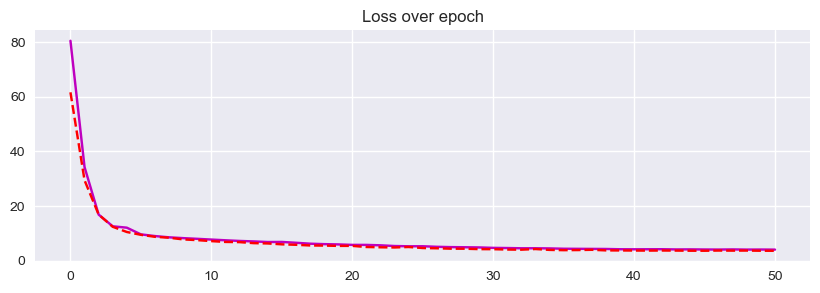

INFO:tensorflow:Assets written to: ./checkpoint\check_Temp_RNN_01\assets
Epoch 00056: early stopping


In [31]:
# the best model from previous experience
call_back = call_back(file_path= './checkpoint/check_Temp_RNN_01', freq= 5, int_value= 10, patience= 5, batch_size= 64,
                      mode= 'min', monitor= 'val_loss')

model_temp_RNN_01 = def_model(X_train, cell_units= 64, time_steps= 15, features= 1)

history_temp_RNN_01 = compile_fit(model_temp_RNN_01, X_train, y_train, 200, batch_size= 64, loss='mean_squared_error',
                                   optimizer= Adam(), metrics= [RootMeanSquaredError()], call_back= call_back, val_split= 0.1)

MSE value 97.169287872456


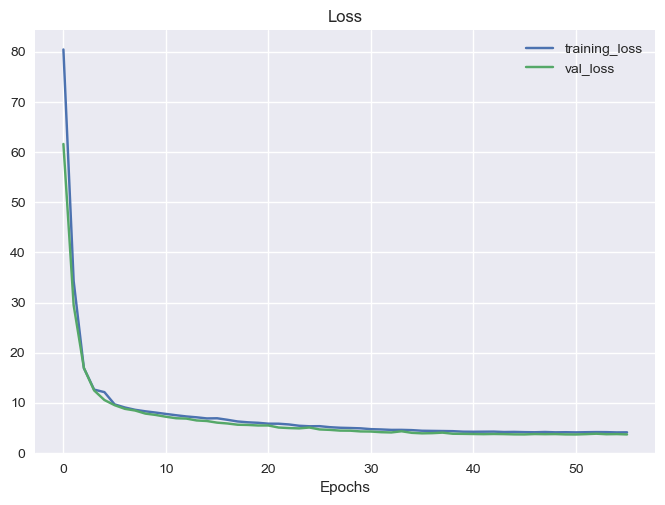

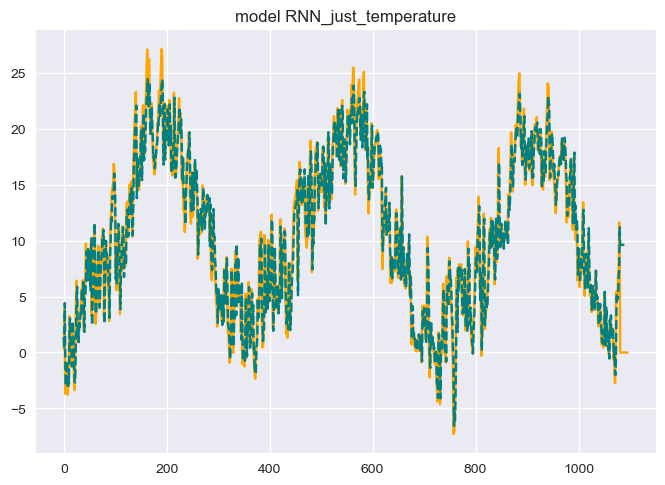

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 64)                4224      
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
check_output(model_temp_RNN_01, history_temp_RNN_01, X_test, y_test, 'RNN_just_temperature')

In [33]:
# I need to run it after each time usage
def call_back(file_path, freq, int_value, patience, batch_size=[32, 64], mode=['auto','min','max'], 
              monitor=['val_loss','loss']):
    import tensorflow as tf
    check_point = tf.keras.callbacks.ModelCheckpoint(filepath=file_path, monitor=monitor, verbose=0,
                                                     save_best_only=False, mode=mode, save_freq = batch_size*freq,
                                                    initial_value_threshold = int_value)
    live_plot = TrainingPlot()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=1)
    return [check_point, live_plot, early_stopping]
    

In [34]:
def def_model(X_train, cell_units, time_steps, features):
    '''
    X_train (array): input sequence samples for training 
    cell_units (int): number of hidden units for RNN cells  
    '''
    model = Sequential()
    model.add(LSTM(cell_units, input_shape=(time_steps,features)))
   # model.add(Dense(8, activation=relu)) # add dense value same as features and add activation to make in non-linear
    model.add(Dense(1)) # Should not use relu because affect and destroy minus output values
    
    return model

C:\Users\Mehrad Tavanamehr\AppData\Local\Temp\ipykernel_20124\3357694502.py:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


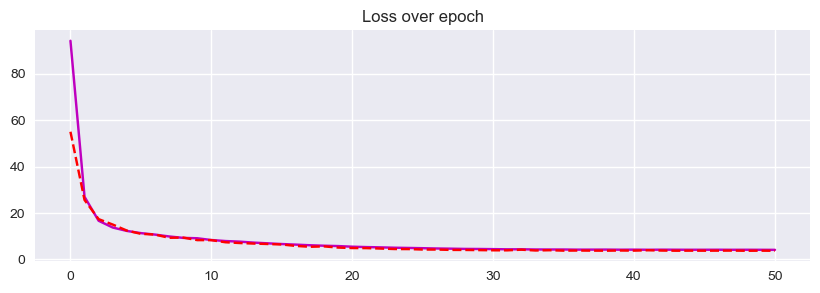

Epoch 00054: early stopping


In [35]:
# the best model from previous experience
call_back = call_back(file_path= './checkpoint/check_Temp_LSTM_01', freq= 5, int_value= 10, patience= 5, batch_size= 64,
                      mode= 'min', monitor= 'val_loss')

model_temp_LSTM_01 = def_model(X_train, cell_units= 64, time_steps= 15, features= 1)

history_temp_LSTM_01 = compile_fit(model_temp_LSTM_01, X_train, y_train, 200, batch_size= 64, loss='mean_squared_error',
                                   optimizer= Adam(), metrics= [RootMeanSquaredError()], call_back= call_back, val_split= 0.1)

MSE value 98.45045648579065


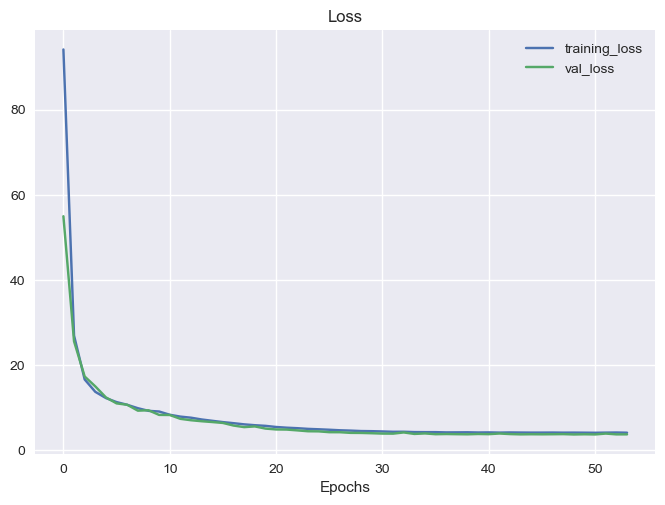

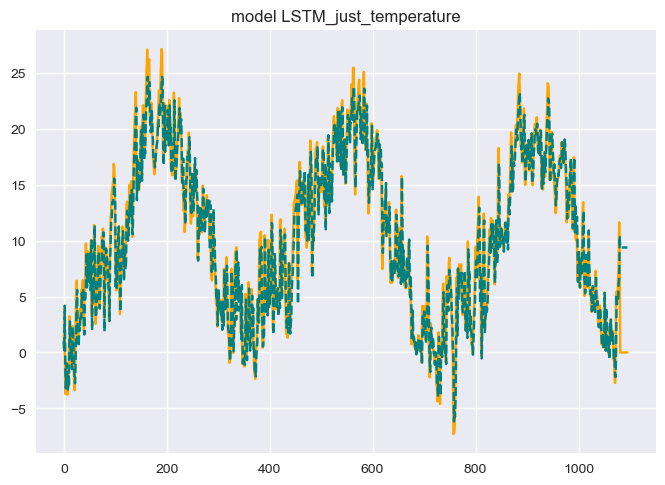

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
None


In [36]:
check_output(model_temp_LSTM_01, history_temp_LSTM_01, X_test, y_test, 'LSTM_just_temperature')

Chsnge timesteps to 30days

In [37]:
X_train, X_test, y_train, y_test, scaler = get_keras_format_series(df=Temperature_df, train_size_presentage = 0.75,
                                                                   target_feature='temp', time_steps=30)
print('Training input shape: {}'.format(X_train.shape))
print('Training output shape: {}'.format(y_train.shape))
print('Test input shape: {}'.format(X_test.shape))
print('Test output shape: {}'.format(y_test.shape))

Training input shape: (3287, 30, 1)
Training output shape: (3287, 1)
Test input shape: (1096, 30, 1)
Test output shape: (1096, 1)


In [49]:
# I need to run it after each time usage
def call_back(file_path, freq, int_value, patience, batch_size=[32, 64], mode=['auto','min','max'], 
              monitor=['val_loss','loss']):
    import tensorflow as tf
    check_point = tf.keras.callbacks.ModelCheckpoint(filepath=file_path, monitor=monitor, verbose=0,
                                                     save_best_only=False, mode=mode, save_freq = batch_size*freq,
                                                    initial_value_threshold = int_value)
    live_plot = TrainingPlot()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=1)
    return [check_point, live_plot, early_stopping]
    

In [45]:
def def_model(X_train, cell_units, time_steps, features):
    '''
    X_train (array): input sequence samples for training 
    cell_units (int): number of hidden units for RNN cells  
    '''
    model = Sequential()
    model.add(SimpleRNN(cell_units, input_shape=(time_steps,features)))
   # model.add(Dense(8, activation=relu)) # add dense value same as features and add activation to make in non-linear
    model.add(Dense(1)) # Should not use relu because affect and destroy minus output values
    
    return model

C:\Users\Mehrad Tavanamehr\AppData\Local\Temp\ipykernel_20124\3357694502.py:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


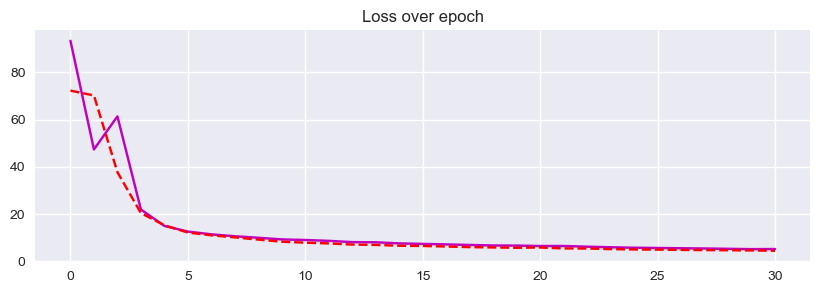

INFO:tensorflow:Assets written to: ./checkpoint\check_Temp_SimpleRRN_02\assets
Epoch 00040: early stopping


In [50]:
# the best model from previous experience
call_back = call_back(file_path= './checkpoint/check_Temp_SimpleRRN_02', freq= 5, int_value= 10, patience= 5, batch_size= 64,
                      mode= 'min', monitor= 'val_loss')

model_temp_SimpleRNN_02 = def_model(X_train, cell_units= 64, time_steps= 30, features= 1)

history_temp_SimpleRNN_02 = compile_fit(model_temp_SimpleRNN_02, X_train, y_train, 200, batch_size= 64, loss='mean_squared_error',
                                   optimizer= Adam(), metrics= [RootMeanSquaredError()], call_back= call_back, val_split= 0.1)

MSE value 91.90516629200879


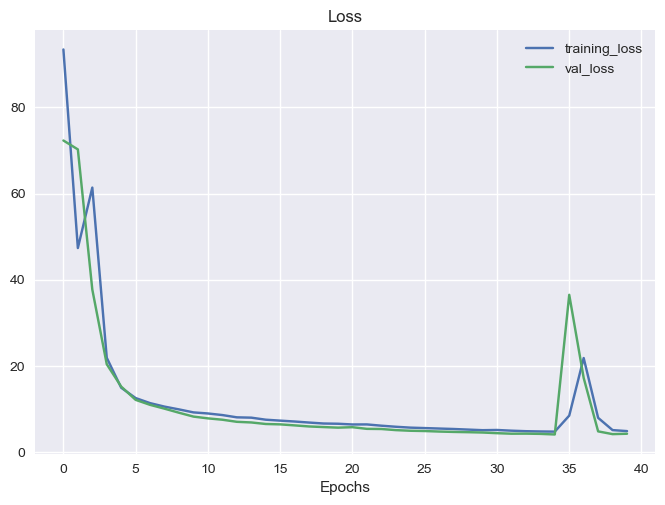

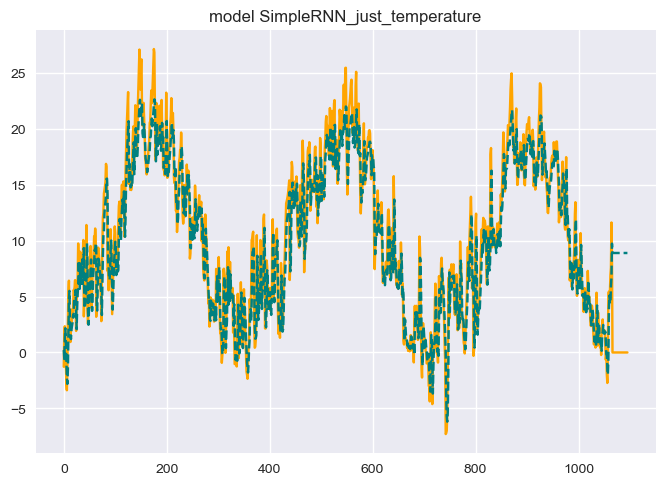

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 64)                4224      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________
None


In [52]:
check_output(model_temp_SimpleRNN_02, history_temp_SimpleRNN_02, X_test, y_test, 'SimpleRNN_just_temperature')

In [38]:
# I need to run it after each time usage
def call_back(file_path, freq, int_value, patience, batch_size=[32, 64], mode=['auto','min','max'], 
              monitor=['val_loss','loss']):
    import tensorflow as tf
    check_point = tf.keras.callbacks.ModelCheckpoint(filepath=file_path, monitor=monitor, verbose=0,
                                                     save_best_only=False, mode=mode, save_freq = batch_size*freq,
                                                    initial_value_threshold = int_value)
    live_plot = TrainingPlot()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=1)
    return [check_point, live_plot, early_stopping]
    

In [39]:
def def_model(X_train, cell_units, time_steps, features):
    '''
    X_train (array): input sequence samples for training 
    cell_units (int): number of hidden units for RNN cells  
    '''
    model = Sequential()
    model.add(LSTM(cell_units, input_shape=(time_steps,features)))
   # model.add(Dense(8, activation=relu)) # add dense value same as features and add activation to make in non-linear
    model.add(Dense(1)) # Should not use relu because affect and destroy minus output values
    
    return model

C:\Users\Mehrad Tavanamehr\AppData\Local\Temp\ipykernel_20124\3357694502.py:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


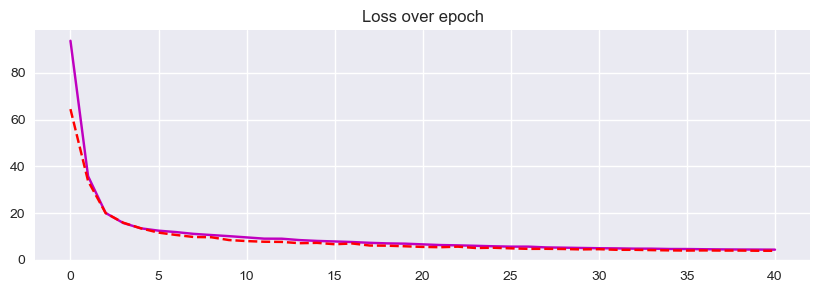

INFO:tensorflow:Assets written to: ./checkpoint\check_Temp_LSTM_02\assets
Epoch 00049: early stopping


In [40]:
# the best model from previous experience
call_back = call_back(file_path= './checkpoint/check_Temp_LSTM_02', freq= 5, int_value= 10, patience= 5, batch_size= 64,
                      mode= 'min', monitor= 'val_loss')

model_temp_LSTM_02 = def_model(X_train, cell_units= 64, time_steps= 30, features= 1)

history_temp_LSTM_02 = compile_fit(model_temp_LSTM_02, X_train, y_train, 200, batch_size= 64, loss='mean_squared_error',
                                   optimizer= Adam(), metrics= [RootMeanSquaredError()], call_back= call_back, val_split= 0.1)

MSE value 93.35809706162476


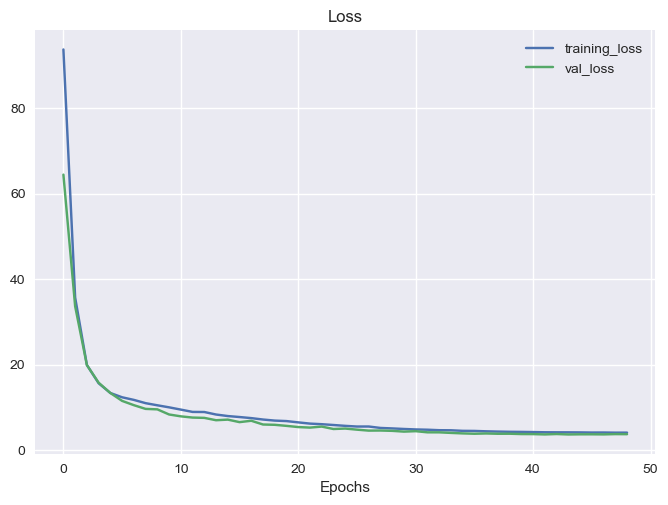

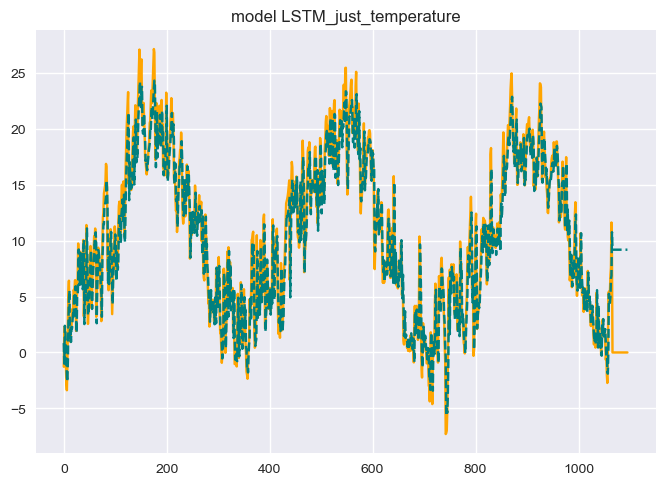

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
check_output(model_temp_LSTM_02, history_temp_LSTM_02, X_test, y_test, 'LSTM_just_temperature')

### Conclusion
Between three different ways I tried to predict timesereis with RNN and LSTM, the way I will select is using different between input from 1day to 7days.

The value of MSE is completely related to number of test sample that remain.

- the selected model is RNN with 30days as timesteps

### Predicting part for 7 days

In [101]:
# preparation data for feed RNN
def get_keras_format_prediction_part(df, target_feature, time_steps, predict_len):
    # make size of train and test
    length_df = df.shape[0]
    features = df.shape[1]
    
    from sklearn.preprocessing import StandardScaler
    scaler_pred = StandardScaler()
    Input_data = scaler_pred.fit_transform(df)
    
    X = np.zeros((length_df-time_steps, time_steps, features))
    y = np.zeros((length_df-time_steps, predict_len))
    
    for t in range(length_df-(time_steps+predict_len)):
        X[t, :, :] = Input_data[t:t+time_steps]
        y[t] = (df[target_feature][t+time_steps:t+time_steps+predict_len])
    
    return X, y, scaler_pred

In [44]:
df = Timeseries_temp.copy()

In [123]:
X, y, scaler_pred = get_keras_format_prediction_part(df, 'temp', 15, 7)

In [145]:
def def_model(cell_units, time_steps, features, forecasting):
    '''
    X_train (array): input sequence samples for training 
    cell_units (int): number of hidden units for RNN cells  
    '''
    model = Sequential()
    model.add(SimpleRNN(cell_units, input_shape=(time_steps,features)))
    model.add(Dense(features, activation=relu)) # add dense value same as features and add activation to make in non-linear
    model.add(Dense(forecasting)) # Should not use relu because affect and destroy minus output values
    
    return model

In [146]:
# I need to run it after each time usage
def call_back(file_path, freq, int_value, patience, batch_size=[32, 64], mode=['auto','min','max'], 
              monitor=['val_loss','loss']):
    import tensorflow as tf
    check_point = tf.keras.callbacks.ModelCheckpoint(filepath=file_path, monitor=monitor, verbose=0,
                                                     save_best_only=False, mode=mode, save_freq = batch_size*freq,
                                                    initial_value_threshold = int_value)
    live_plot = TrainingPlot()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=1)
    return [check_point, live_plot, early_stopping]
    

C:\Users\Mehrad Tavanamehr\AppData\Local\Temp\ipykernel_14052\3357694502.py:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


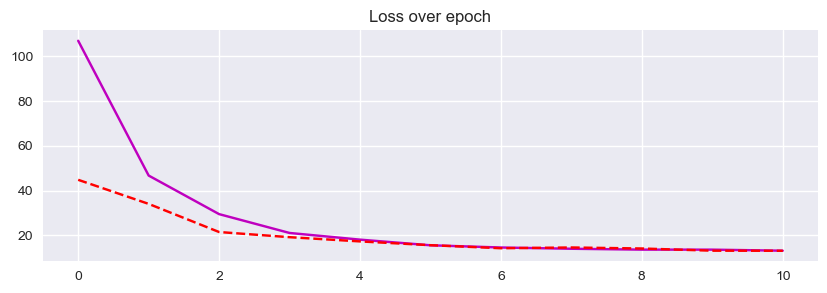

INFO:tensorflow:Assets written to: ./checkpoint\check_Temp_LSTM_test\assets
Epoch 00018: early stopping


In [147]:
call_back = call_back(file_path= './checkpoint/check_Temp_LSTM_test', freq= 5, int_value= 10, patience= 5, batch_size= 64,
                      mode= 'min', monitor= 'val_loss')

model_temp_LSTM_test = def_model(cell_units= 64, time_steps= 15, features= 8, forecasting=7)

history_temp_LSTM_test = compile_fit(model_temp_LSTM_test, X, y, 50, batch_size= 64, loss='mean_squared_error',
                                   optimizer= Adam(), metrics= [RootMeanSquaredError()],call_back=call_back, val_split= 0.1)

In [155]:
def predict_output(df, scaler, model, time_steps, features):
    X_prediction = scaler.transform(df[-time_steps:])
    X_pred = np.array(X_prediction).reshape(1,time_steps,features)
    y = model.predict(X_pred)
    return y
    

In [156]:
predict_output(df, scaler_pred, model_temp_LSTM_test, 15, 8)

array([[6.42299175, 5.05374106, 5.52222866, 3.99504784, 4.97157604,
        4.82257116, 3.90624589]])

### Daily Analyze with SARIMA

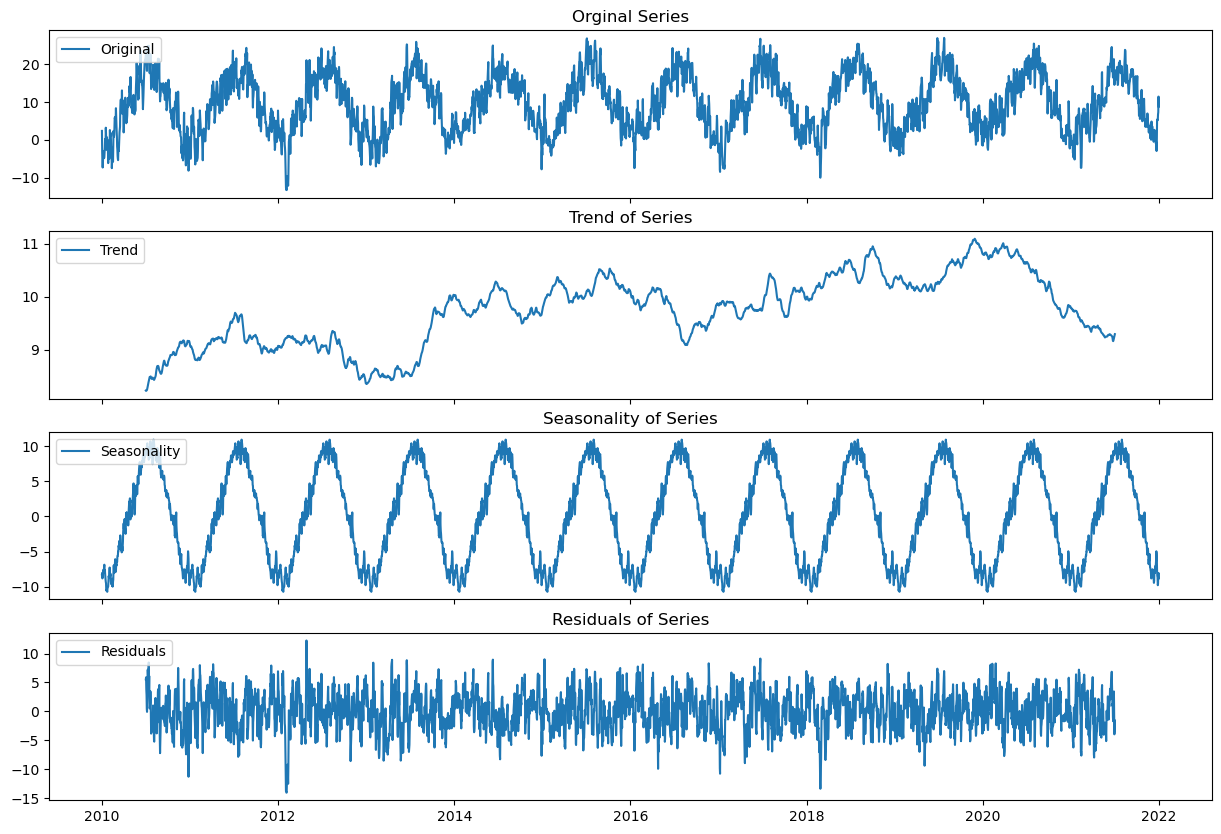

In [49]:
ss_decomposition(TimeSeries_df['temp'], 'additive', 365)

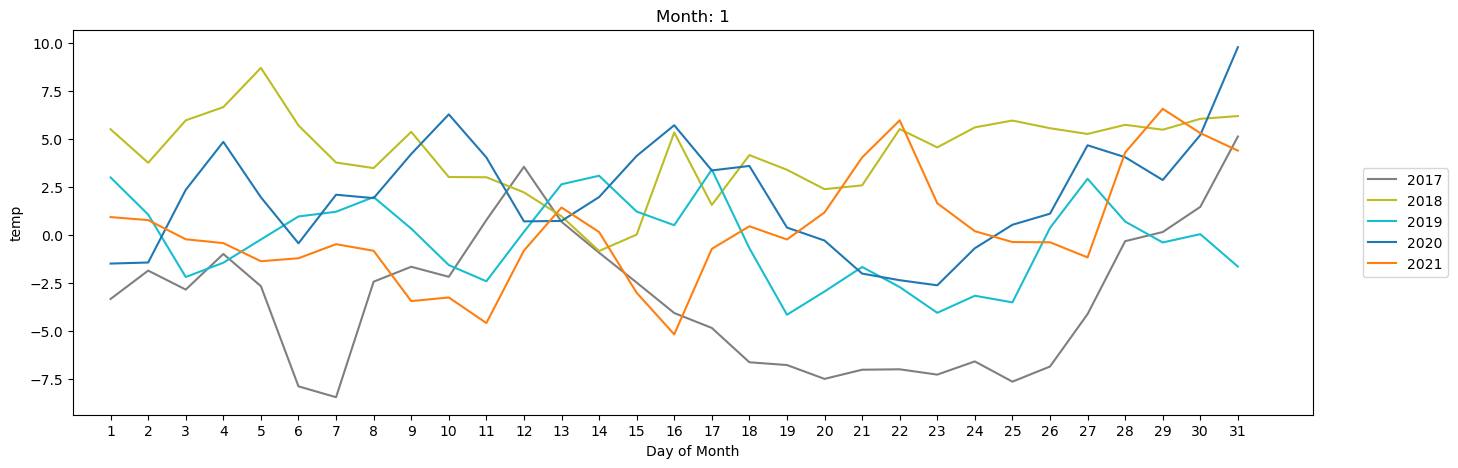

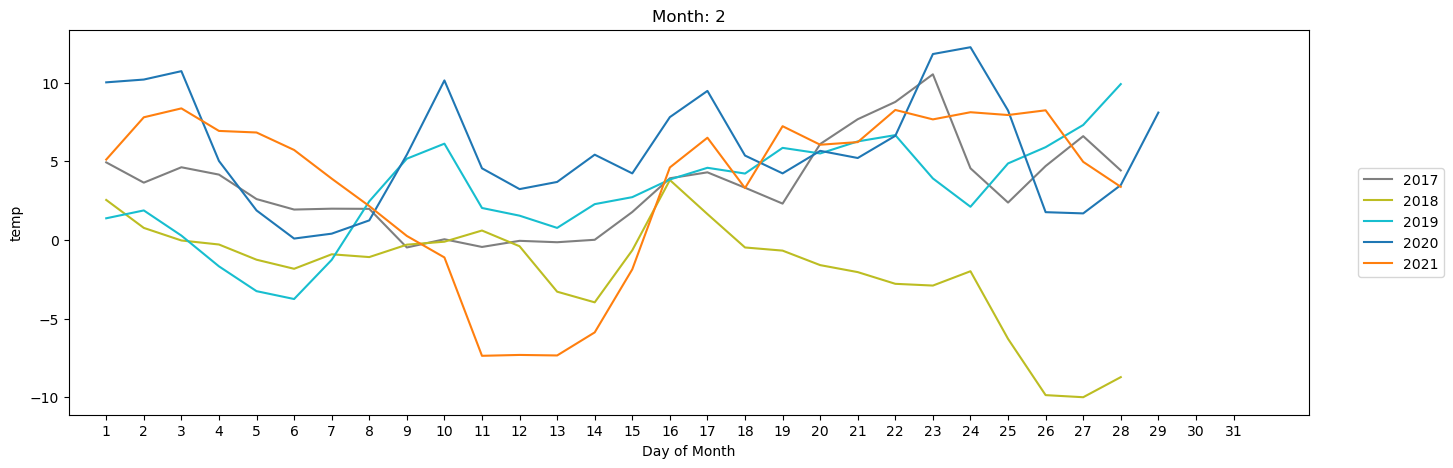

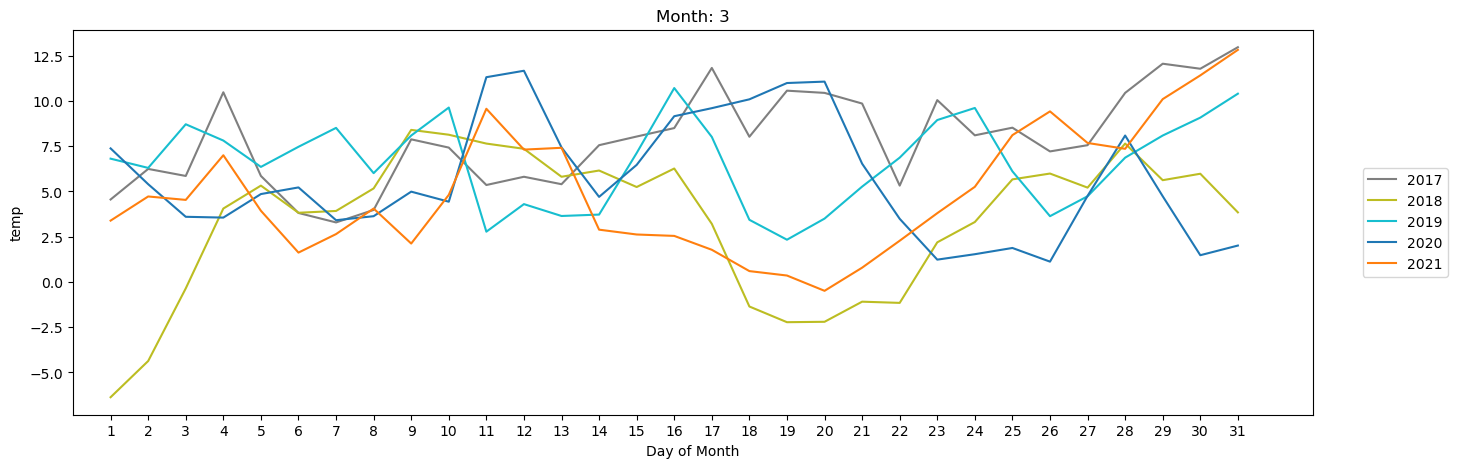

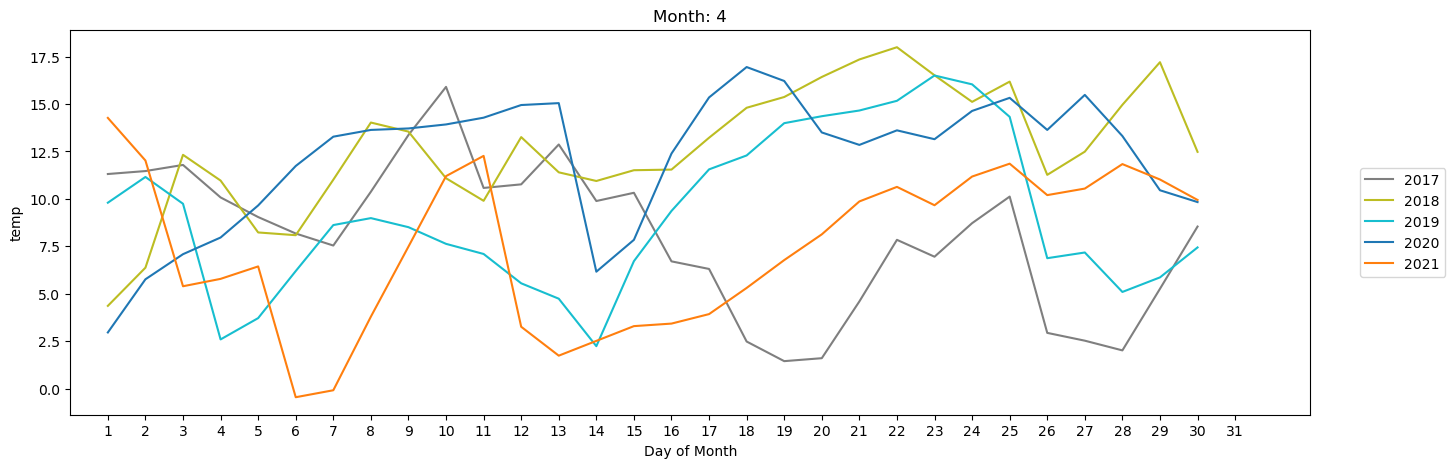

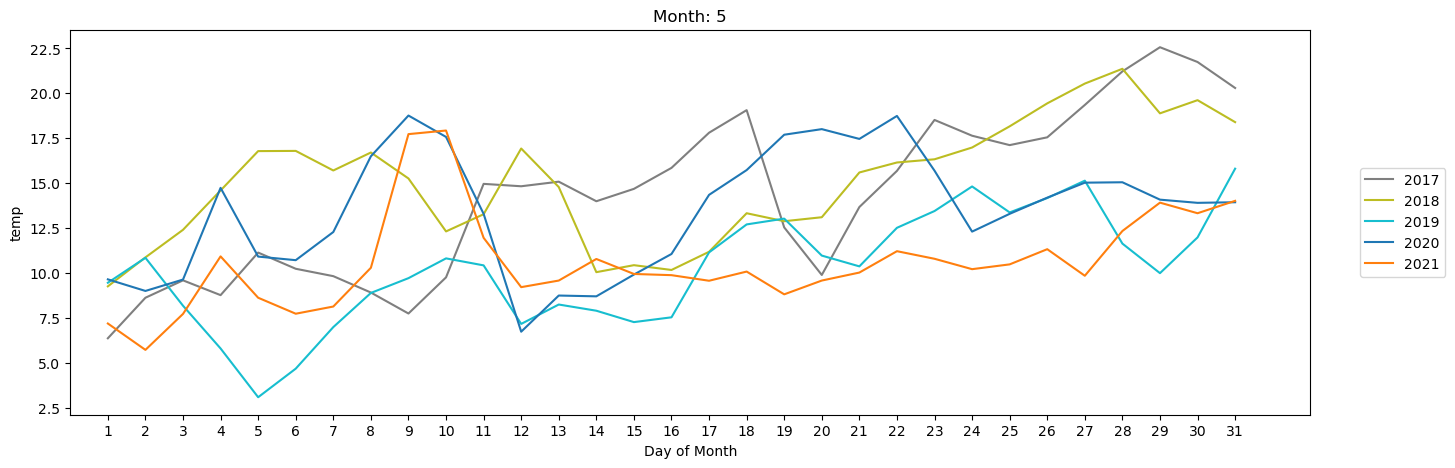

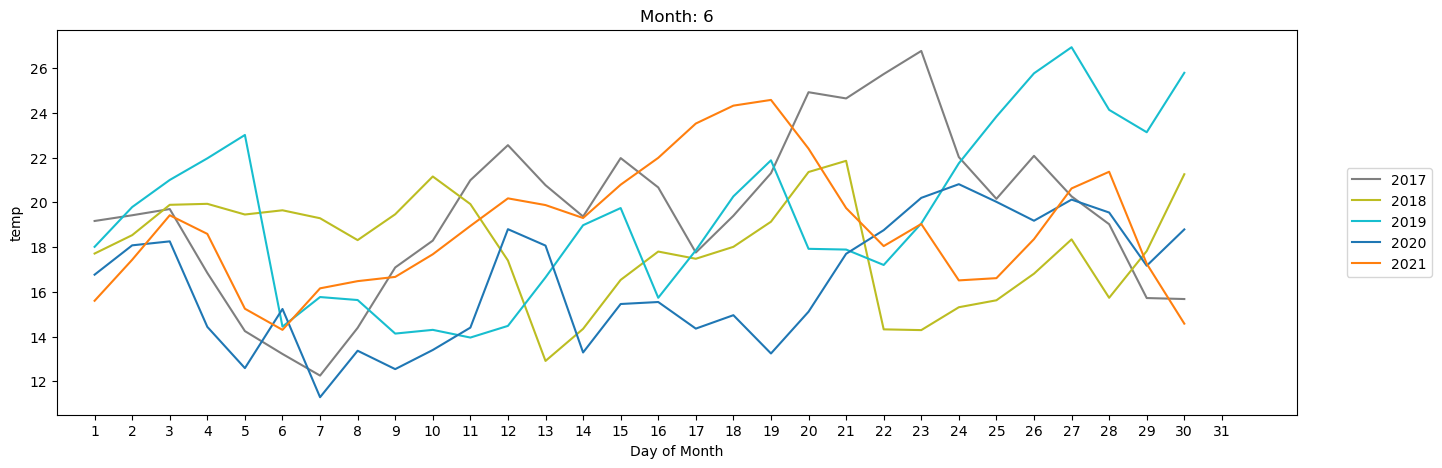

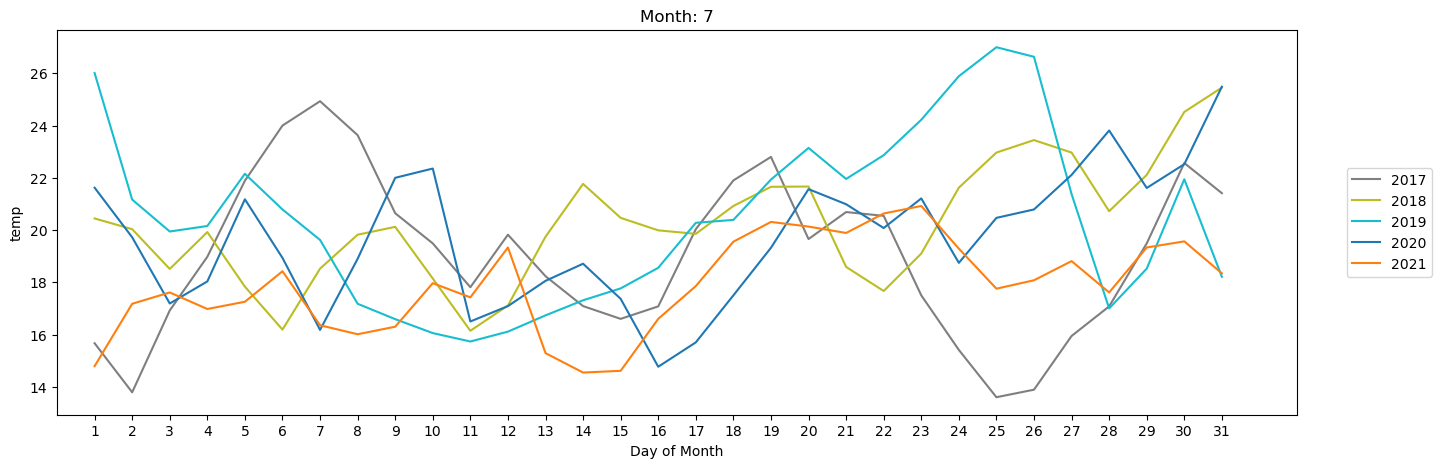

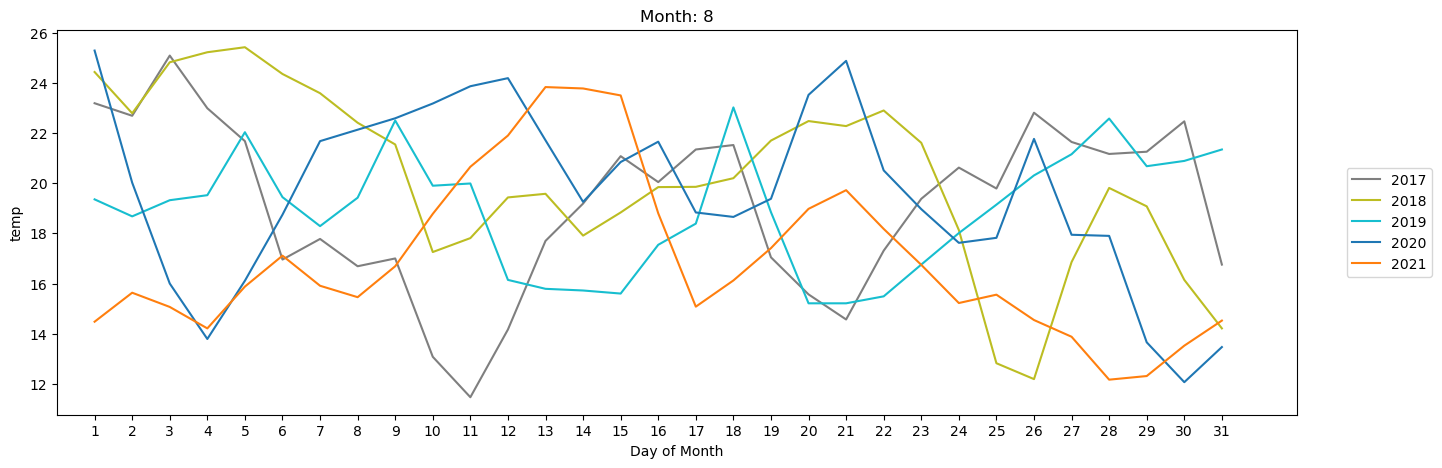

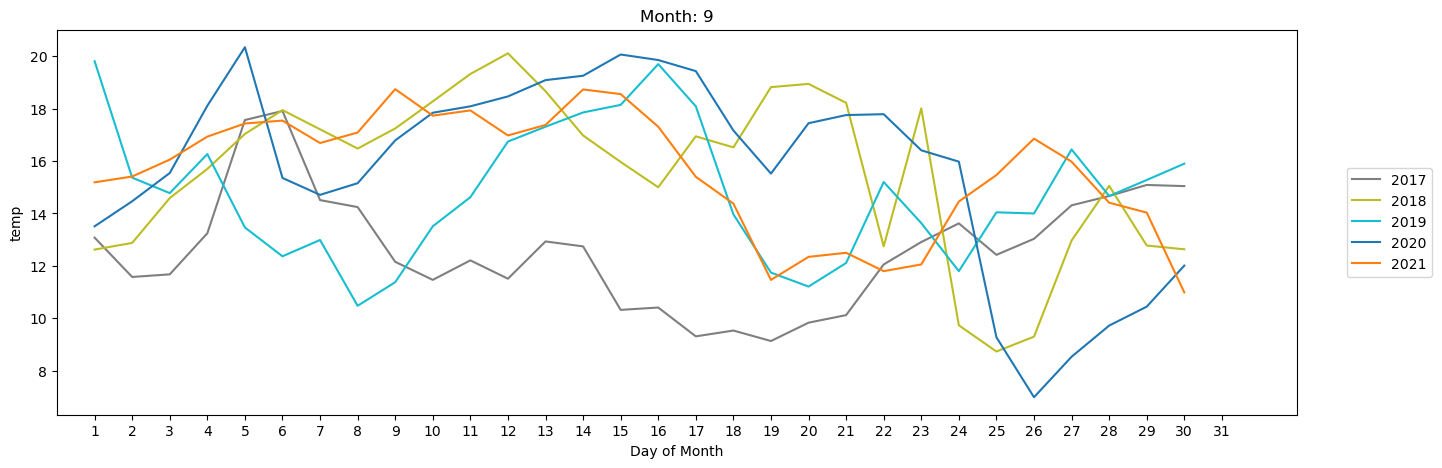

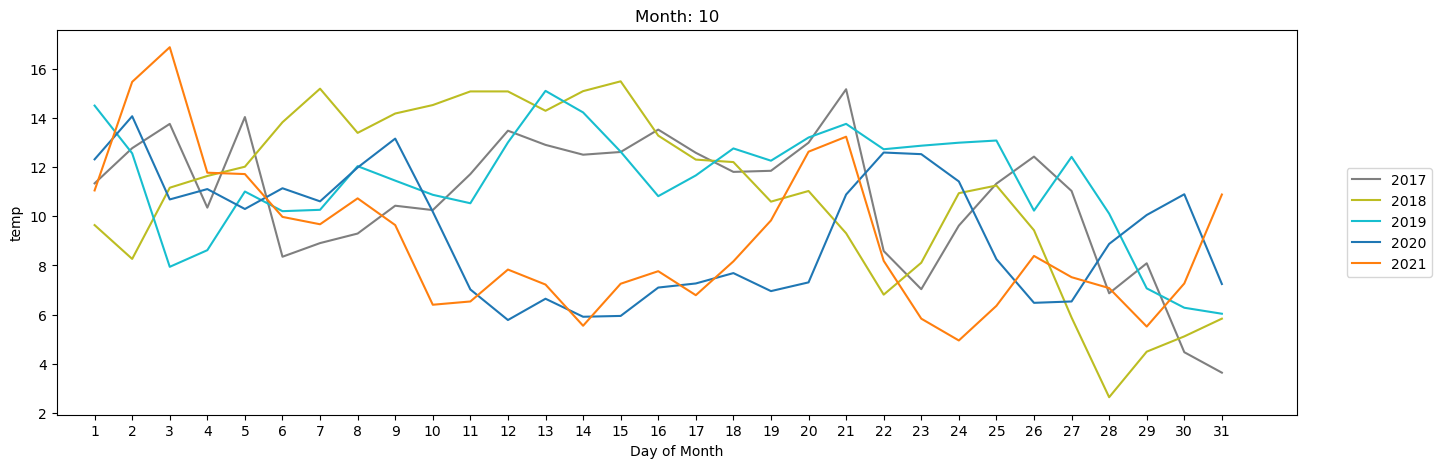

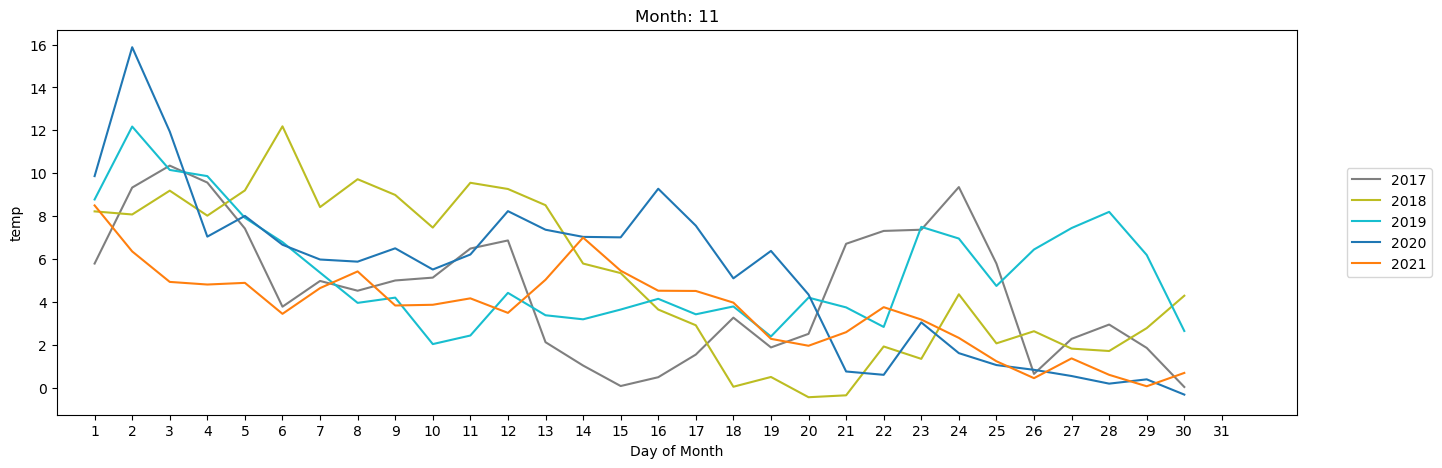

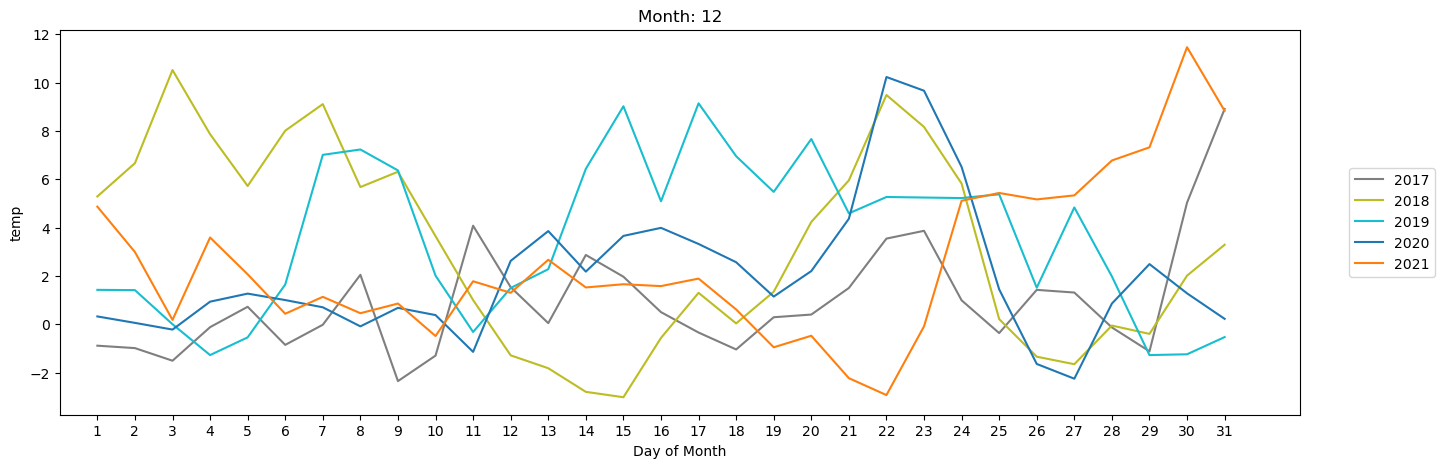

In [79]:
df = TimeSeries_df['temp'].copy()

# create color mapping based on all unique values of year
years = df.index.year.unique()
colors = sns.color_palette(n_colors=len(years))  # get a number of colors
cmap = dict(zip(years, colors))  # zip values to colors

for k, v in df.groupby(df.index.month):  # group the dateframe by month
    plt.figure(figsize=(16, 5))
    for year in v.index.year[v.index.year.isin([2017,2018,2019,2020,2021])].unique():  # withing the month plot each year
        data = v[v.index.year == year]
        sns.lineplot(x=data.index.day, y=data, err_style=None, hue=year, palette=cmap)
    plt.xlim(0, 33)
    plt.xticks(range(1, 32))
    plt.title(f'Month: {k}')
    plt.xlabel('Day of Month')
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()


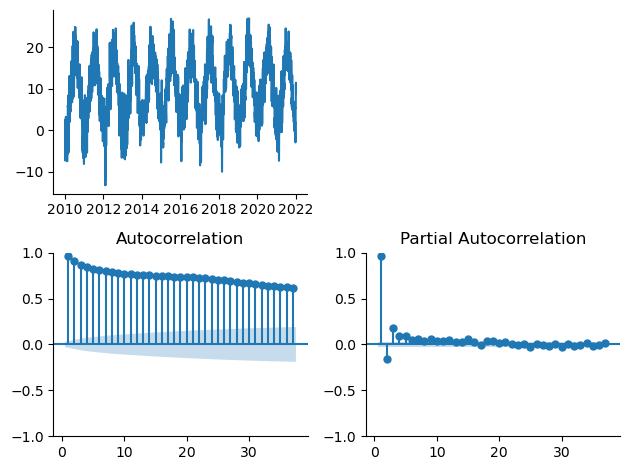

In [101]:
plots(df)

The ACF graph shows, the data is not stationary, so I changed to stationary with using diff() method.


In [93]:
TimeSeries_df['temp_diff'] = TimeSeries_df['temp'].diff(365)

<AxesSubplot: xlabel='datetime'>

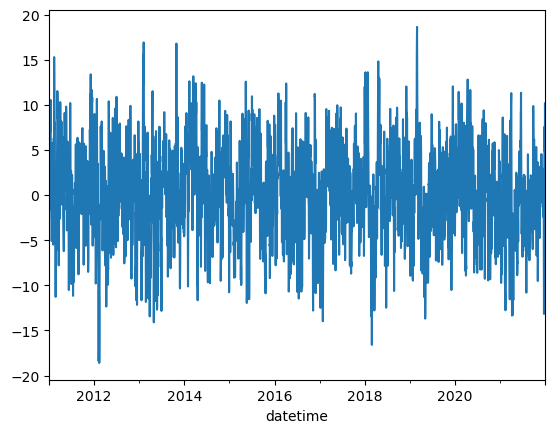

In [94]:
TimeSeries_df['temp_diff'].dropna().plot()

In [95]:
TimeSeries_df.dropna(inplace=True)

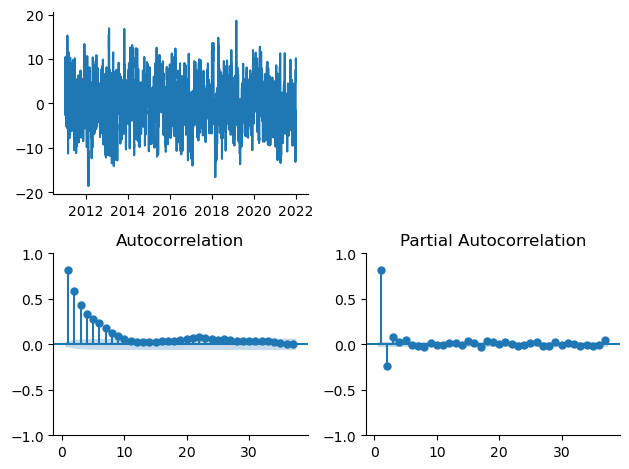

In [102]:
plots(TimeSeries_df['temp_diff'])

In [104]:
sar = sm.tsa.statespace.SARIMAX(TimeSeries_df['temp_diff'], 
                                order=(1,0,0), 
                                seasonal_order=(0,1,0,365), 
                                trend='c').fit()
sar.summary()

C:\Users\Mehrad Tavanamehr\.conda\envs\c10_final_project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Mehrad Tavanamehr\.conda\envs\c10_final_project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MemoryError: Unable to allocate 4.01 GiB for an array with shape (366, 366, 4018) and data type float64

As the repeated data relate to 365 and it is a big number it cannot work

### Monthly
##### change to monthly prediction
Because we work with daily information it is huge processing need to take for fit so I decide to go with monthly and after find trend and prediction on final month of prediction

In [105]:
# resampling in monthly
monthly = TimeSeries_df.resample('M').mean().copy()

Text(0, 0.5, 'Temperature')

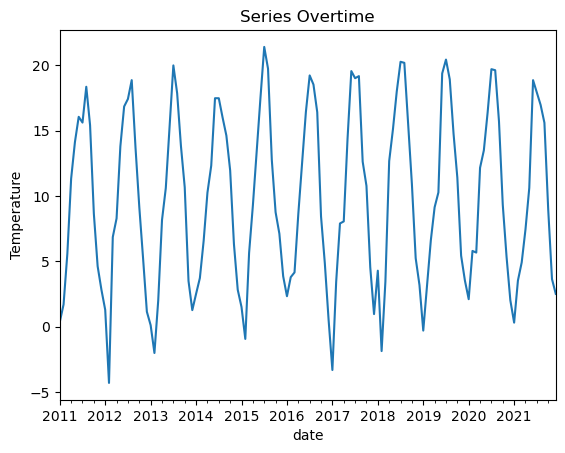

In [109]:
monthly['temp'].plot()
plt.title('Series Overtime')
plt.xlabel('date')
plt.ylabel('Temperature')

C:\Users\Mehrad Tavanamehr\AppData\Local\Temp\ipykernel_3988\3315854806.py:6: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


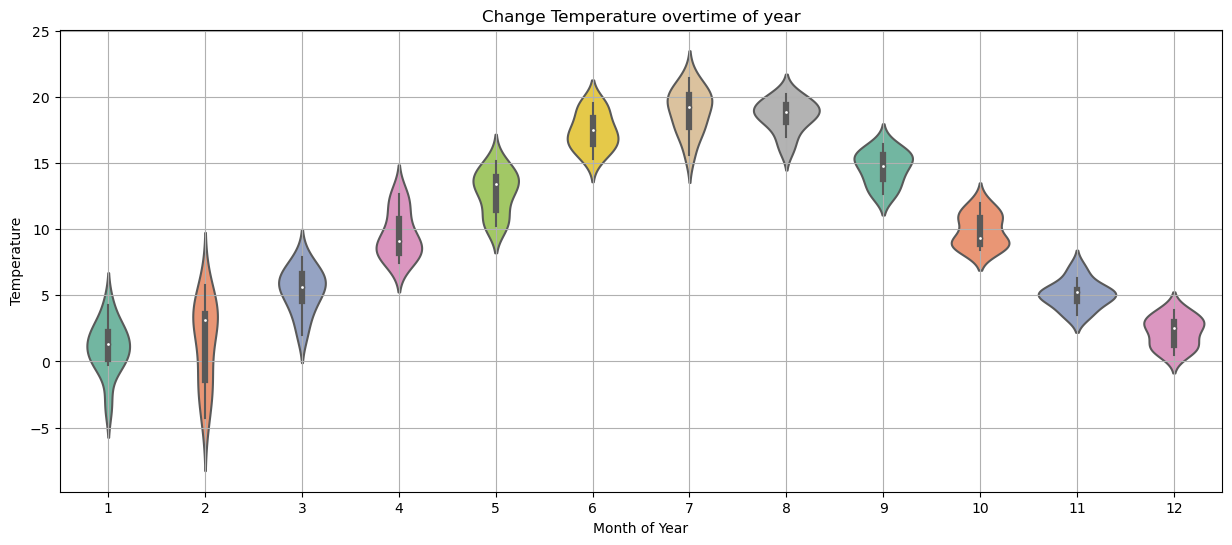

In [107]:
plt.figure(figsize=(15, 6))
sns.violinplot(x=monthly.index.month, y=monthly['temp'], palette="Set2")
plt.title("Change Temperature overtime of year")
plt.xlabel("Month of Year")
plt.ylabel("Temperature")
plt.grid(b=True)


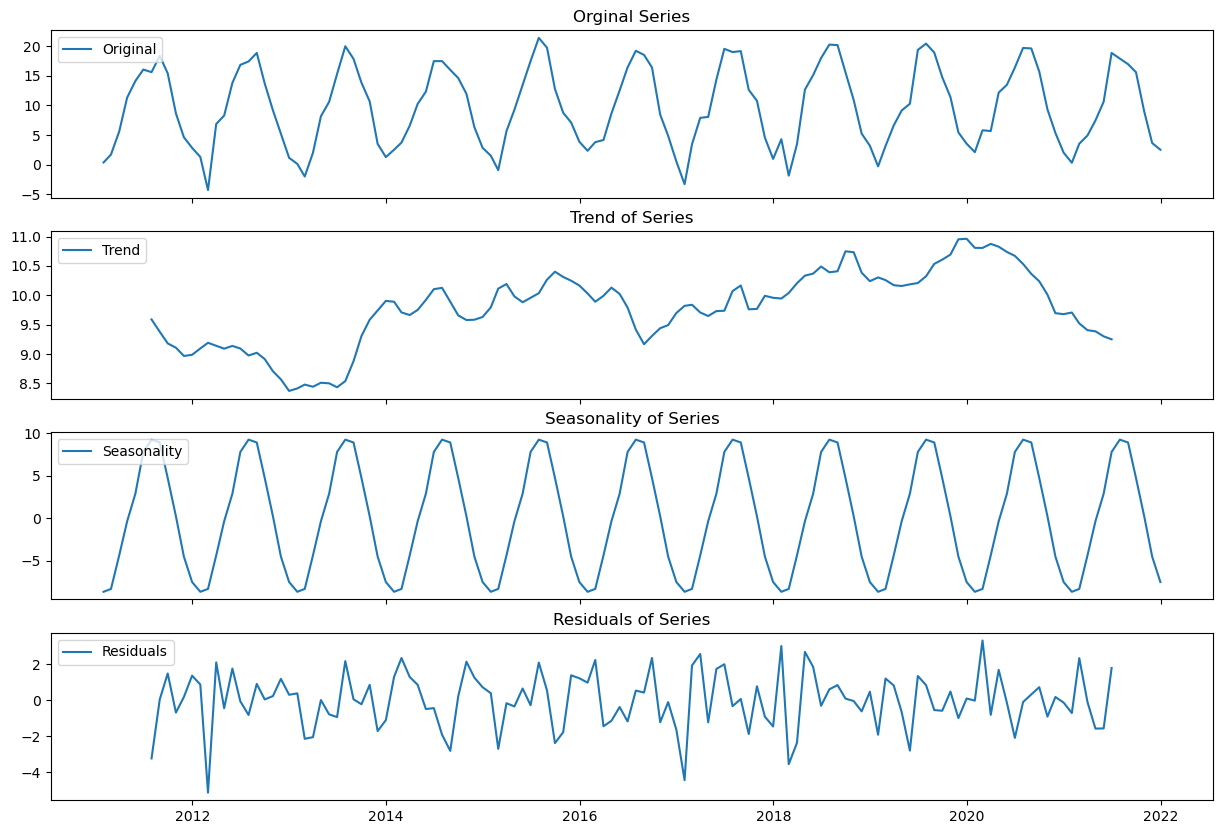

In [108]:
ss_decomposition(monthly['temp'], 'additive', 12)

Test Statistic           -1.607029
p-value                   0.480062
Lags Used                13.000000
Observations Used       118.000000
Critical Value (1%)      -3.487022
Critical Value (5%)      -2.886363
Critical Value (10%)     -2.580009
dtype: float64


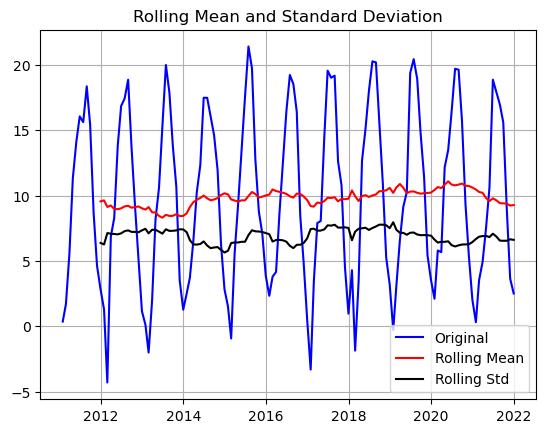

In [110]:
dftest(monthly['temp'])
# p-value allows us to reject a unit root: data is stationary

C:\Users\Mehrad Tavanamehr\.conda\envs\c10_final_project\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


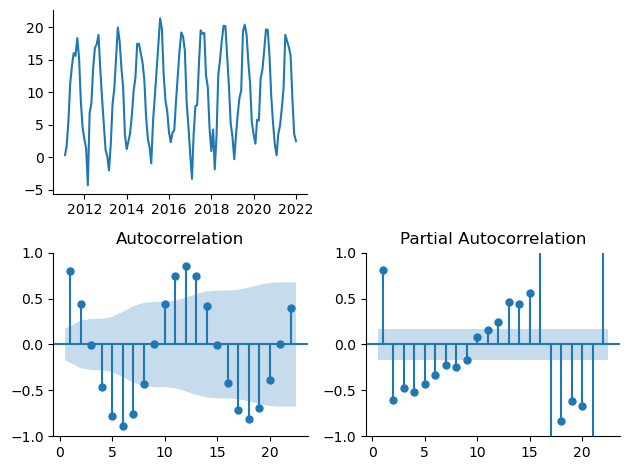

In [111]:
plots(monthly['temp'])

In [112]:
monthly['temp_diff'] = monthly['temp'].diff(12)
monthly.dropna(inplace=True)

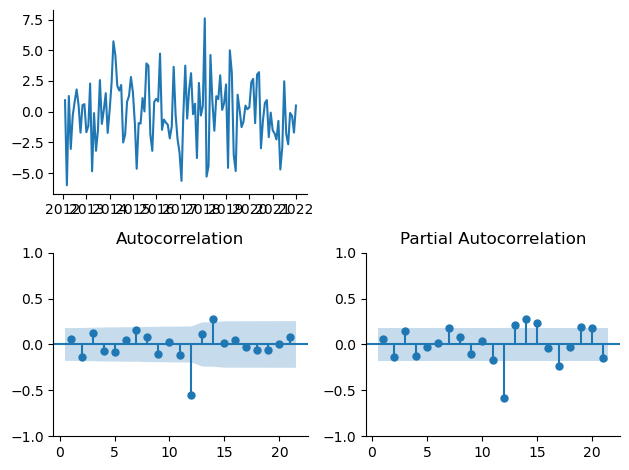

In [113]:
plots(monthly['temp_diff'])

In [114]:
# based of above graph for monthly temp prediction
sar = sm.tsa.statespace.SARIMAX(monthly['temp_diff'], 
                                order=(0,0,0), 
                                seasonal_order=(1,1,1,12), 
                                trend='c').fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                  temp_diff   No. Observations:                  120
Model:             SARIMAX(1, 1, [1], 12)   Log Likelihood                -256.110
Date:                    Thu, 09 Nov 2023   AIC                            520.221
Time:                            14:56:53   BIC                            530.949
Sample:                        01-31-2012   HQIC                           524.571
                             - 12-31-2021                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0534      0.086     -0.621      0.535      -0.222       0.115
ar.S.L12      -0.5445      0.095     -5.715      0.000      -0.731      -0.358
ma.S.L12      -0.9994     75.673     -0.013      0.989    -149.315     147.317
sigma2         4.5834    346.737      0.013      0.989    -675.008     684.175
===================================================================================
Ljung-Box (L1) (Q):                   1.30   Jarque-Bera (JB):                 3.74
Prob(Q):                              0.25   Prob(JB):                         0.15
Heteroskedasticity (H):               0.48   Skew:                             0.16
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\Mehrad Tavanamehr\.conda\envs\c10_final_project\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


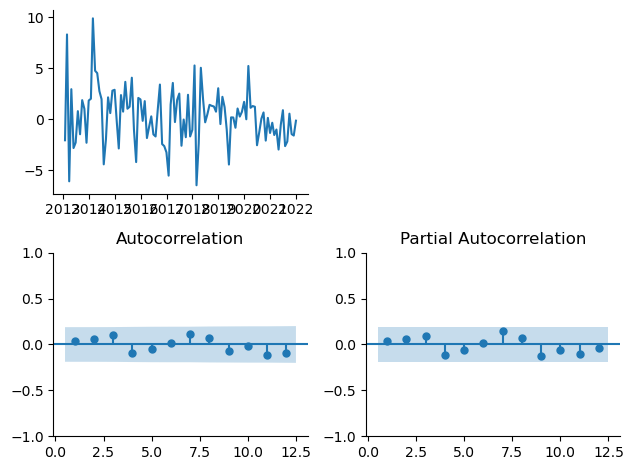

In [115]:
# plot resids
plots(sar.resid[sar.loglikelihood_burn:], lags=12);

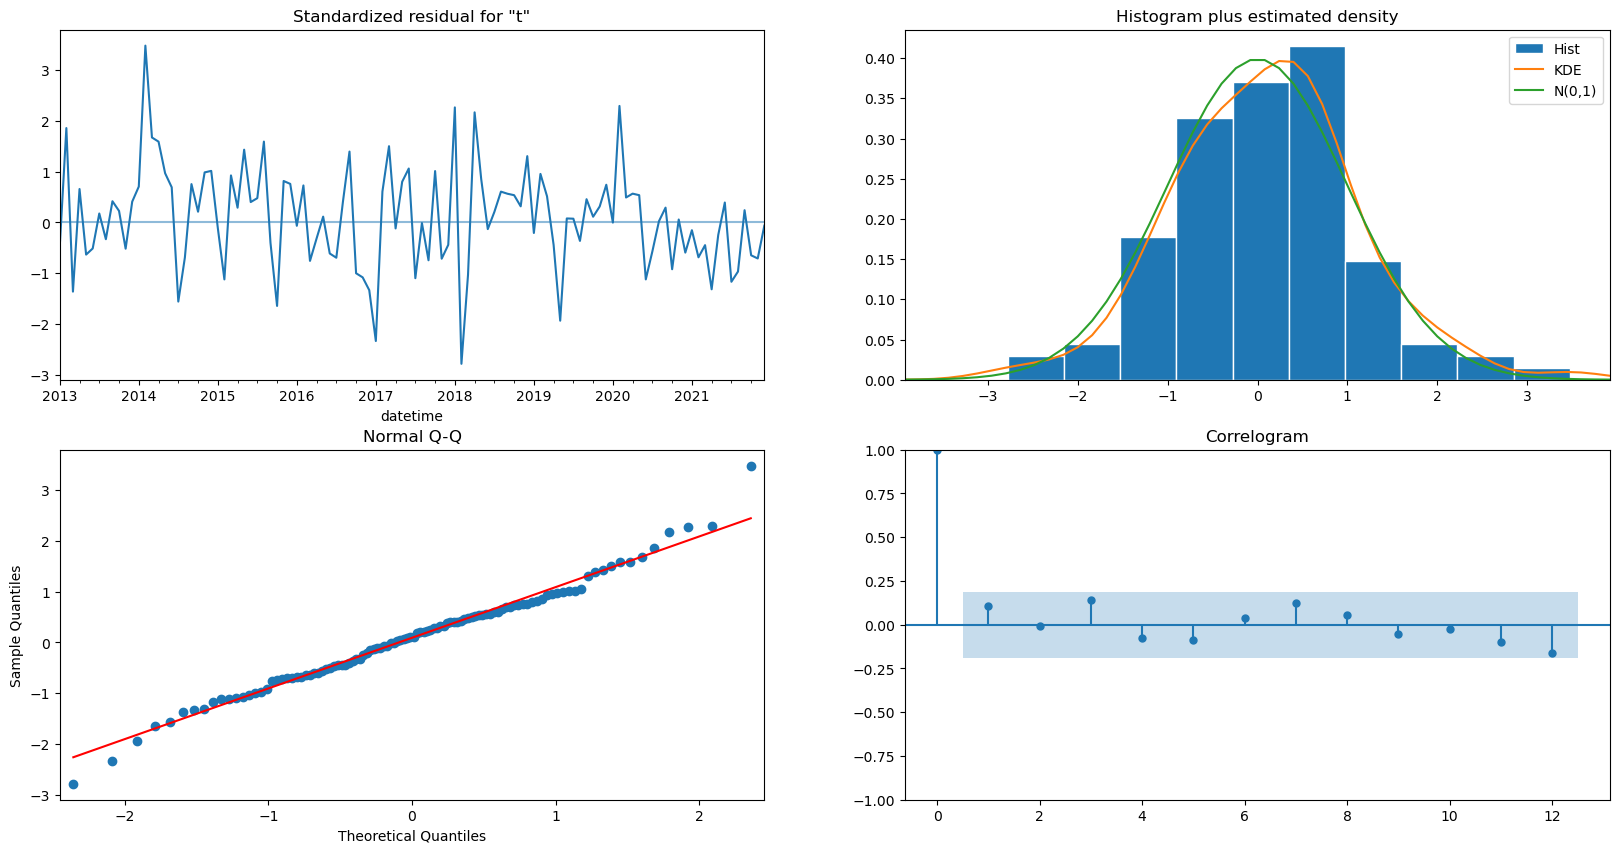

In [116]:
# plot residual diagnostics
sar.plot_diagnostics(lags=12,figsize = (20,10),);

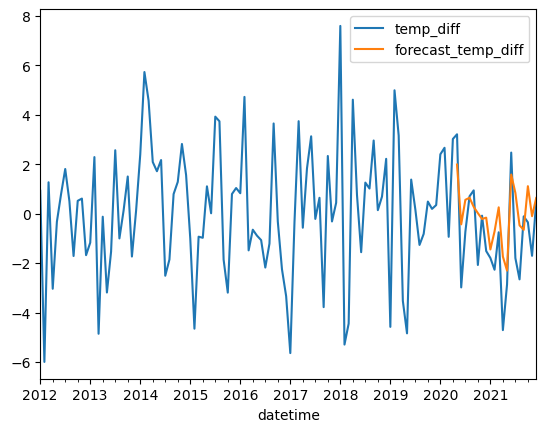

In [117]:
# plot predictions
pd.plotting.register_matplotlib_converters()

monthly['forecast_temp_diff'] = sar.predict(start = 100, end= 143)  
monthly[['temp_diff', 'forecast_temp_diff']].plot();

I want to create another one based on weekly sample to increase number of samples and see how it is affect on the prediction

### Weekly

In [53]:
# resampling in weekly
weekly = TimeSeries_df.resample('W-MON').mean().copy()

In [54]:
# save the dataset to put on online notebook to increase the memory and process (one time run)
#weekly.to_csv('data\weekly_samples.csv')

<AxesSubplot: xlabel='datetime'>

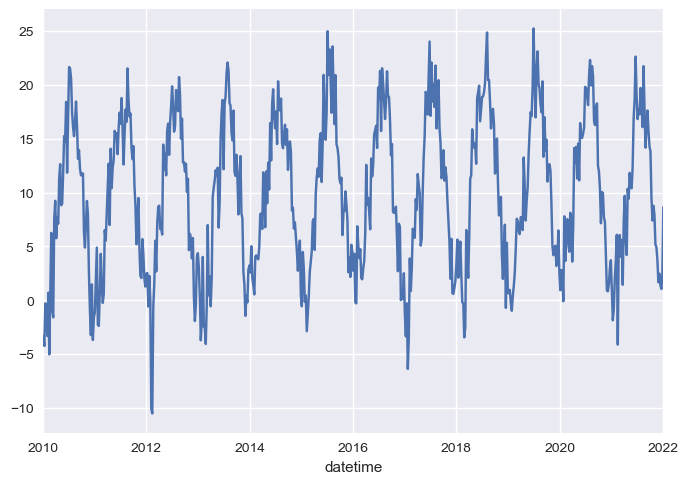

In [55]:
weekly['temp'].plot()

C:\Users\Mehrad Tavanamehr\AppData\Local\Temp\ipykernel_20124\749132483.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  sns.pointplot(x=weekly.index.week, y=weekly['temp'], palette="Set2")
C:\Users\Mehrad Tavanamehr\AppData\Local\Temp\ipykernel_20124\749132483.py:6: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


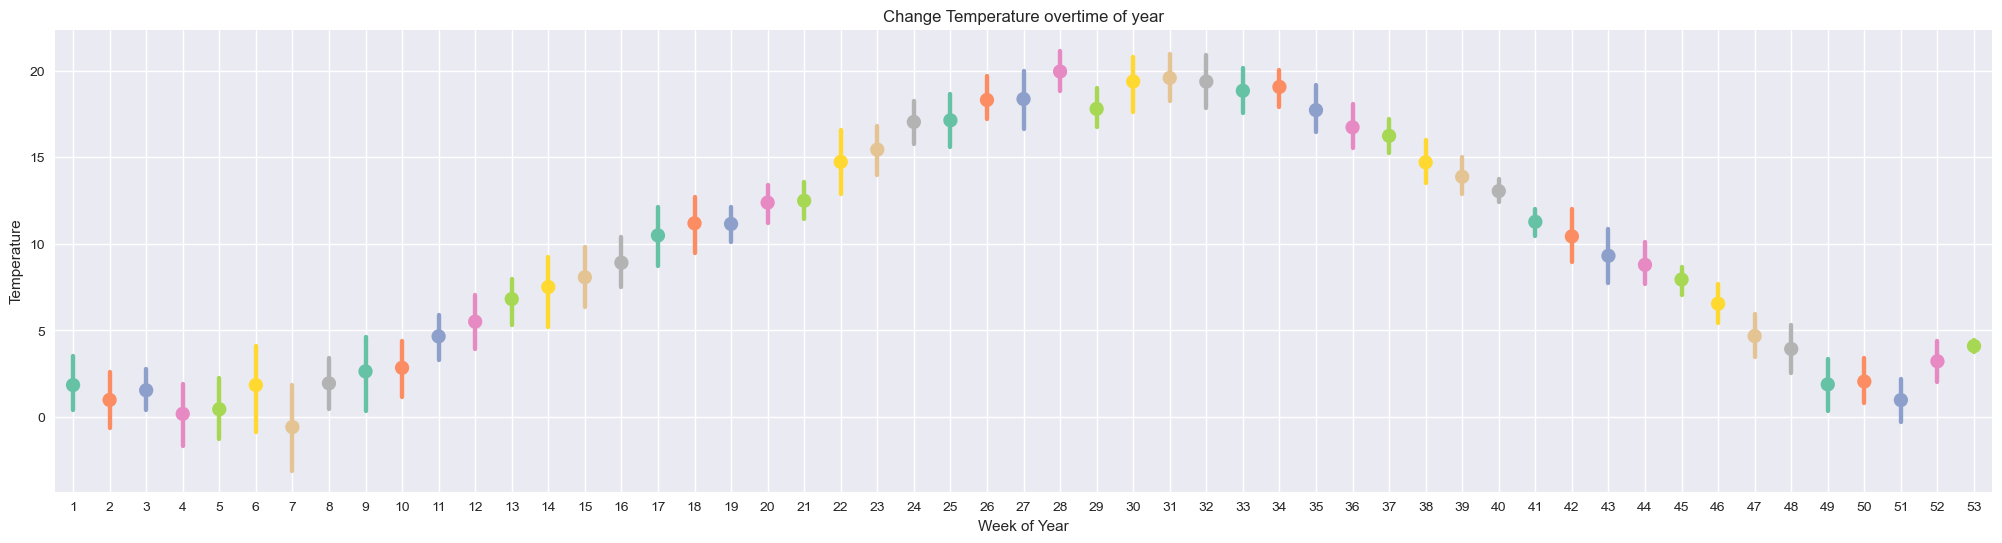

In [56]:
plt.figure(figsize=(25, 6))
sns.pointplot(x=weekly.index.week, y=weekly['temp'], palette="Set2")
plt.title("Change Temperature overtime of year")
plt.xlabel("Week of Year")
plt.ylabel("Temperature")
plt.grid(b=True)


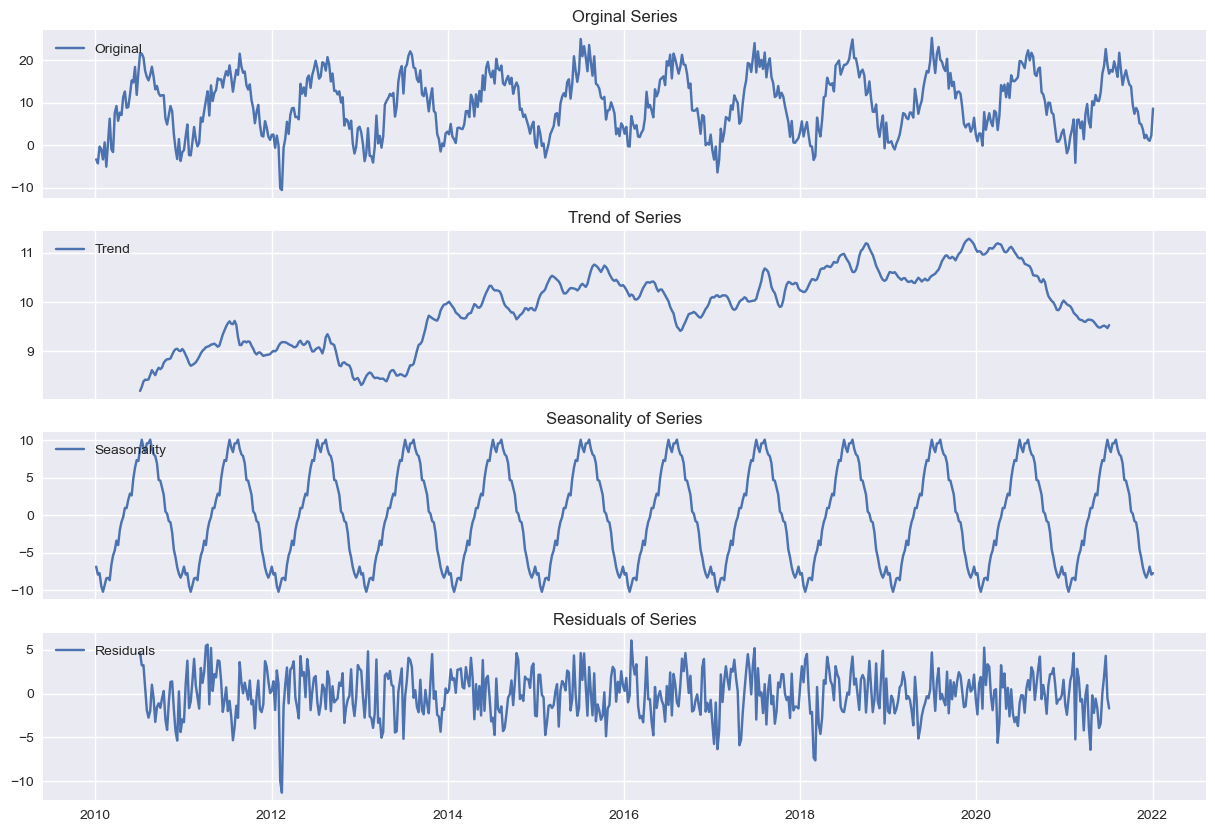

In [57]:
ss_decomposition(weekly['temp'], 'additive', 52)

Test Statistic         -1.176653e+01
p-value                 1.115607e-21
Lags Used               1.800000e+01
Observations Used       6.080000e+02
Critical Value (1%)    -3.441151e+00
Critical Value (5%)    -2.866305e+00
Critical Value (10%)   -2.569308e+00
dtype: float64


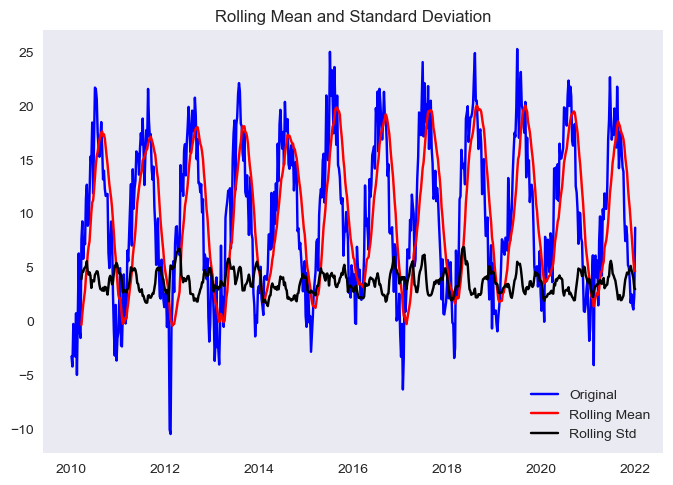

In [58]:
dftest(weekly['temp'])
# p-value allows us to reject a unit root: data is stationary

C:\Users\Mehrad Tavanamehr\.conda\envs\c10_final_project\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


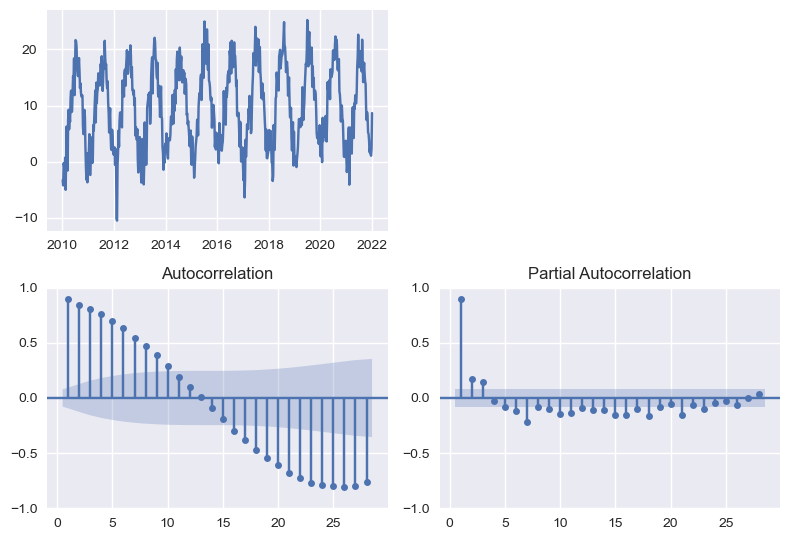

In [59]:
plots(weekly['temp'])

### [Box-Jenkins Method](https://en.wikipedia.org/wiki/Box–Jenkins_method)

ACF Shape|Indicated Model
---|---
Exponential, decaying to zero|Autoregressive model. Use the partial autocorrelation plot to identify the order of the autoregressive model.
Alternating positive and negative, decaying to zero|Autoregressive model. Use the partial autocorrelation plot to help identify the order.
One or more spikes, rest are essentially zero|Moving average model, order identified by where plot becomes zero.
Decay, starting after a few lags|Mixed autoregressive and moving average (ARMA) model.
All zero or close to zero|Data are essentially random.
High values at fixed intervals|Include seasonal autoregressive term.
No decay to zero|Series is not stationary.

#### finding the possible model
- manual search
- grid search

In [34]:
# based of above graph for weekly temp prediction
sar_weekly_1 = sm.tsa.statespace.SARIMAX(weekly['temp'], 
                                order=(3,0,0), 
                                seasonal_order=(3,0,0,52), 
                                trend='c').fit()
sar_weekly_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               temp   No. Observations:                  627
Model:             SARIMAX(3, 0, 0)x(3, 0, 0, 52)   Log Likelihood               -1568.983
Date:                            Tue, 31 Oct 2023   AIC                           3153.967
Time:                                    13:34:12   BIC                           3189.494
Sample:                                01-04-2010   HQIC                          3167.770
                                     - 01-03-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7177      0.140      5.122      0.000       0.443       0.992
ar.L1          0.6016      0.039     15.521      0.000       0.526       0.678
ar.L2          0.0607      0.044      1.364      0.173      -0.026       0.148
ar.L3          0.2003      0.037      5.415      0.000       0.128       0.273
ar.S.L52       0.1259      0.042      2.979      0.003       0.043       0.209
ar.S.L104      0.1971      0.042      4.652      0.000       0.114       0.280
ar.S.L156      0.1214      0.046      2.663      0.008       0.032       0.211
sigma2         8.5865      0.469     18.314      0.000       7.668       9.505
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):                 1.09
Prob(Q):                              0.61   Prob(JB):                         0.58
Heteroskedasticity (H):               0.79   Skew:                            -0.02
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\Mehrad Tavanamehr\.conda\envs\c10_final_project\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


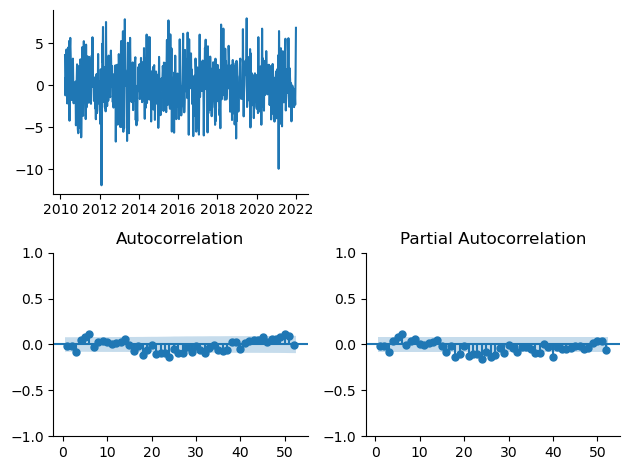

In [35]:
# plot resids
plots(sar_weekly_1.resid[sar.loglikelihood_burn:], lags=52);

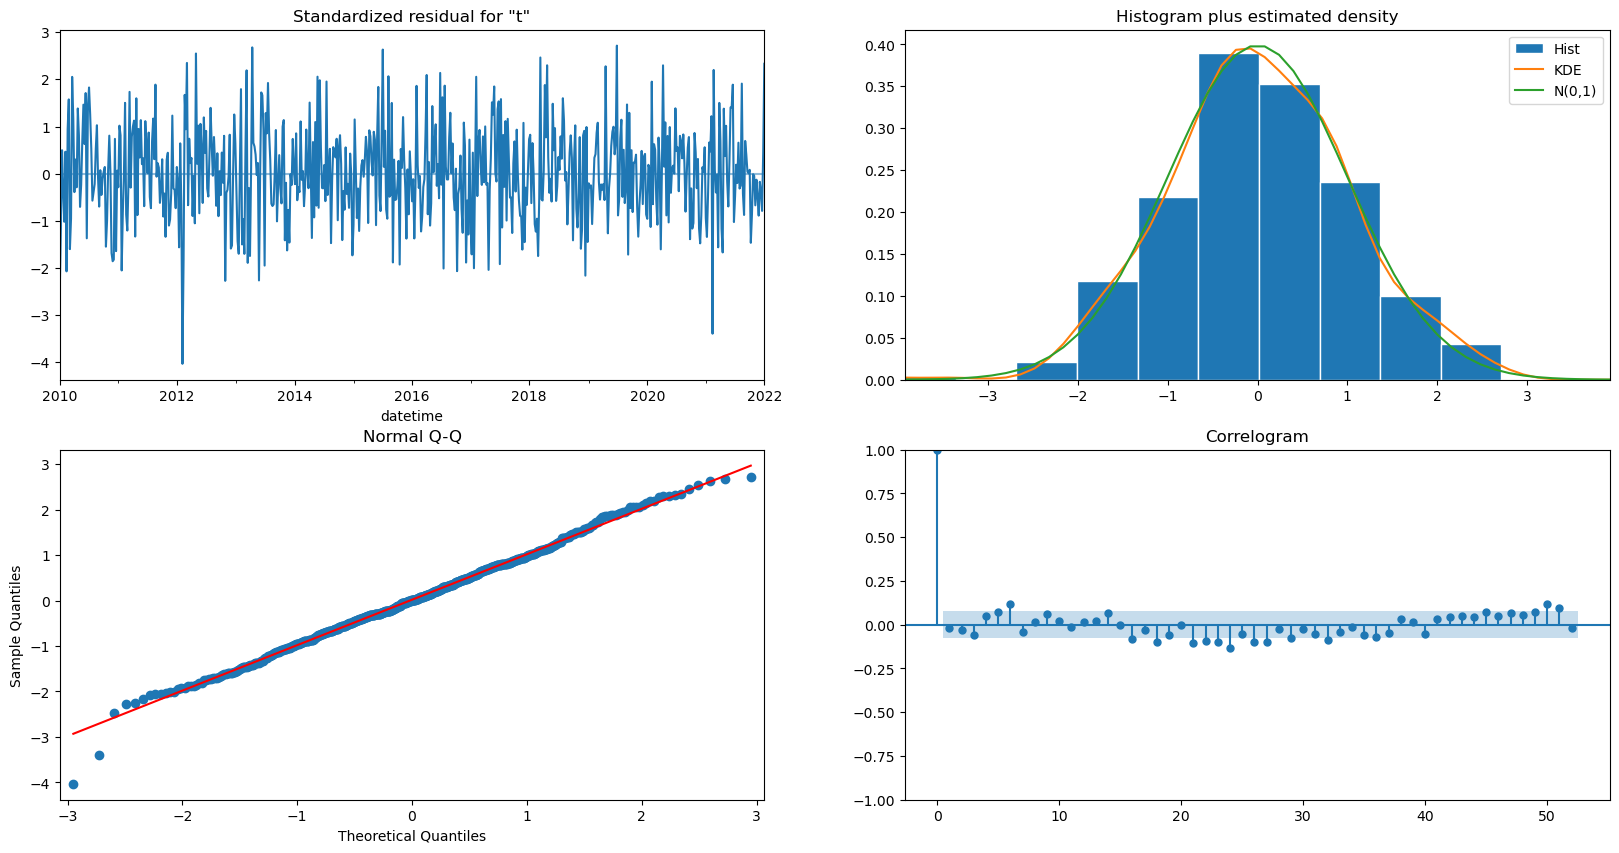

In [36]:
# plot residual diagnostics
sar_weekly_1.plot_diagnostics(lags=52,figsize = (20,10),);

In [37]:
# based of above graph for weekly temp prediction
sar_weekly_2 = sm.tsa.statespace.SARIMAX(weekly['temp'], 
                                order=(3,0,0), 
                                seasonal_order=(0,1,0,52), 
                                trend='c').fit()
sar_weekly_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               temp   No. Observations:                  627
Model:             SARIMAX(3, 0, 0)x(0, 1, 0, 52)   Log Likelihood               -1559.890
Date:                            Tue, 31 Oct 2023   AIC                           3129.781
Time:                                    13:34:22   BIC                           3151.552
Sample:                                01-04-2010   HQIC                          3138.272
                                     - 01-03-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0725      0.152      0.475      0.635      -0.226       0.371
ar.L1          0.3711      0.040      9.239      0.000       0.292       0.450
ar.L2         -0.0598      0.041     -1.451      0.147      -0.141       0.021
ar.L3          0.0610      0.040      1.537      0.124      -0.017       0.139
sigma2        13.2978      0.709     18.755      0.000      11.908      14.687
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.08
Prob(Q):                              0.95   Prob(JB):                         0.08
Heteroskedasticity (H):               0.69   Skew:                             0.01
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\Mehrad Tavanamehr\.conda\envs\c10_final_project\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


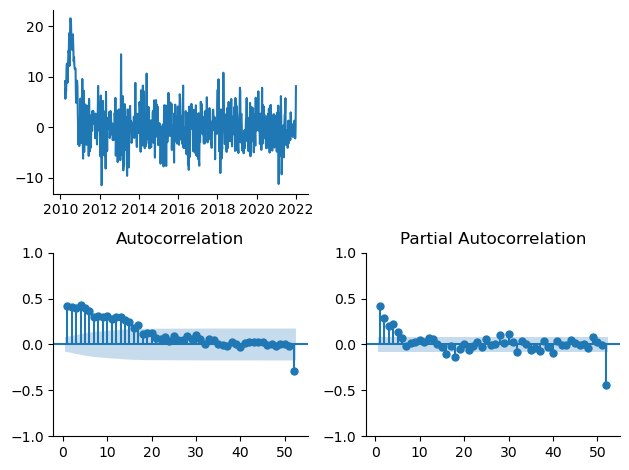

In [38]:
plots(sar_weekly_2.resid[sar.loglikelihood_burn:], lags=52);

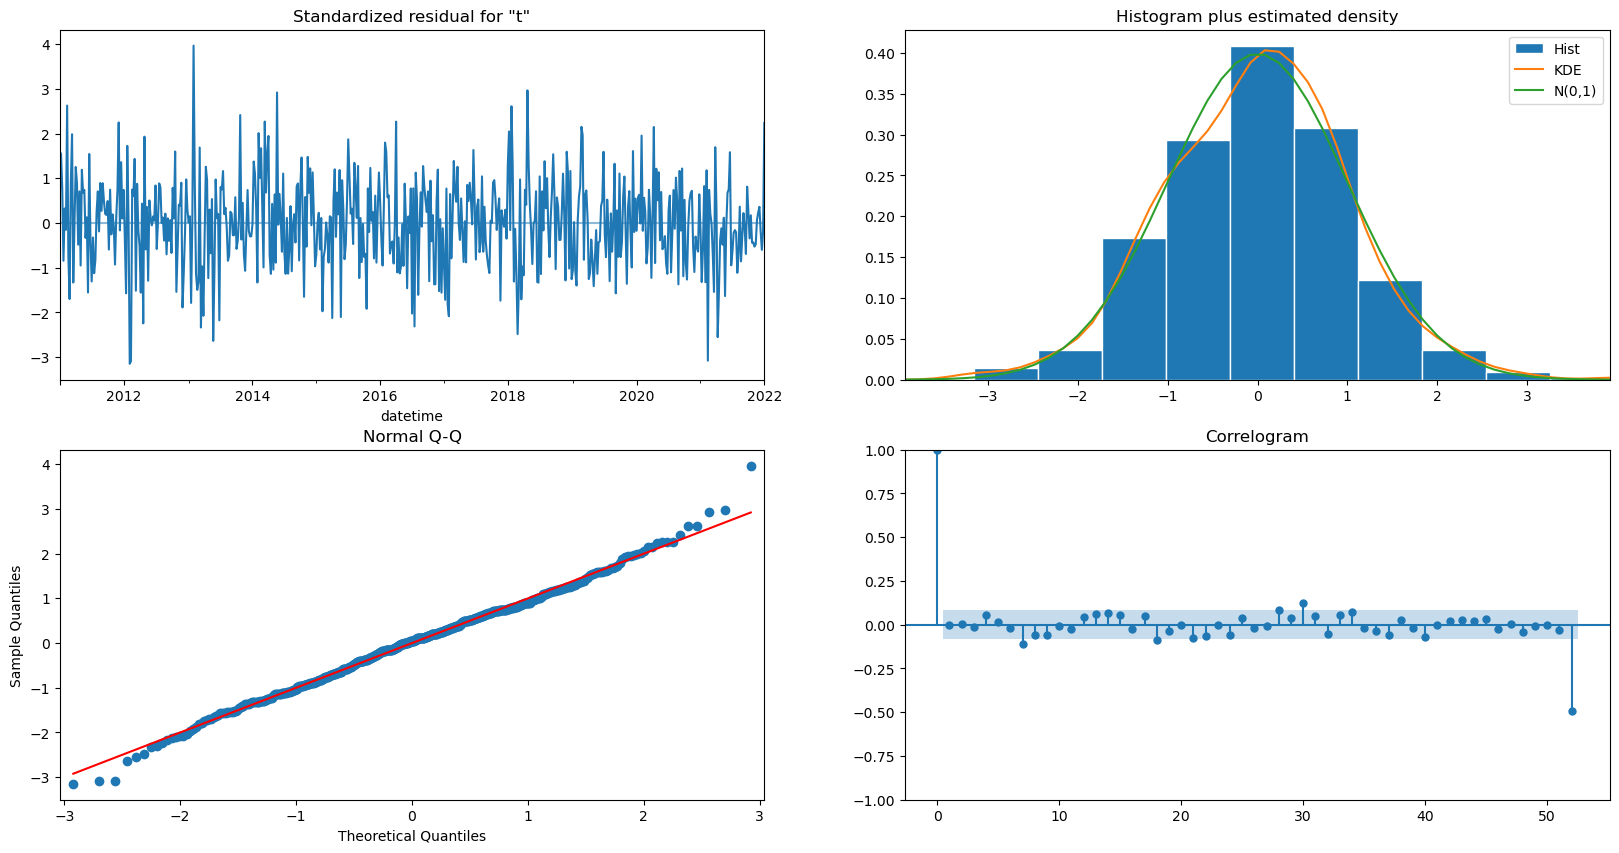

In [39]:
sar_weekly_2.plot_diagnostics(lags=52,figsize = (20,10),);

In [40]:
# based of above graph for weekly temp prediction
sar_weekly_3 = sm.tsa.statespace.SARIMAX(weekly['temp'], 
                                order=(3,0,0), 
                                seasonal_order=(0,1,1,52), 
                                trend='c').fit()
sar_weekly_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 temp   No. Observations:                  627
Model:             SARIMAX(3, 0, 0)x(0, 1, [1], 52)   Log Likelihood               -1418.750
Date:                              Tue, 31 Oct 2023   AIC                           2849.499
Time:                                      13:35:44   BIC                           2875.626
Sample:                                  01-04-2010   HQIC                          2859.689
                                       - 01-03-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0913      0.030      2.995      0.003       0.032       0.151
ar.L1          0.3422      0.039      8.813      0.000       0.266       0.418
ar.L2         -0.0514      0.042     -1.216      0.224      -0.134       0.031
ar.L3          0.0723      0.041      1.778      0.075      -0.007       0.152
ma.S.L52      -0.9968      2.388     -0.417      0.676      -5.676       3.683
sigma2         6.5180     15.410      0.423      0.672     -23.684      36.720
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 6.60
Prob(Q):                              0.96   Prob(JB):                         0.04
Heteroskedasticity (H):               0.77   Skew:                            -0.22
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\Mehrad Tavanamehr\.conda\envs\c10_final_project\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


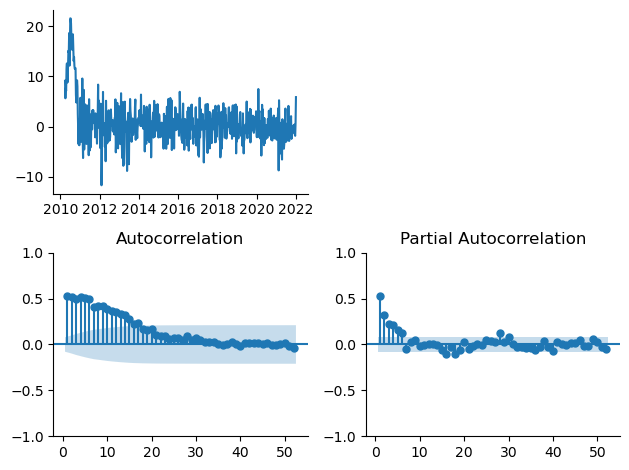

In [41]:
plots(sar_weekly_3.resid[sar.loglikelihood_burn:], lags=52);

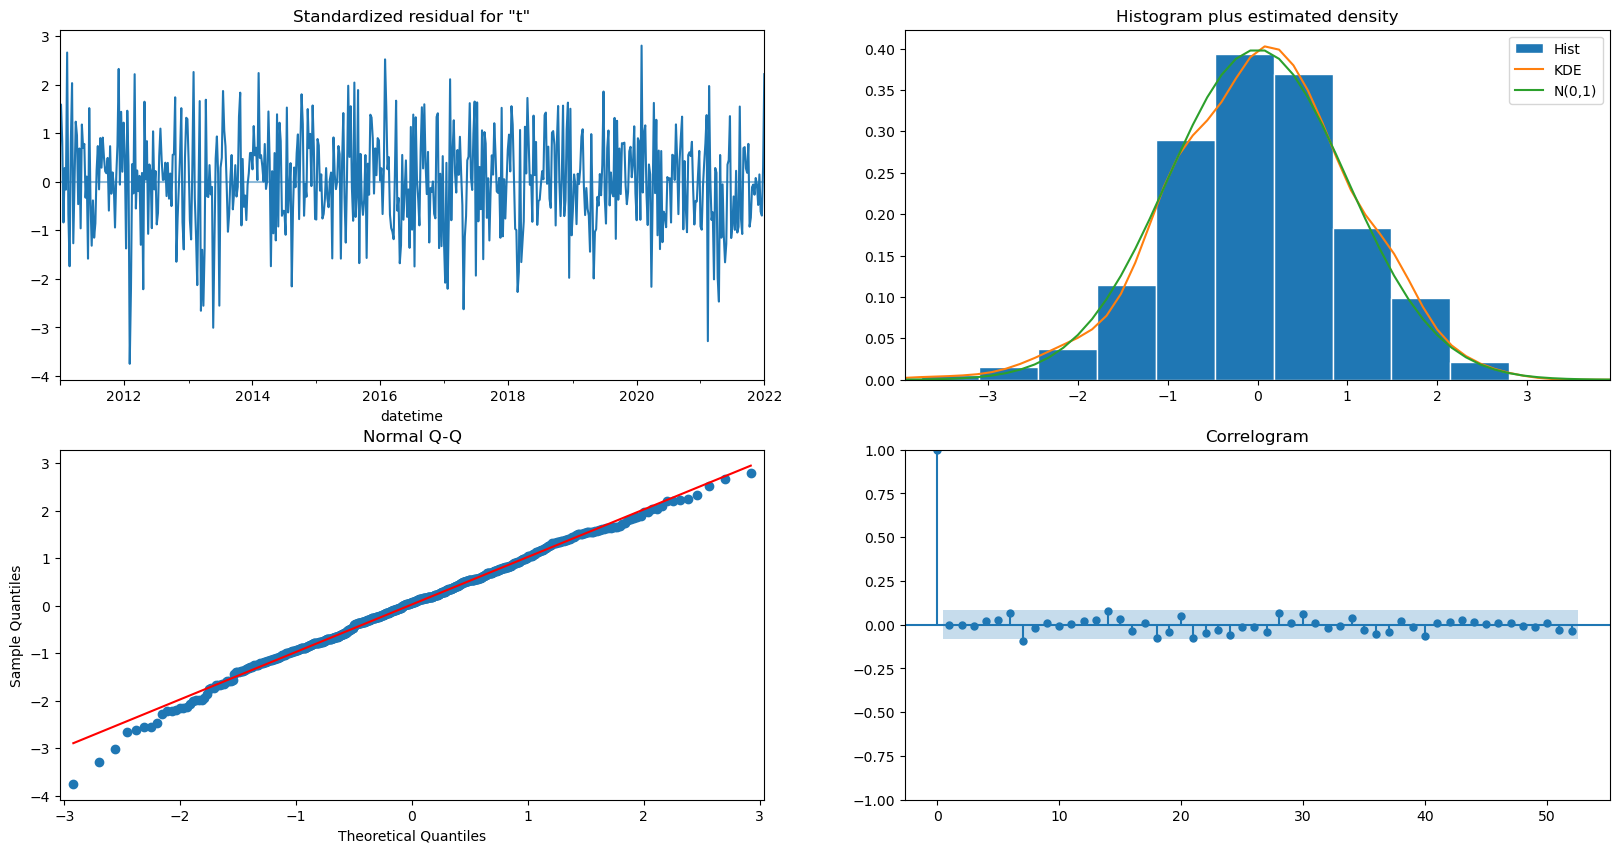

In [42]:
sar_weekly_3.plot_diagnostics(lags=52,figsize = (20,10),);

### Grid Search to find the best possible model of SARIMA

According to above I decide do in that in  two different searches one with D = 0 and another one with D = 1

In [ ]:
auto_model = pm.auto_arima(weekly['temp'], start_p=0, start_q=0,
                           max_p=3, max_q=3, m=52,
                           start_P=0, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
- ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=3181.863, Time=10.32 sec
- ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=4236.062, Time=0.02 sec
- ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=3210.352, Time=5.01 sec
- ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=3594.970, Time=5.65 sec
- ARIMA(0,0,0)(0,0,0)[52]             : AIC=4893.811, Time=0.01 sec
- ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=3185.530, Time=0.32 sec
- ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=inf, Time=28.19 sec
- ARIMA(2,0,2)(0,0,2)[52] intercept   : AIC=3168.571, Time=45.74 sec
- ARIMA(2,0,2)(1,0,2)[52] intercept   : AIC=inf, Time=106.93 sec
- ARIMA(1,0,2)(0,0,2)[52] intercept   : AIC=3169.073, Time=26.98 sec
- ARIMA(2,0,1)(0,0,2)[52] intercept   : AIC=3170.858, Time=30.66 sec
- ARIMA(3,0,2)(0,0,2)[52] intercept   : AIC=3070.423, Time=106.35 sec
- ARIMA(3,0,2)(0,0,1)[52] intercept   : AIC=3023.374, Time=24.64 sec
- ARIMA(3,0,2)(0,0,0)[52] intercept   : AIC=3010.975, Time=0.97 sec
- ARIMA(3,0,2)(1,0,0)[52] intercept   : AIC=3092.861, Time=27.16 sec
- ARIMA(3,0,2)(1,0,1)[52] intercept   : AIC=inf, Time=24.70 sec
- ARIMA(3,0,1)(0,0,0)[52] intercept   : AIC=3182.205, Time=0.27 sec
- ARIMA(3,0,3)(0,0,0)[52] intercept   : AIC=3176.988, Time=1.04 sec
- ARIMA(2,0,1)(0,0,0)[52] intercept   : AIC=3186.353, Time=0.22 sec
- ARIMA(2,0,3)(0,0,0)[52] intercept   : AIC=3014.381, Time=0.91 sec



- Best model:  ARIMA(3,0,2)(0,0,0)[52] intercept 
Total fit time: 446.552 seconds

In [34]:
auto_model = pm.auto_arima(weekly['temp'], start_p=0, start_q=0,
                           max_p=2, max_q=2, m=52,
                           start_P=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=inf, Time=22.89 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=3203.971, Time=0.99 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=2952.869, Time=21.48 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=32.23 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=3202.383, Time=0.70 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=3128.703, Time=3.49 sec
 ARIMA(1,0,0)(2,1,0)[52] intercept   : AIC=2907.280, Time=58.86 sec
 ARIMA(1,0,0)(2,1,1)[52] intercept   : AIC=inf, Time=137.01 sec
 ARIMA(1,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=29.44 sec
 ARIMA(0,0,0)(2,1,0)[52] intercept   : AIC=2964.618, Time=47.80 sec
 ARIMA(2,0,0)(2,1,0)[52] intercept   : AIC=2907.928, Time=76.74 sec
 ARIMA(1,0,1)(2,1,0)[52] intercept   : AIC=2907.468, Time=93.63 sec
 ARIMA(0,0,1)(2,1,0)[52] intercept   : AIC=2906.432, Time=59.06 sec
 ARIMA(0,0,1)(1,1,0)[52] intercept   : AIC=2951.990, Time=17.28 sec
 ARIMA(0,0,1)(2,1,1)[52] in

MemoryError: Unable to allocate 51.7 MiB for an array with shape (104, 104, 627) and data type float64

Exception ignored in: 'statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.reset_filter_method'
Traceback (most recent call last):
  File "statsmodels\tsa\statespace\_kalman_smoother.pyx", line 1000, in statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.allocate_arrays
numpy.core._exceptions.MemoryError: Unable to allocate 51.7 MiB for an array with shape (104, 104, 627) and data type float64


AttributeError: Memoryview is not initialized

In [34]:
# based on minimum value of aic when I using D in the sessional I just add it to without 
sar_weekly_4 = sm.tsa.statespace.SARIMAX(weekly['temp'], 
                                order=(3,0,2), 
                                seasonal_order=(0,1,0,52), 
                                trend='c').fit()
sar_weekly_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                temp   No. Observations:                  627
Model:             SARIMAX(3, 0, 2)x(0, 1, [], 52)   Log Likelihood               -1560.528
Date:                             Tue, 31 Oct 2023   AIC                           3135.057
Time:                                     15:21:45   BIC                           3165.537
Sample:                                 01-04-2010   HQIC                          3146.945
                                      - 01-03-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1162      0.242      0.480      0.631      -0.358       0.590
ar.L1          0.7203      0.099      7.308      0.000       0.527       0.913
ar.L2         -1.0814      0.100    -10.778      0.000      -1.278      -0.885
ar.L3          0.3428      0.049      6.986      0.000       0.247       0.439
ma.L1         -0.3585      0.097     -3.704      0.000      -0.548      -0.169
ma.L2          0.9343      0.097      9.599      0.000       0.744       1.125
sigma2        13.3261      0.714     18.665      0.000      11.927      14.725
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 5.29
Prob(Q):                              0.86   Prob(JB):                         0.07
Heteroskedasticity (H):               0.71   Skew:                             0.01
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
# based on minimum value of aic when I using D in the sessional I just add it to without 
sar_weekly_5 = sm.tsa.statespace.SARIMAX(weekly['temp'], 
                                order=(3,0,1), 
                                seasonal_order=(2,1,0,52), 
                                trend='c').fit()
sar_weekly_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                temp   No. Observations:                  627
Model:             SARIMAX(3, 0, 1)x(2, 1, [], 52)   Log Likelihood               -1447.322
Date:                             Tue, 31 Oct 2023   AIC                           2910.643
Time:                                     15:27:42   BIC                           2945.478
Sample:                                 01-04-2010   HQIC                          2924.230
                                      - 01-03-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1237      0.159      0.776      0.438      -0.189       0.436
ar.L1          0.5862      0.734      0.799      0.424      -0.852       2.024
ar.L2         -0.1477      0.248     -0.597      0.551      -0.633       0.338
ar.L3          0.0586      0.049      1.194      0.233      -0.038       0.155
ma.L1         -0.2533      0.737     -0.344      0.731      -1.697       1.191
ar.S.L52      -0.7031      0.041    -17.183      0.000      -0.783      -0.623
ar.S.L104     -0.3059      0.042     -7.350      0.000      -0.387      -0.224
sigma2         8.5622      0.494     17.328      0.000       7.594       9.531
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 6.22
Prob(Q):                              0.98   Prob(JB):                         0.04
Heteroskedasticity (H):               0.79   Skew:                            -0.22
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\Mehrad Tavanamehr\.conda\envs\c10_final_project\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


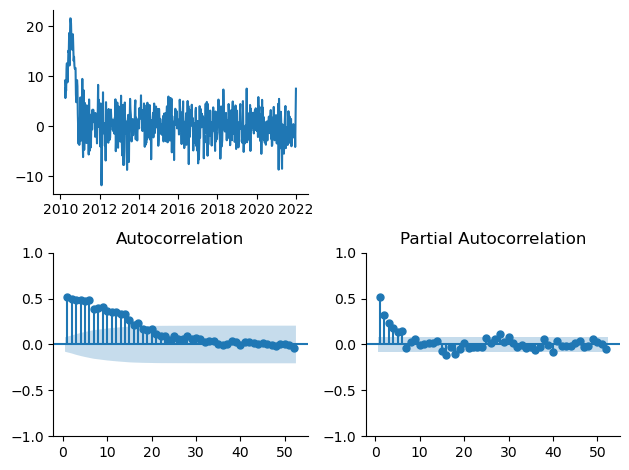

In [37]:
plots(sar_weekly_5.resid[sar.loglikelihood_burn:], lags=52);

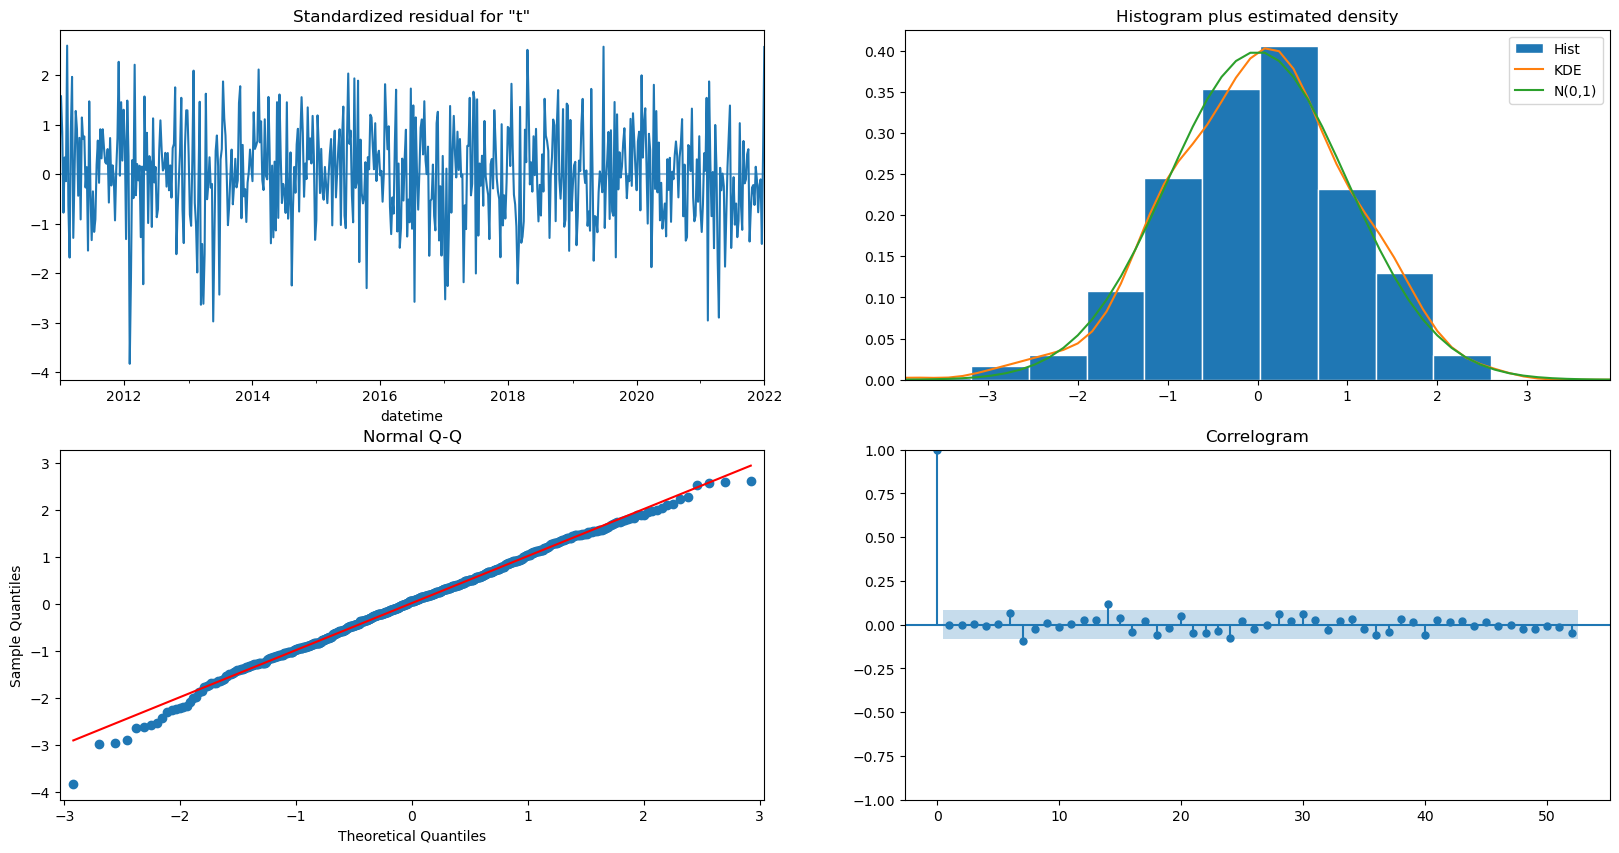

In [38]:
sar_weekly_5.plot_diagnostics(lags=52,figsize = (20,10),);

In [69]:
# based on minimum value of aic when I using D in the sessional I just add it to without 
sar_weekly_6 = sm.tsa.statespace.SARIMAX(weekly['temp'], 
                                order=(3,0,2), 
                                seasonal_order=(0,0,0,52), 
                                trend='c').fit()
sar_weekly_6.summary()

C:\Users\Mehrad Tavanamehr\.conda\envs\c10_final_project\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   temp   No. Observations:                  627
Model:               SARIMAX(3, 0, 2)   Log Likelihood               -1503.660
Date:                Tue, 31 Oct 2023   AIC                           3021.319
Time:                        17:39:33   BIC                           3052.406
Sample:                    01-04-2010   HQIC                          3033.397
                         - 01-03-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0986      0.007     14.824      0.000       0.086       0.112
ar.L1          2.2748      0.045     50.285      0.000       2.186       2.363
ar.L2         -1.5802      0.088    -17.859      0.000      -1.754      -1.407
ar.L3          0.2951      0.044      6.722      0.000       0.209       0.381
ma.L1         -1.8678      0.033    -55.996      0.000      -1.933      -1.802
ma.L2          0.8813      0.033     26.520      0.000       0.816       0.946
sigma2         6.7591      0.360     18.793      0.000       6.054       7.464
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):                10.72
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.23
Prob(H) (two-sided):                  0.12   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\Mehrad Tavanamehr\.conda\envs\c10_final_project\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


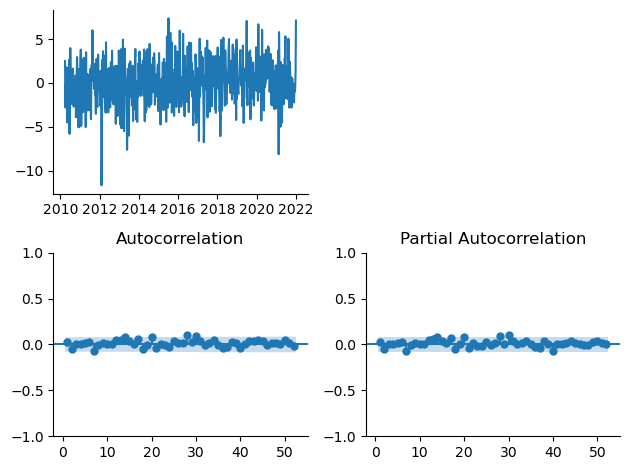

In [70]:
plots(sar_weekly_6.resid[sar.loglikelihood_burn:], lags=52);

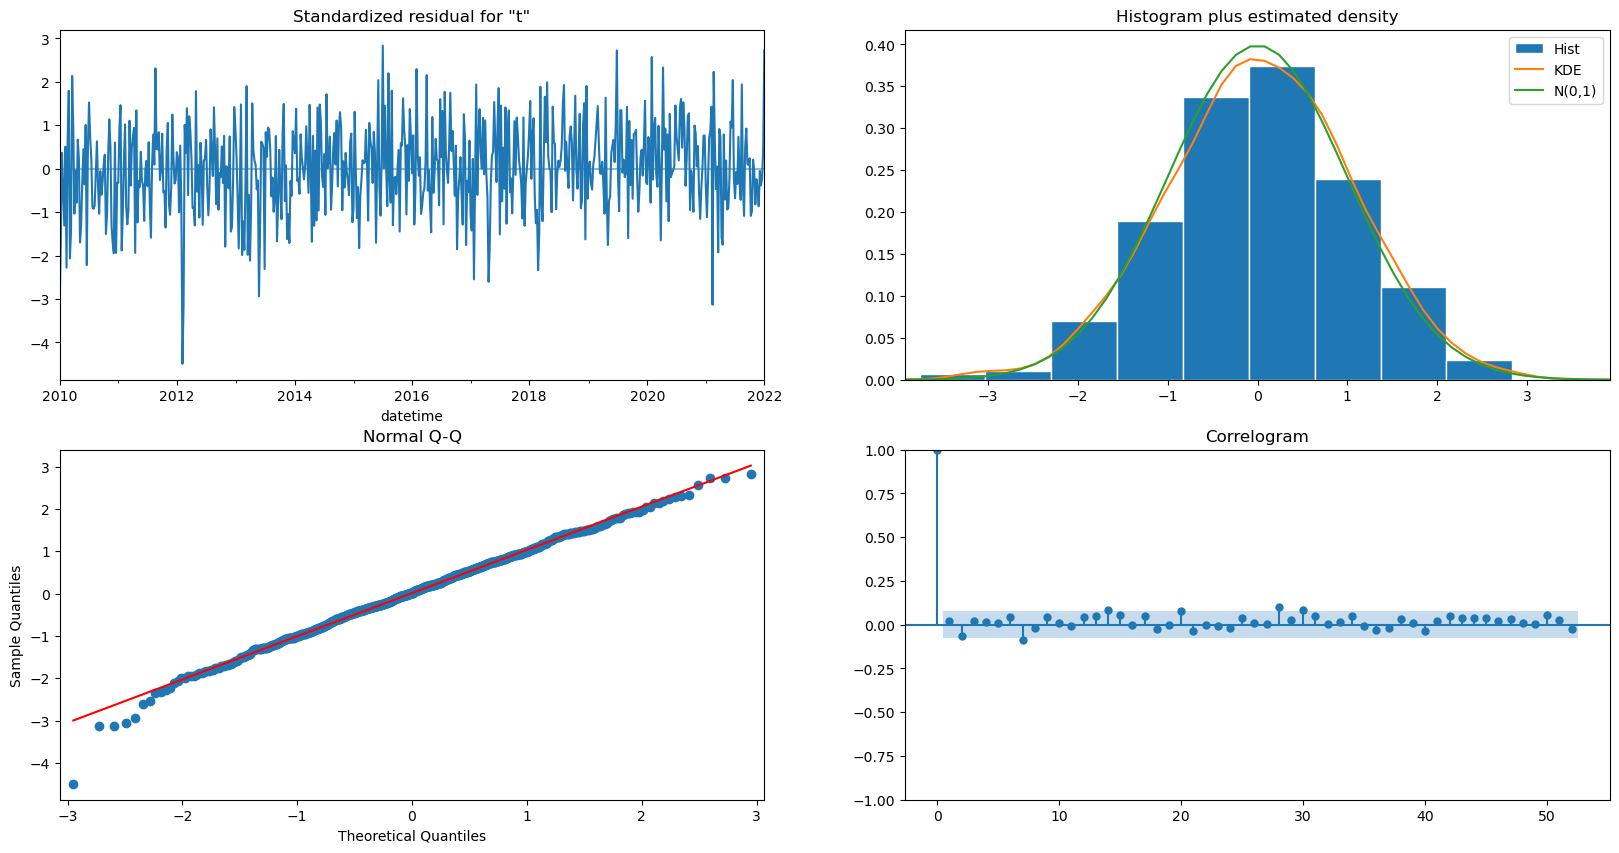

In [71]:
sar_weekly_6.plot_diagnostics(lags=52,figsize = (20,10),);

In [41]:
# based on minimum value of aic when I using D in the sessional I just add it to without 
sar_weekly_7 = sm.tsa.statespace.SARIMAX(weekly['temp'], 
                                order=(0,0,1), 
                                seasonal_order=(2,1,0,52), 
                                trend='c').fit()
sar_weekly_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                temp   No. Observations:                  627
Model:             SARIMAX(0, 0, 1)x(2, 1, [], 52)   Log Likelihood               -1448.216
Date:                             Tue, 31 Oct 2023   AIC                           2906.432
Time:                                     15:37:53   BIC                           2928.204
Sample:                                 01-04-2010   HQIC                          2914.924
                                      - 01-03-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2419      0.175      1.384      0.166      -0.101       0.585
ma.L1          0.3226      0.038      8.571      0.000       0.249       0.396
ar.S.L52      -0.7082      0.041    -17.369      0.000      -0.788      -0.628
ar.S.L104     -0.3077      0.041     -7.430      0.000      -0.389      -0.227
sigma2         8.5833      0.497     17.268      0.000       7.609       9.558
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 6.88
Prob(Q):                              0.75   Prob(JB):                         0.03
Heteroskedasticity (H):               0.80   Skew:                            -0.24
Prob(H) (two-sided):                  0.12   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\Mehrad Tavanamehr\.conda\envs\c10_final_project\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


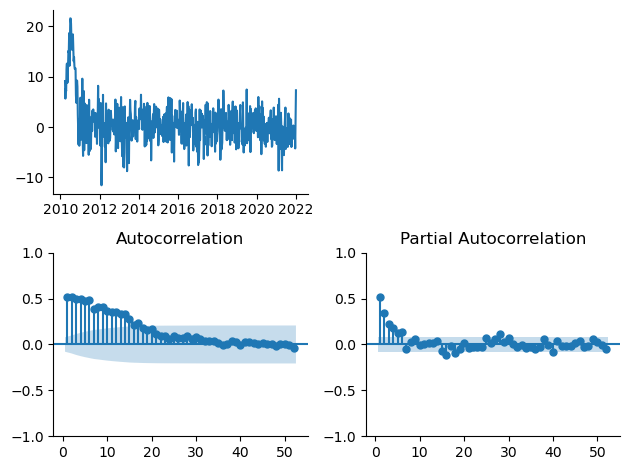

In [45]:
plots(sar_weekly_7.resid[sar.loglikelihood_burn:], lags=52);

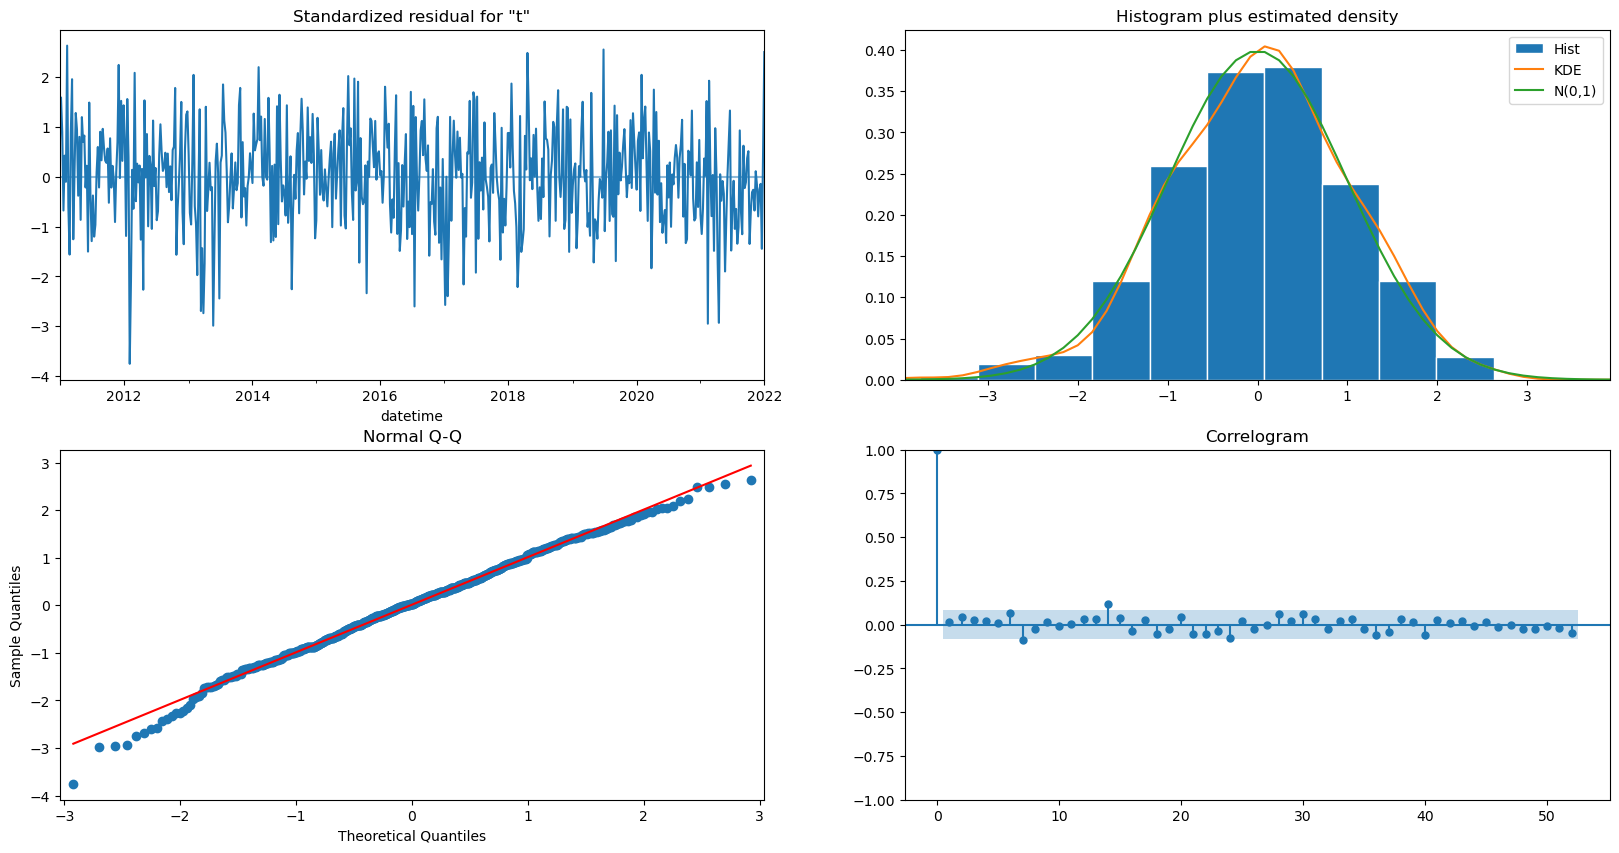

In [46]:
sar_weekly_7.plot_diagnostics(lags=52,figsize = (20,10),);

In [42]:
# According to some example I have seen, there is possible with reducing of repeated time we get better result
auto_model = pm.auto_arima(weekly['temp'], start_p=0, start_q=0,
                           max_p=3, max_q=3, m=51,
                           start_P=0, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,1)[51] intercept   : AIC=3919.244, Time=4.16 sec
 ARIMA(0,0,0)(0,0,0)[51] intercept   : AIC=4236.062, Time=0.12 sec
 ARIMA(1,0,0)(1,0,0)[51] intercept   : AIC=3203.094, Time=10.36 sec
 ARIMA(0,0,1)(0,0,1)[51] intercept   : AIC=3585.514, Time=5.32 sec
 ARIMA(0,0,0)(0,0,0)[51]             : AIC=4893.811, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[51] intercept   : AIC=3211.302, Time=0.28 sec
 ARIMA(1,0,0)(2,0,0)[51] intercept   : AIC=3196.254, Time=55.14 sec
 ARIMA(1,0,0)(2,0,1)[51] intercept   : AIC=inf, Time=112.83 sec
 ARIMA(1,0,0)(1,0,1)[51] intercept   : AIC=inf, Time=22.38 sec
 ARIMA(0,0,0)(2,0,0)[51] intercept   : AIC=inf, Time=50.10 sec
 ARIMA(2,0,0)(2,0,0)[51] intercept   : AIC=3173.305, Time=79.25 sec
 ARIMA(2,0,0)(1,0,0)[51] intercept   : AIC=3180.335, Time=11.36 sec
 ARIMA(2,0,0)(2,0,1)[51] intercept   : AIC=inf, Time=126.25 sec
 ARIMA(2,0,0)(1,0,1)[51] intercept   : AIC=inf, Time=26.52 sec
 ARIMA(3,0,0)(2,0,0)[51] intercep

When deciding on a model, often what truly matters is how well we would be able to produce out of sample predictions. Here we create a function that looks at multiple out of sample predictions to see which model had lowest out of sample error

In addition with using of croo validation, I will use grid search to find the best model from selected one

In [55]:
len(weekly)

627

In [60]:
series = weekly.temp
horizon = 52
start = 500
step_size = 4
orders = [(3,0,2)]
seasonal_orders = [(0,0,0,52)]
trends = [None,'c']

grid_search_ARIMA(series = series,
                  horizon = horizon,
                  start = start,
                  step_size = step_size,
                  orders = orders,
                  seasonal_orders = seasonal_orders,
                  trends=trends)

C:\Users\Mehrad Tavanamehr\.conda\envs\c10_final_project\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mehrad Tavanamehr\.conda\envs\c10_final_project\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mehrad Tavanamehr\.conda\envs\c10_final_project\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mehrad Tavanamehr\.conda\envs\c10_final_project\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

((3, 0, 2), (0, 0, 0, 52), 'c', 0.22681251736416222)

In [61]:
series = weekly.temp
horizon = 52
start = 500
step_size = 4
orders = [(0,0,1)]
seasonal_orders = [(2,1,0,52)]
trends = [None,'c']

grid_search_ARIMA(series = series,
                  horizon = horizon,
                  start = start,
                  step_size = step_size,
                  orders = orders,
                  seasonal_orders = seasonal_orders,
                  trends=trends)

((0, 0, 1), (2, 1, 0, 52), None, 0.21249815664549193)

In [63]:
series = weekly.temp
horizon = 52
start = 500
step_size = 4
orders = [(3,0,2)]
seasonal_orders = [(2,1,0,52)]
trends = ['c']

grid_search_ARIMA(series = series,
                  horizon = horizon,
                  start = start,
                  step_size = step_size,
                  orders = orders,
                  seasonal_orders = seasonal_orders,
                  trends=trends)

C:\Users\Mehrad Tavanamehr\.conda\envs\c10_final_project\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mehrad Tavanamehr\.conda\envs\c10_final_project\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mehrad Tavanamehr\.conda\envs\c10_final_project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mehrad Tavanamehr\.conda\envs\c10_final_project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting par

C:\Users\Mehrad Tavanamehr\.conda\envs\c10_final_project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mehrad Tavanamehr\.conda\envs\c10_final_project\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mehrad Tavanamehr\.conda\envs\c10_final_project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mehrad Tavanamehr\.conda\envs\c10_final_project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. U

((3, 0, 2), (2, 1, 0, 52), 'c', 0.24648091569694988)

In [60]:
# based on minimum value of aic when I using D in the sessional I just add it to without  
sar_weekly_8 = sm.tsa.statespace.SARIMAX(weekly['temp'], 
                                order=(0,0,1), 
                                seasonal_order=(2,1,0,52), 
                                trend=None).fit()
sar_weekly_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                temp   No. Observations:                  627
Model:             SARIMAX(0, 0, 1)x(2, 1, [], 52)   Log Likelihood               -1440.483
Date:                             Tue, 09 Jan 2024   AIC                           2888.966
Time:                                     21:32:47   BIC                           2906.384
Sample:                                 01-04-2010   HQIC                          2895.759
                                      - 01-03-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3312      0.038      8.820      0.000       0.258       0.405
ar.S.L52      -0.7016      0.041    -17.262      0.000      -0.781      -0.622
ar.S.L104     -0.3012      0.041     -7.319      0.000      -0.382      -0.221
sigma2         8.3649      0.487     17.177      0.000       7.410       9.319
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 6.77
Prob(Q):                              0.81   Prob(JB):                         0.03
Heteroskedasticity (H):               0.77   Skew:                            -0.24
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\Mehrad Tavanamehr\.conda\envs\c10_final_project\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


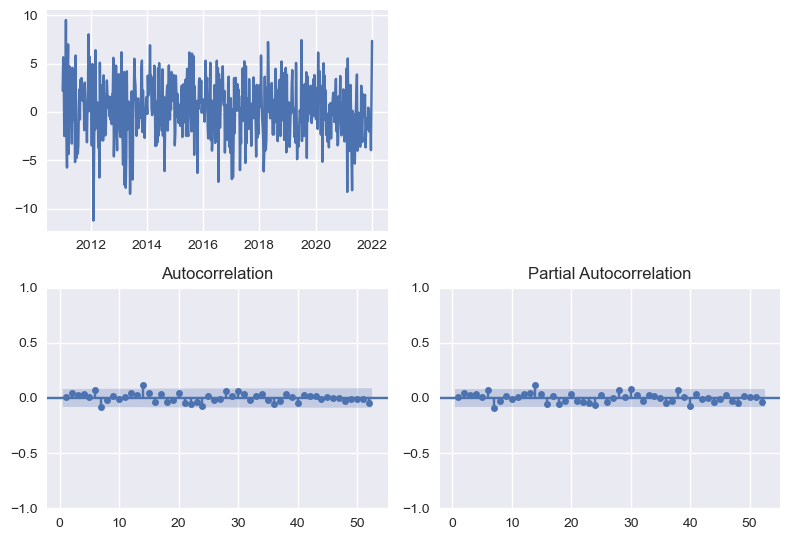

In [62]:
plots(sar_weekly_8.resid[sar_weekly_8.loglikelihood_burn:], lags=52);

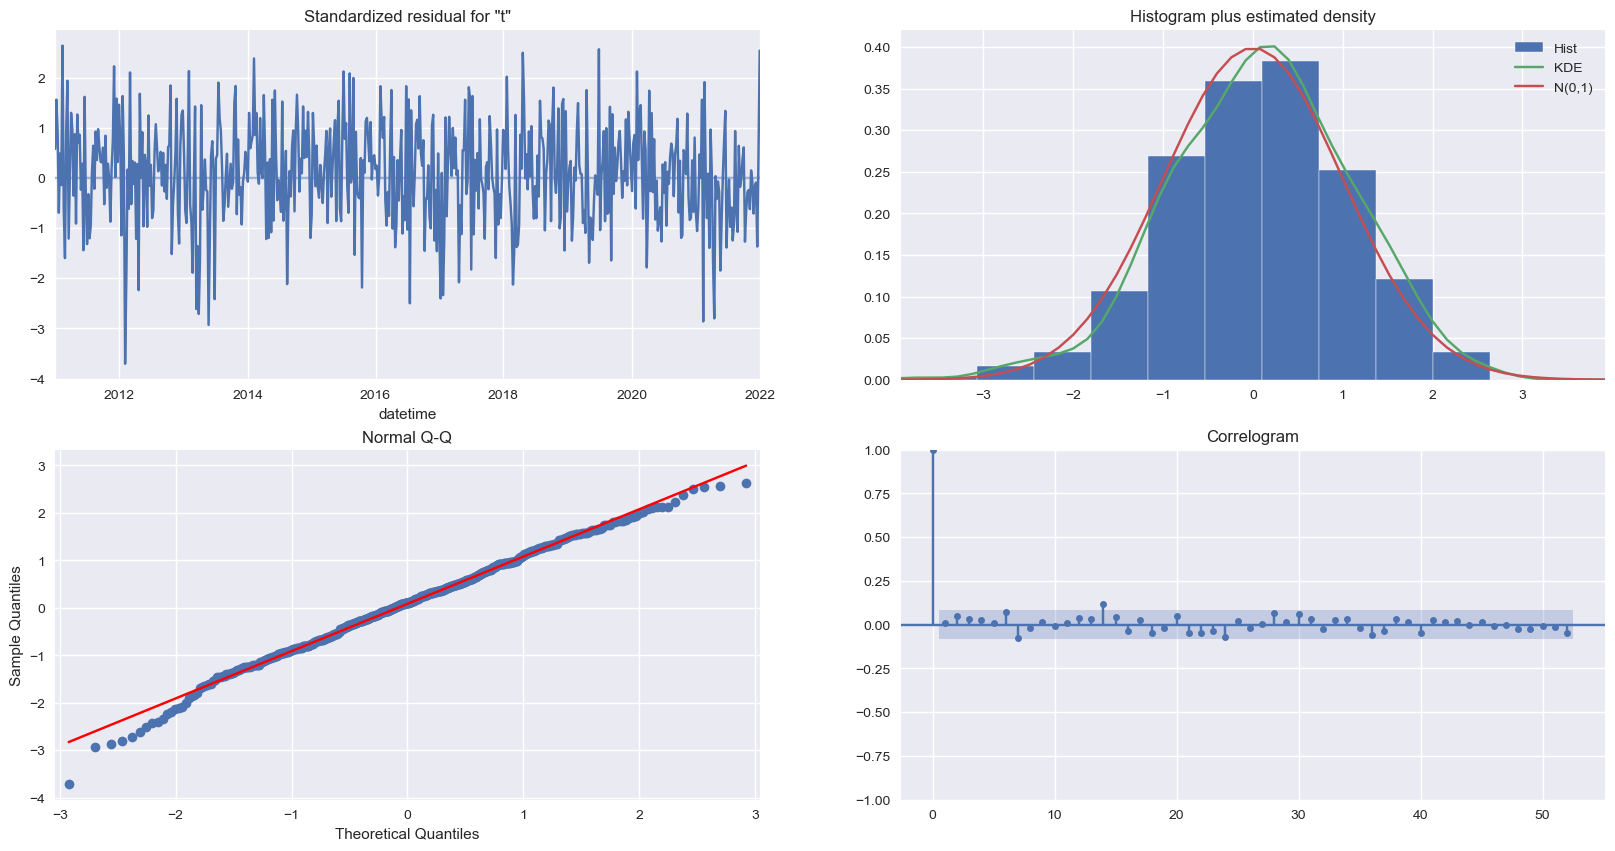

In [63]:
sar_weekly_8.plot_diagnostics(lags=52,figsize = (20,10),);

I have value of possiblity,
- (order:(3, 0, 2), session_order:(0, 0, 0, 52), trend:'c', mape:0.22681251736416222), defined model: sar_weekly_6
- (order:(0, 0, 1), session_order:(2, 1, 0, 52), trend:None, mape:0.21249815664549193), defined model: sar_weekly_8

For last select the best model when using SARIMA, I will use the prediction and graph

Text(0, 0.5, 'temperature')

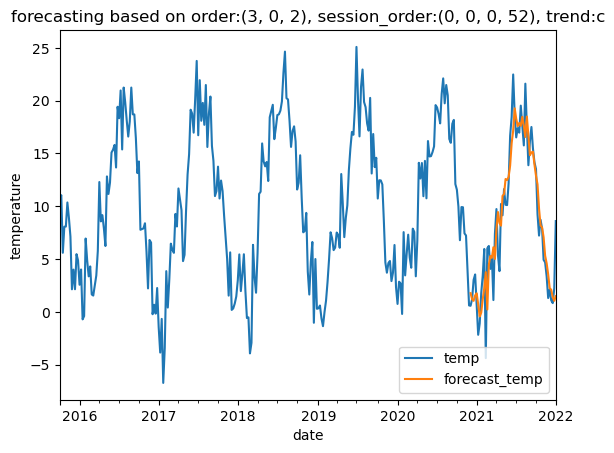

In [112]:
# plot predictions (3,0,2)
pd.plotting.register_matplotlib_converters()

weekly['forecast_temp'] = sar_weekly_6.predict(start = 570, end= 626)  
weekly[300:][['temp', 'forecast_temp']].plot()
plt.title('forecasting based on order:(3, 0, 2), session_order:(0, 0, 0, 52), trend:c')
plt.xlabel('date')
plt.ylabel('temperature')

Text(0, 0.5, 'temperature')

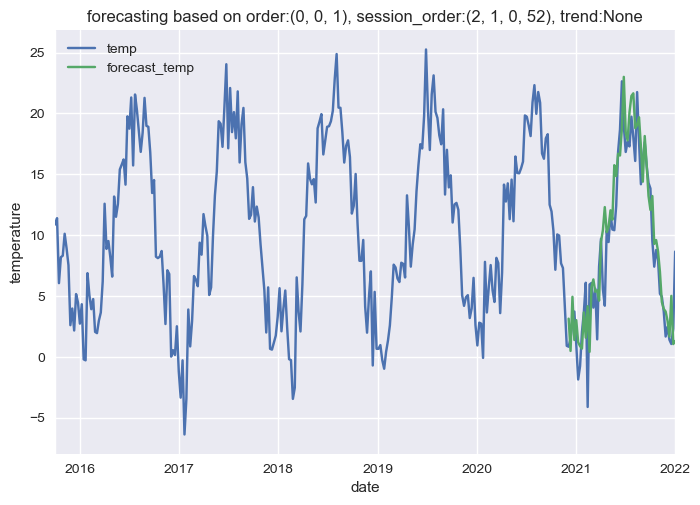

In [64]:
# plot predictions (0,0,1)
pd.plotting.register_matplotlib_converters()

weekly['forecast_temp'] = sar_weekly_8.predict(start = 570, end= 626)  
weekly[300:][['temp', 'forecast_temp']].plot()
plt.title('forecasting based on order:(0, 0, 1), session_order:(2, 1, 0, 52), trend:None')
plt.xlabel('date')
plt.ylabel('temperature')

In [65]:
from dateutil.relativedelta import relativedelta
def future_preds_df(model,series,num_weeks):
    pred_first = series.index.max()+relativedelta(weeks=1)
    pred_last = series.index.max()+relativedelta(weeks=num_weeks)
    date_range_index = pd.date_range(pred_first,pred_last,freq = 'W-MON')
    vals = model.predict(len(series), len(series)+num_weeks)
    return pd.DataFrame(vals,index = date_range_index)

In [66]:
preds = future_preds_df(sar_weekly_8,weekly.temp,52)

Text(0, 0.5, 'temperature')

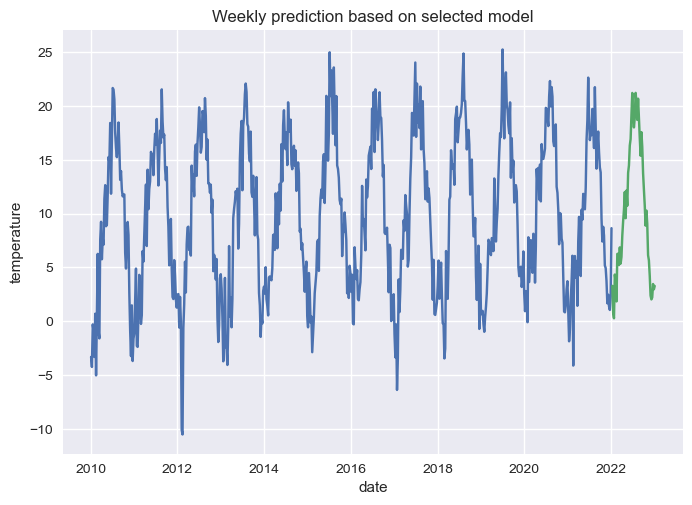

In [67]:
plt.plot(weekly.temp)
plt.plot(preds)
plt.title('Weekly prediction based on selected model')
plt.xlabel('date')
plt.ylabel('temperature')

In [68]:
preds.rename(columns={'predicted_mean':'temp'},inplace=True)

In [69]:
preds

temp
2022-01-10   3.292821
2022-01-17   0.783749
2022-01-24   0.278774
2022-01-31   4.342886
2022-02-07   3.678179
2022-02-14   1.845105
2022-02-21   6.255755
2022-02-28   6.280318
2022-03-07   5.223765
2022-03-14   6.866643
2022-03-21   5.365418
2022-03-28   5.981013
2022-04-04   7.970908
2022-04-11   9.289887
2022-04-18  10.359924
2022-04-25  12.014228
2022-05-02   9.576714
2022-05-09  12.145099
2022-05-16  10.736170
2022-05-23  13.793886
2022-05-30  14.485729
2022-06-06  16.329674
2022-06-13  16.933326
2022-06-20  19.140249
2022-06-27  21.215321
2022-07-04  19.056436
2022-07-11  18.012538
2022-07-18  18.918307
2022-07-25  21.222911
2022-08-01  20.389180
2022-08-08  18.708964
2022-08-15  20.683422
2022-08-22  18.907363
2022-08-29  17.049608
2022-09-05  15.383137
2022-09-12  17.574571
2022-09-19  16.211342
2022-09-26  13.762180
2022-10-03  12.235012
2022-10-10  10.761744
2022-10-17   8.885982
2022-10-24  10.285696
2022-10-31   9.070541
2022-11-07   6.146187
2022-11-14   5.660558
2022-11-21   4.248684
2022-11-28   2.387692
2022-12-05   2.029499
2022-12-12   2.217581
2022-12-19   3.462257
2022-12-26   2.968593
2023-01-02   3.279211

Save selected model

In [114]:
pwd

'E:\\AI_Program\\Course10_project'

In [115]:
cd models

E:\AI_Program\Course10_project\models


In [116]:
from joblib import dump, load
dump(sar_weekly_8, 'Timeseries_temp_SARIMA.joblib') 

['Timeseries_temp_SARIMA.joblib']

In [15]:
preds.to_csv('./data/predict_temp.csv')